## Process Outline
* Pull FERC Plants & Fuel tables, merge them together & sum fuel values per plant.
* Pull EIA MCOE values on a per-generator basis.
* Define masks for each of FERC & EIA that allow us to isolate the records of interest.
* Filter the big FERC & EIA tables using those masks to get the relevant plant & generator records.
* Now we have the "raw data" that will be listed as the sources information for the summary table (with some column renaming and/or dropping).
* Merging the two tables together for the purpose of summarizing per plant or per unit costs is the hard part.
* FERC Ownership:
  * Sum up all the various ownership slices from different respondents on each plant.
  * Simplifies the data, and gives a per-plant picture in the summary output.
  * May need to do some magic here to compensate for e.g. partial ownership reporting with a plant like Rodemacher (70% public, 30% private)
* Each EIA generator record needs an ID that says which FERC plant it should be associated with.
* When there's data only in one of the two data sources, that's okay -- we will do an outer merge. But each record still needs to have one of these IDs associated with it.
* For each record there are a few ways that data from the two data sources can be combined:
  1. One EIA generator maps cleanly to one FERC plant -- easy!
  2. Several EIA generators are represented by a single FERC plant owned by one respondent.
  3. Several EIA generators are represented by a single FERC plant owned by several respondents.
* For each summary record we have several cases to address:
  1. We have data for the plant from both FERC (plant) & EIA (generator). In this case, each EIA generator gets the same FERC data associated with it, but each generator keeps its own ID.
  2. We only have data from FERC (e.g. before 2009). In this case, the only ID we have is the FERC plant.
  3. We only have data from EIA (e.g. public plants). In this case, we have only the EIA fields.
* For each generator, for each year, we need to have a record. Many of them may have some null data, but that's okay -- it just won't plot.


In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import init, mcoe, analysis, settings, outputs
import pudl.constants as pc
import pudl.extract.ferc1

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

## Load the FERC Plants & Fuel Data from PUDL

In [39]:
plants_steam_ferc1 = pudl.outputs.plants_steam_ferc1()
fuel_ferc1 = pudl.outputs.fuel_ferc1()

## Merge FERC Plants & Fuel together and do some massage

In [40]:
ferc_gb_cols = ['report_year', 'respondent_id', 'plant_name']
fuel_ferc1_agg = fuel_ferc1.groupby(ferc_gb_cols).agg({
    'fuel_consumed_total_cost_mmbtu': sum,
    'fuel_consumed_total_mmbtu': sum
})

fuel_ferc1_agg.rename(columns={'fuel_consumed_total_cost_mmbtu': 'total_fuel_cost',
                               'fuel_consumed_total_mmbtu': 'total_mmbtu'}, inplace=True)
fuel_ferc1_agg.reset_index(inplace=True)
ferc_df = pd.merge(plants_steam_ferc1, fuel_ferc1_agg, on=ferc_gb_cols)
ferc_df.rename(columns={'total_capacity_mw': 'nameplate_capacity_mw',
                         'respondent_name': 'utility_name',
                         'respondent_id': 'utility_id'}, inplace=True)

# Calculate some derived values:
ferc_df['capacity_factor'] = ferc_df.net_generation_mwh/(ferc_df.nameplate_capacity_mw*8760)
ferc_df['heat_rate_mmbtu_mwh'] = ferc_df.total_mmbtu/ferc_df.net_generation_mwh
ferc_df['fuel_cost_per_mwh'] = ferc_df.expns_fuel/ferc_df.net_generation_mwh
ferc_df['expns_nonfuel'] = ferc_df.expns_production_total-ferc_df.expns_fuel
ferc_df['expns_nonfuel_per_mwh'] = ferc_df.expns_nonfuel/ferc_df.net_generation_mwh

In [41]:
# Rename the FERC columns to play nice with the EIA dataframe & outputs...
ferc_df.rename(columns={'total_capacity_mw': 'nameplate_capacity_mw',
                        'respondent_name': 'utility_name',
                        'respondent_id': 'utility_id'}, inplace=True)

In [43]:
# these are the columns we actually want to keep in our output.
ferc_cols = [
    'report_year',
    'utility_id',
    'utility_name',
    'plant_id_pudl',
    'plant_name',
    'plant_name_ces',
    'avg_num_employees',
    'expns_boiler',
    'expns_coolants',
    'expns_electric',
    'expns_engineering',
    'expns_fuel',
    'expns_misc_power',
    'expns_misc_steam',
    'expns_operations',
    'expns_per_mwh',
    'expns_plants',
    'expns_production_total',
    'expns_rents',
    'expns_steam',
    'expns_steam_other',
    'expns_structures',
    'expns_transfer',
    'net_generation_mwh',
    'nameplate_capacity_mw',
]

## Create a PUDL output object and grab the EIA MCOE results

In [44]:
pudl_out = pudl.outputs.PudlOutput(freq='A')

In [45]:
eia_df = pudl_out.mcoe()

plant_id_eia  unit_id_pudl
1004          3                         [1, CT1]
1904          1                     [HBR0, BDS0]
1927          2                     [RIV0, HBR0]
4040          1                     [PWG1, PWG2]
10725         1                     [F801, F802]
50973         1               [BLK1, BLK2, BLK3]
55153         1                     [STG1, STG2]
55309         1                     [SMR1, SMR2]
55502         1                 [CC1, G801, CC2]
56041         1                       [NGS, MGS]
56350         1                      [BLK1, 115]
              2                      [BLK2, 116]
56998         1                        [43, PB4]
              2                        [53, PB5]
Name: unit_code, dtype: object


## Define the EIA & PUDL fields we want to extract

In [46]:
eia_cols = [
    'report_date',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'plant_name_ces',
    'utility_id',
    'util_id_pudl',
    'utility_name',
    
    'state',
    'latitude',
    'longitude',
    'iso_rto_code',
    'balancing_authority_code',
    'fuel_type_pudl',
    'nameplate_capacity_mw',
    'planned_retirement_date',
    
    'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    
    'net_generation_mwh',
    'total_mmbtu',
    'total_fuel_cost'
]
eia_df['report_year'] = eia_df.report_date.dt.year
eia_df.rename(columns={'operator_name': 'utility_name',
                       'operator_id': 'utility_id'}, inplace=True)

## Enumerate the FERC & EIA selectors/masks
* For each target plant, create an EIA mask and a FERC mask, which when applied to the EIA or FERC dataframe results in a list of records that can be merged based on report year.
* Zip those masks together, and use them with the full dataframes to compile an output dataframe of just the desired plant records.

In [47]:
eia_masks = {}
ferc_masks = {}
ferc_plant_ids = {}
eia_plant_ids = {}
######################################################################
# 1.) RODEMACHER / BRAME ENERGY CENTER
######################################################################
eia_masks['rodemacher'] = ((eia_df.plant_id_eia==6190) &
                           (eia_df.unit_id_pudl==2))
eia_plant_ids['rodemacher']='rodemacher'
ferc_masks['rodemacher'] = (ferc_df.plant_name.str.match('.*odemach.*2'))
ferc_plant_ids['rodemacher']='rodemacher'

######################################################################
# 2.) OKLAUNION
######################################################################
eia_masks['oklaunion'] = (eia_df.plant_id_eia==127)
eia_plant_ids['oklaunion'] = 'oklaunion'

ferc_plant_ids['oklaunion_psok']='oklaunion'
ferc_masks['oklaunion_psok'] = ((ferc_df.plant_name.str.match('.*klaunion.*')) &
                                (ferc_df.utility_id==148))

ferc_plant_ids['oklaunion_aeptx_north']='oklaunion'
ferc_masks['oklaunion_aeptx_north'] = ((ferc_df.plant_name.str.match('.*klaunion.*')) &
                                       (ferc_df.utility_id==189))

ferc_plant_ids['oklaunion_aeptx_central']='oklaunion'
ferc_masks['oklaunion_aeptx_central'] = ((ferc_df.plant_name.str.match('.*klaunion.*')) &
                                         (ferc_df.utility_id==24))

######################################################################
# 3.) HOLCOMB (publicly owned, no FERC)
######################################################################
eia_masks['holcomb'] = (eia_df.plant_id_eia==108)
eia_plant_ids['holcomb']='holcomb'

######################################################################
# 4.) JEFFREY
######################################################################
eia_masks['jeffrey1'] = ((eia_df.plant_id_eia==6068) &
                         (eia_df.unit_id_pudl==1))
eia_plant_ids['jeffrey1'] = 'jeffrey'
eia_masks['jeffrey2'] = ((eia_df.plant_id_eia==6068) &
                         (eia_df.unit_id_pudl==2))
eia_plant_ids['jeffrey2'] = 'jeffrey'
eia_masks['jeffrey3'] = ((eia_df.plant_id_eia==6068) &
                         (eia_df.unit_id_pudl==3))
eia_plant_ids['jeffrey3'] = 'jeffrey'

ferc_plant_ids['jeffrey_westar']='jeffrey'
ferc_masks['jeffrey_westar'] = ((ferc_df.plant_name.str.match('.*effrey.*')) &
                                (ferc_df.utility_id==191) &
                                (ferc_df.expns_fuel > 0.0))
ferc_plant_ids['jeffrey_ksgeco']='jeffrey'
ferc_masks['jeffrey_ksgeco'] = ((ferc_df.plant_name.str.match('.*effrey.*')) &
                                (ferc_df.utility_id==80) &
                                (ferc_df.expns_fuel > 0.0))
ferc_plant_ids['jeffrey_kcpl']='jeffrey'
ferc_masks['jeffrey_kcpl'] = ((ferc_df.plant_name.str.match('.*effrey.*')) &
                              (ferc_df.utility_id==182) &
                              (ferc_df.expns_fuel > 0.0))

######################################################################
# 5.) GERALD GENTLEMAN (publicly owned, no FERC)
######################################################################
eia_masks['gerald_gentleman1'] = ((eia_df.plant_id_eia==6077) &
                                  (eia_df.unit_id_pudl==1))
eia_plant_ids['gerald_gentleman1']='gerald_gentleman1'
eia_masks['gerald_gentleman2'] = ((eia_df.plant_id_eia==6077) &
                                  (eia_df.unit_id_pudl==2))
eia_plant_ids['gerald_gentleman2']='gerald_gentleman2'

######################################################################
# 6.) LA CYGNE
######################################################################
eia_masks['lacygne1'] = ((eia_df.plant_id_eia==1241) &
                         (eia_df.unit_id_pudl==1))
eia_plant_ids['lacygne1']='lacygne1'
eia_masks['lacygne2'] = ((eia_df.plant_id_eia==1241) &
                         (eia_df.unit_id_pudl==2))
eia_plant_ids['lacygne2']='lacygne2'

ferc_plant_ids['lacygne1_kcpl']='lacygne1'
ferc_masks['lacygne1_kcpl'] = (
    (ferc_df.plant_name.str.match('(La Cygne 50%|Lacygne 50%|Lacygne 1.*)')) &
    (ferc_df.utility_id==79)
)
ferc_plant_ids['lacygne2_kcpl']='lacygne2'
ferc_masks['lacygne2_kcpl'] = ((ferc_df.plant_name.str.match('.*ygne.*2.*')) &
                               (ferc_df.utility_id==79))
ferc_plant_ids['lacygne1_kge']='lacygne1'
ferc_masks['lacygne1_kge'] = ((ferc_df.plant_name.str.match('.*ygne.*#1.*')) &
                              (ferc_df.utility_id==80))
ferc_plant_ids['lacygne2_kge']='lacygne2'
ferc_masks['lacygne2_kge'] = ((ferc_df.plant_name.str.match('.*ygne.*#2.*')) &
                              (ferc_df.utility_id==80))


######################################################################
# 7.) SIBLEY
######################################################################
eia_masks['sibley1'] = ((eia_df.plant_id_eia==2094) &
                        (eia_df.unit_id_pudl==1))
eia_plant_ids['sibley1']='sibley'
eia_masks['sibley2'] = ((eia_df.plant_id_eia==2094) &
                        (eia_df.unit_id_pudl==2))
eia_plant_ids['sibley2']='sibley'
eia_masks['sibley3'] = ((eia_df.plant_id_eia==2094) &
                        (eia_df.unit_id_pudl==3))
eia_plant_ids['sibley3']='sibley'

ferc_plant_ids['sibley']='sibley'
ferc_masks['sibley'] = ((ferc_df.utility_id==182) &
                        (ferc_df.plant_name=='Sibley'))

######################################################################
# 8.) NEBRASKA CITY (publicly owned, no FERC)
######################################################################
eia_masks['nebraska_city1'] = ((eia_df.plant_id_eia==6096) &
                               (eia_df.unit_id_pudl==1))
eia_plant_ids['nebraska_city1'] = 'nebraska_city1'
eia_masks['nebraska_city2'] = ((eia_df.plant_id_eia==6096) &
                               (eia_df.unit_id_pudl==2))
eia_plant_ids['nebraska_city2'] = 'nebraska_city2'

######################################################################
# 9.) SOONER (publicly owned, no FERC)
######################################################################
eia_masks['sooner1'] = ((eia_df.plant_id_eia==6095) &
                        (eia_df.unit_id_pudl==1))
eia_plant_ids['sooner1'] = 'sooner1'
eia_masks['sooner2'] = ((eia_df.plant_id_eia==6095) &
                        (eia_df.unit_id_pudl==2))
eia_plant_ids['sooner2'] = 'sooner2'

######################################################################
# 10.) GEORGE NEAL 
######################################################################
eia_masks['george_neal_north1'] = ((eia_df.plant_id_eia==1091) &
                                   (eia_df.unit_id_pudl==1))
eia_plant_ids['george_neal_north1'] = 'george_neal1'

eia_masks['george_neal_north2'] = ((eia_df.plant_id_eia==1091) &
                                   (eia_df.unit_id_pudl==2))
eia_plant_ids['george_neal_north2'] = 'george_neal2'

eia_masks['george_neal_north3'] = ((eia_df.plant_id_eia==1091) &
                                   (eia_df.unit_id_pudl==3))
eia_plant_ids['george_neal_north3'] = 'george_neal3'

ferc_plant_ids['george_neal3'] = 'george_neal3'
ferc_masks['george_neal3'] = ((ferc_df.plant_name.str.match('George Neal.*3')))

ferc_plant_ids['george_neal4'] = 'george_neal4'
ferc_masks['george_neal4'] = ((ferc_df.plant_name.str.match('George Neal.*4')))

In [49]:
ferc_masks['rodemacher']

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
9841    False
9842    False
9843    False
9844    False
9845    False
9846    False
9847    False
9848    False
9849    False
9850    False
9851    False
9852    False
9853    False
9854    False
9855    False
9856    False
9857    False
9858    False
9859    False
9860    False
9861    False
9862    False
9863    False
9864    False
9865    False
9866    False
9867    False
9868    False
9869    False
9870    False
Name: plant_name, Length: 9871, dtype: bool

In [11]:

ferc_out = pd.DataFrame()
for target in ferc_masks.keys():
    tmp_df = ferc_df[ferc_masks[target]].copy()
    tmp_df['plant_name_ces'] = target
    tmp_df['plant_id_ces'] = ferc_plant_ids[target]
    ferc_out = pd.concat([ferc_out, tmp_df])

eia_out = pd.DataFrame()
for target in eia_masks.keys():
    tmp_df = eia_df[eia_masks[target]].copy()
    tmp_df['plant_name_ces'] = target
    tmp_df['plant_id_ces'] = eia_plant_ids[target]
    eia_out = pd.concat([eia_out, tmp_df])

In [12]:
ferc_plant_gb = ferc_out.groupby(['plant_id_ces','report_year'])
calc_cols =  ['report_year','plant_id_ces','expns_nonfuel_per_mwh','net_generation_mwh'] 
ferc_byplant = ferc_plant_gb.agg({'net_generation_mwh': sum,
                                  'expns_nonfuel': sum,
                                  'expns_fuel': sum,
                                  'total_mmbtu': sum,
                                  'nameplate_capacity_mw': sum})
ferc_byplant = ferc_byplant.reset_index()
# Adjust Rodemacher for it's messed up ownership/capacity reporting
ferc_byplant.loc[ferc_byplant.plant_id_ces=='rodemacher','nameplate_capacity_mw'] = \
    ferc_byplant[ferc_byplant.plant_id_ces=='rodemacher']['nameplate_capacity_mw']*0.3
ferc_byplant[ferc_byplant.plant_id_ces=='rodemacher']
ferc_byplant = ferc_byplant.set_index(['plant_id_ces','report_year'])
ferc_byplant['expns_nonfuel_per_mwh'] = ferc_byplant['expns_nonfuel'] / ferc_byplant['net_generation_mwh']
ferc_byplant['expns_fuel_per_mwh'] = ferc_byplant['expns_fuel'] / ferc_byplant['net_generation_mwh']
ferc_byplant['heat_rate_mmbtu_mwh'] = ferc_byplant['total_mmbtu'] / ferc_byplant['net_generation_mwh']
ferc_byplant['capacity_factor'] = ferc_byplant['net_generation_mwh'] / (8760*ferc_byplant['nameplate_capacity_mw'])


In [36]:
eia_df.sample(10)

report_date  plant_id_eia  plant_id_pudl  unit_id_pudl generator_id  \
25755  2016-12-31         56596            653             1            5   
12971  2016-12-31          7213            115             2            2   
4555   2016-12-31          1400            578             3            3   
10537  2011-12-31          3809            659             1            1   
4268   2011-12-31          1379           1793             4            3   
11913  2014-12-31          6085            502             3           17   
23625  2015-12-31         55322            323             1          ST1   
6250   2009-12-31          2080            388             2            2   
10585  2011-12-31          3935             16             3            3   
11381  2012-12-31          6009            637             1            1   

                            plant_name  utility_id  util_id_pudl  \
25755                        Wygen III       19545            42   
12971                           Clover       19876           349   
4555                             Teche        3265            69   
10537                         Yorktown       19876           349   
4268                           Shawnee       18642          3431   
11913                     R M Schahfer       13756           222   
23625  Chuck Lenzie Generating Station       13407           204   
6250                          Montrose       10000           159   
10585                      John E Amos         733            29   
11381                      White Bluff         814           106   

                        utility_name  associated_combined_heat_power  \
25755  Black Hills Power, Inc. d/b/a                           False   
12971   Virginia Electric & Power Co                           False   
4555                 Cleco Power LLC                           False   
10537   Virginia Electric & Power Co                           False   
4268      Tennessee Valley Authority                           False   
11913   Northern Indiana Pub Serv Co                           False   
23625                Nevada Power Co                           False   
6250    Kansas City Power & Light Co                           False   
10585           Appalachian Power Co                           False   
11381           Entergy Arkansas Inc                           False   

      balancing_authority_code  \
25755                     WACM   
12971                      PJM   
4555                      MISO   
10537                     None   
4268                      None   
11913                     MISO   
23625                     NEVP   
6250                      None   
10585                     None   
11381                     None   

                                balancing_authority_name  capacity_factor  \
25755  Western Area Power Administration - Rocky Moun...         0.808632   
12971                           PJM Interconnection, LLC         0.744168   
4555   Midcontinent Independent Transmission System O...         0.074565   
10537                                               None         0.349027   
4268                                                None         0.570449   
11913  Midcontinent Independent Transmission System O...         0.559512   
23625                               Nevada Power Company         0.454967   
6250                                                None         0.635918   
10585                                               None         0.519523   
11381                                               None         0.570829   

       carbon_capture  cofire_fuels     county current_planned_operating_date  \
25755           False         False   Campbell                           None   
12971           False         False    Halifax                           None   
4555            False         False    St Mary                           None   
10537           False         False       York                       

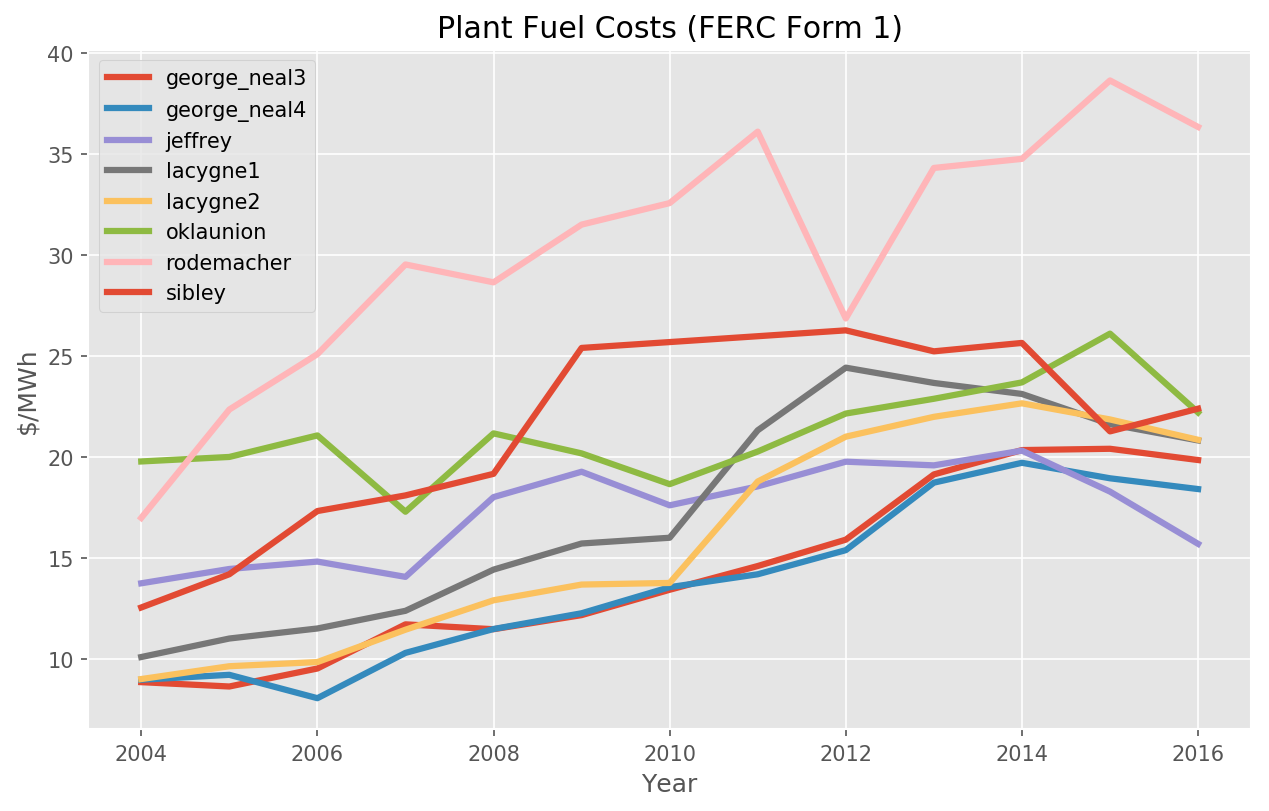

In [21]:
plt.title('Plant Fuel Costs (FERC Form 1)')
plt.ylabel('$/MWh')
plt.xlabel('Year')
for plant in ferc_byplant.reset_index().plant_id_ces.unique().tolist():
    plt.plot(ferc_byplant.loc[plant,'expns_fuel_per_mwh'],
             label=plant, lw=3)
plt.legend(loc='upper left')
plt.savefig('CES_FERC_FuelCosts.png')
plt.show();

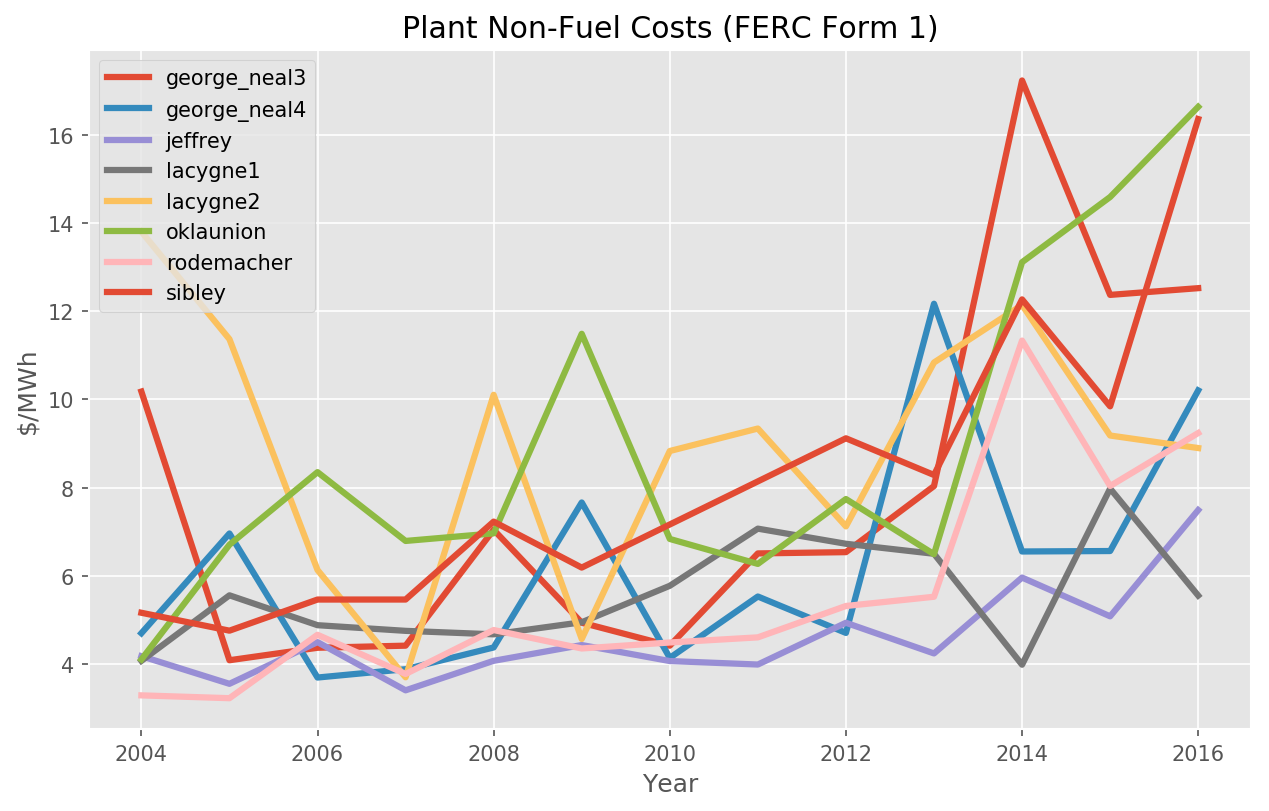

In [22]:
plt.title('Plant Non-Fuel Costs (FERC Form 1)')
plt.ylabel('$/MWh')
plt.xlabel('Year')
for plant in ferc_byplant.reset_index().plant_id_ces.unique().tolist():
    plt.plot(ferc_byplant.loc[plant,'expns_nonfuel_per_mwh'], label=plant, lw=3)
plt.legend(loc='upper left')
plt.savefig('CES_FERC_NonFuelCosts.png')
plt.show();

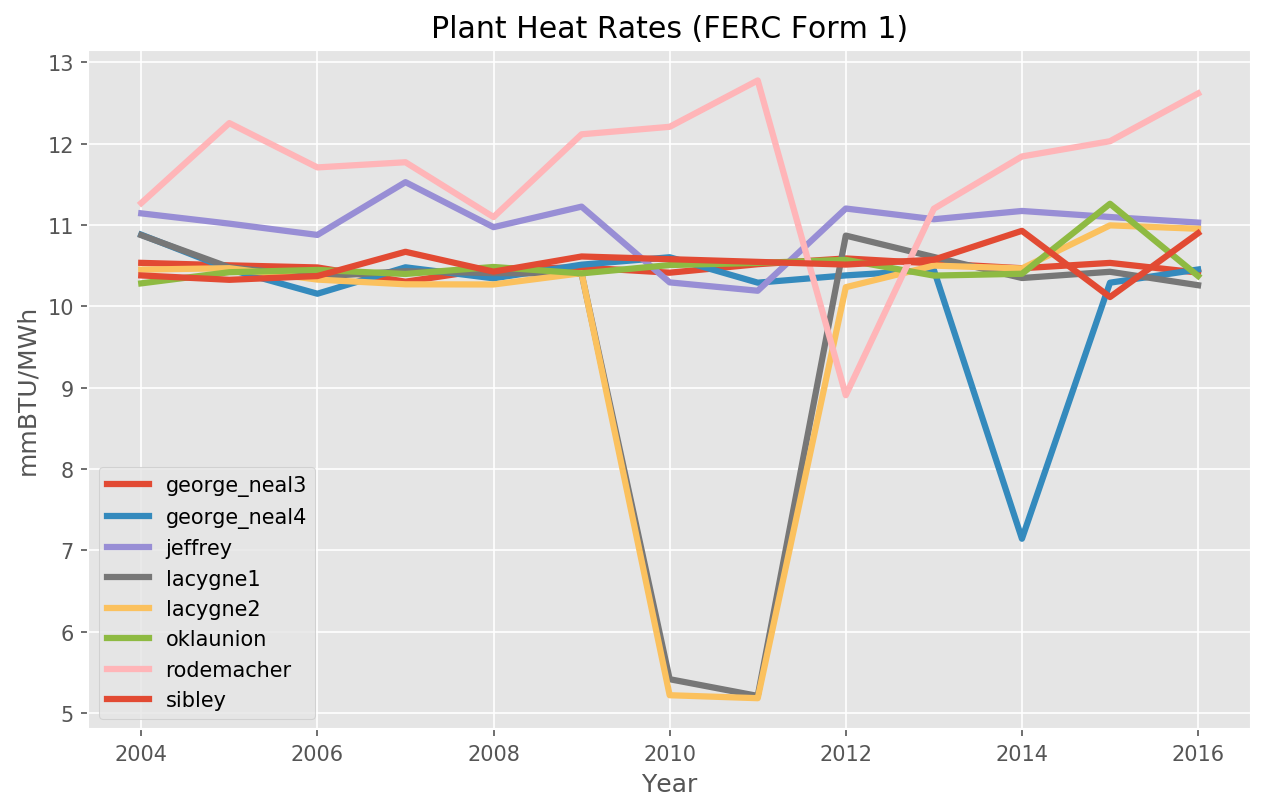

In [23]:
plt.title('Plant Heat Rates (FERC Form 1)')
plt.ylabel('mmBTU/MWh')
plt.xlabel('Year')
for plant in ferc_byplant.reset_index().plant_id_ces.unique().tolist():
    plt.plot(ferc_byplant.loc[plant,'heat_rate_mmbtu_mwh'], label=plant, lw=3)
plt.legend(loc='lower left')
plt.savefig('CES_FERC_HeatRates.png')
plt.show();

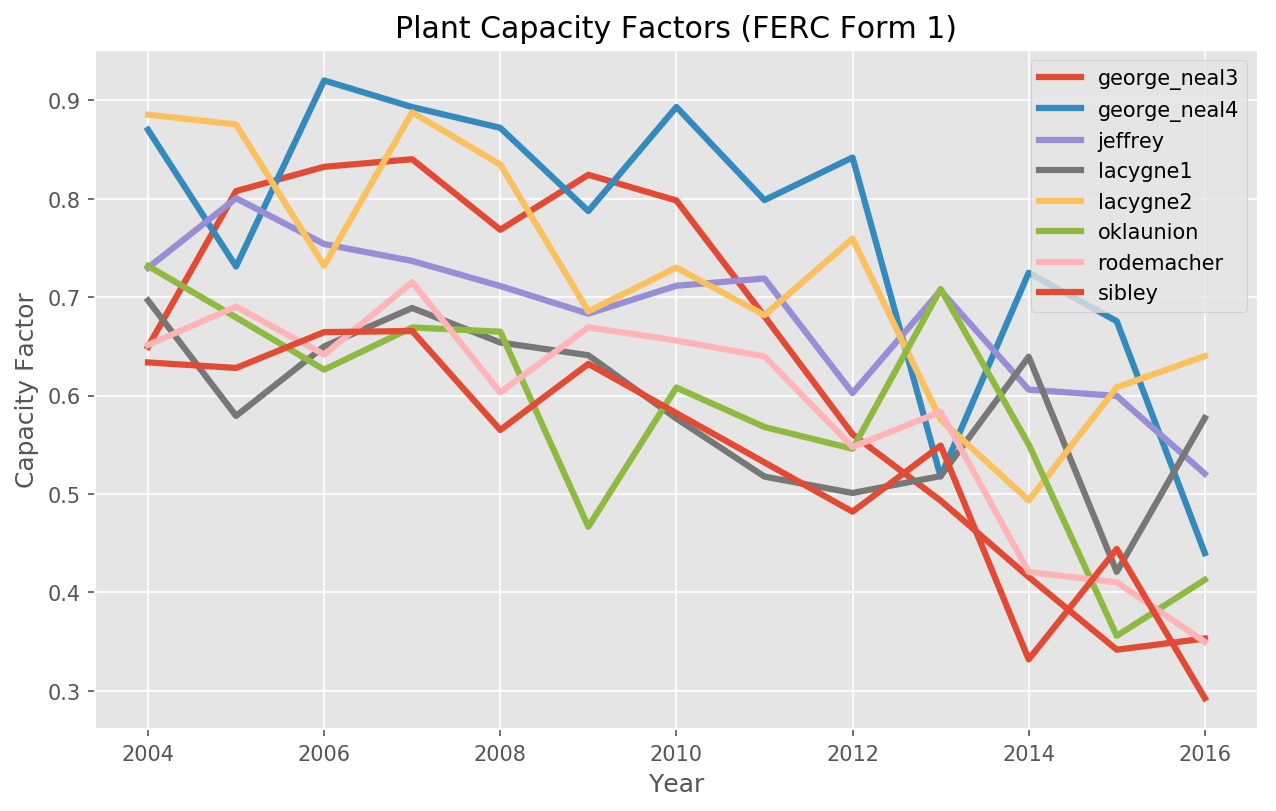

In [24]:
plt.title('Plant Capacity Factors (FERC Form 1)')
plt.ylabel('Capacity Factor')
plt.xlabel('Year')
for plant in ferc_byplant.reset_index().plant_id_ces.unique().tolist():
    plt.plot(ferc_byplant.loc[plant,'capacity_factor'], label=plant, lw=3)
plt.legend(loc='upper right')
plt.savefig('CES_FERC_CapFac.png')
plt.show();

## Combining FERC & EIA Summary Outputs
Now that we've got per-plant numbers from FERC, and the per-generator information from EIA, we can (try to) bring them together in a summary output table, while keeping the messy details in their respective origin tables.

The several cases we need to deal with:
* We can have either or both of EIA & FERC data, depending on plant and year.
* If we have FERC data, it'll be at the plant level.
* We may have generator level data from EIA (for Jeffrey & Sibley).

We need to merge the plant level data in with the EIA data, which means several EIA generators may get the same plant level FERC data.  But then we need to be able to output the combination of generator level EIA data and plant-level FERC data.

We can't *just* merge the FERC data with the EIA data, and then work with the EIA IDs, because there are some cases in which we have some FERC plants and a bunch of FERC years in which the data doesn't exist in EIA.

ID Columns to Compile:
* Plant ID
* Report Year

Data Columns to compile:
* Fuel Cost ($/MWh; FERC, EIA)
* Non-Fuel Cost ($/MWh; FERC)
* Heat Rate (mmBTU/MWh; FERC, EIA)
* Capacity Factor (FERC, EIA)

But what does "plant id" really mean here.  We have

In [25]:
ferc_summed_byplant = ferc_byplant.reset_index()

In [34]:
eia_simple_cols = [
    'report_year',
    'plant_name_ces',
    'plant_id_ces',
    'nameplate_capacity_mw',
    'net_generation_mwh',
    'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh']
eia_simple_byplant = eia_out[eia_simple_cols].reset_index()
ces_simple = pd.merge(ferc_summed_byplant, eia_simple_byplant,
                      on=('plant_id_ces', 'report_year'),
                      suffixes=('_ferc', '_eia'), how='outer')
# Try to fix the jeffrey & sibley duplicity...
j_ok = ((ces_simple.plant_id_ces=='jeffrey') &
        (~ces_simple.plant_name_ces.isnull()))
ces_simple.loc[j_ok, 'plant_id_ces'] = ces_simple.loc[j_ok,'plant_name_ces']

sib_ok = ((ces_simple.plant_id_ces=='sibley') &
          (~ces_simple.plant_name_ces.isnull()))
ces_simple.loc[sib_ok, 'plant_id_ces'] = ces_simple.loc[sib_ok,'plant_name_ces']

ces_simple = ces_simple.set_index(['plant_id_ces','report_year'])

## Christina: Look at ces_simple. This is the DF where the time series aren't matching up.

In [51]:
byplant_cols = [
    #'plant_id_ces',
    #'report_year',
    #'plant_name_ces',
    'nameplate_capacity_mw_eia',
    'nameplate_capacity_mw_ferc',
    
    #'net_generation_mwh_eia',
    #'net_generation_mwh_ferc',
    
    'capacity_factor_ferc',
    'capacity_factor_eia',
    
    #'expns_nonfuel',
    #'expns_fuel',
    #'total_mmbtu_ferc',
    #'total_mmbtu_eia',
    'expns_nonfuel_per_mwh',
    
    'expns_fuel_per_mwh',
    'fuel_cost_per_mwh',
    
    'heat_rate_mmbtu_mwh_ferc',
    'heat_rate_mmbtu_mwh_eia',
]
ces_byplant = ces_simple[byplant_cols].copy()
ces_byplant['total_cost_per_mwh'] = \
    ces_byplant.fuel_cost_per_mwh + \
    ces_byplant.expns_nonfuel_per_mwh

In [52]:
def plot_ferc_eia(byplant_df, cols, labels, lws,
                  title='', ylabel='',
                  savefig=False):
    for plant in byplant_df.index.levels[0]:
        plt.title('{} for {}'.format(title, plant))
        for col, label, lw in zip(cols, labels, lws):
            plt.plot(ces_byplant.loc[plant][col], label=label, lw=lw)
        plt.ylabel(ylabel)
        plt.xlabel('Year')
        plt.xlim((2003, 2017))
        plt.legend()
        plt.show();

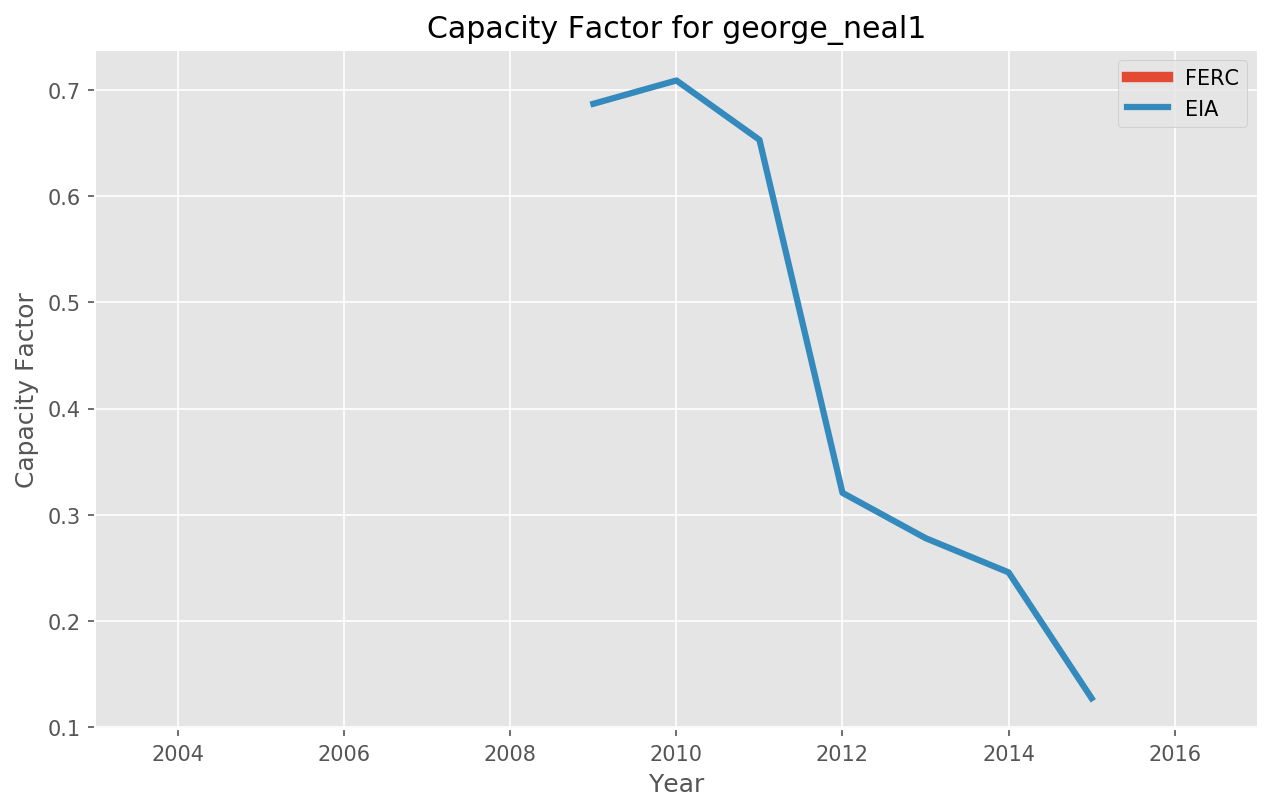

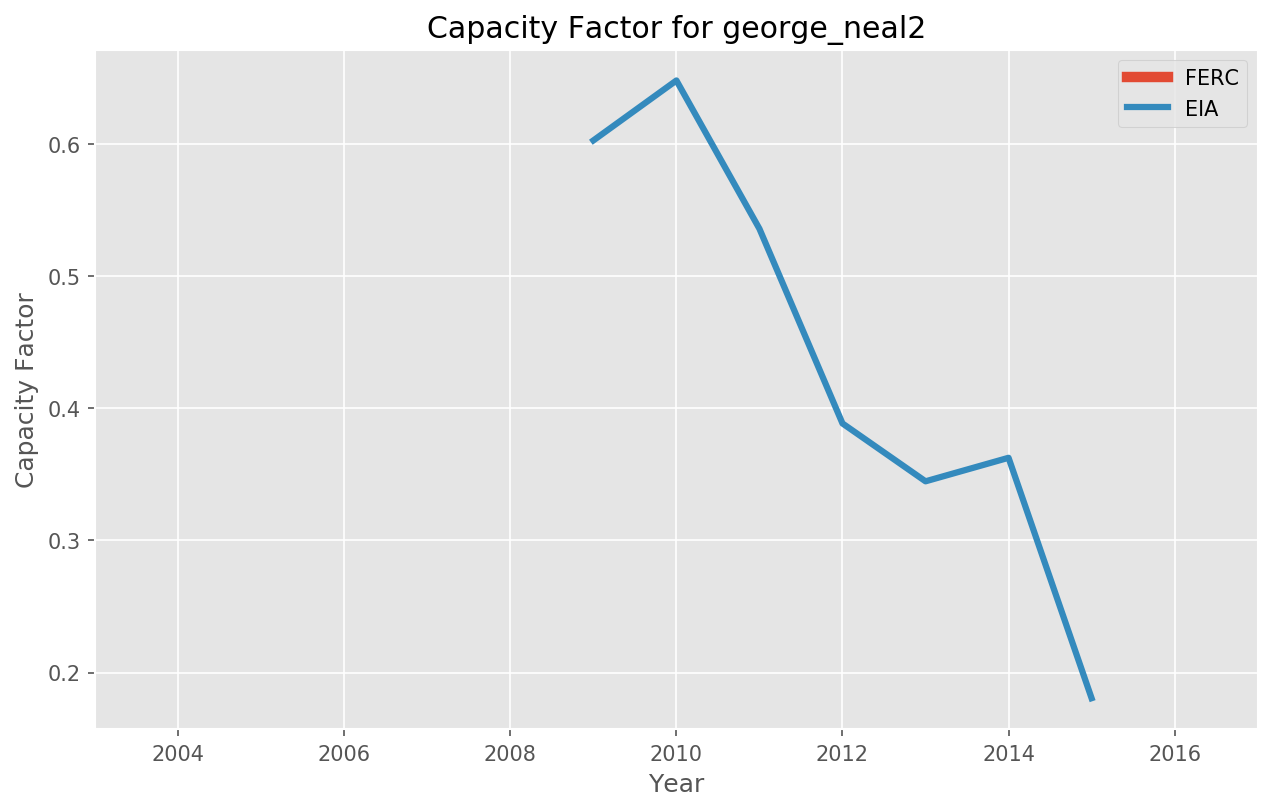

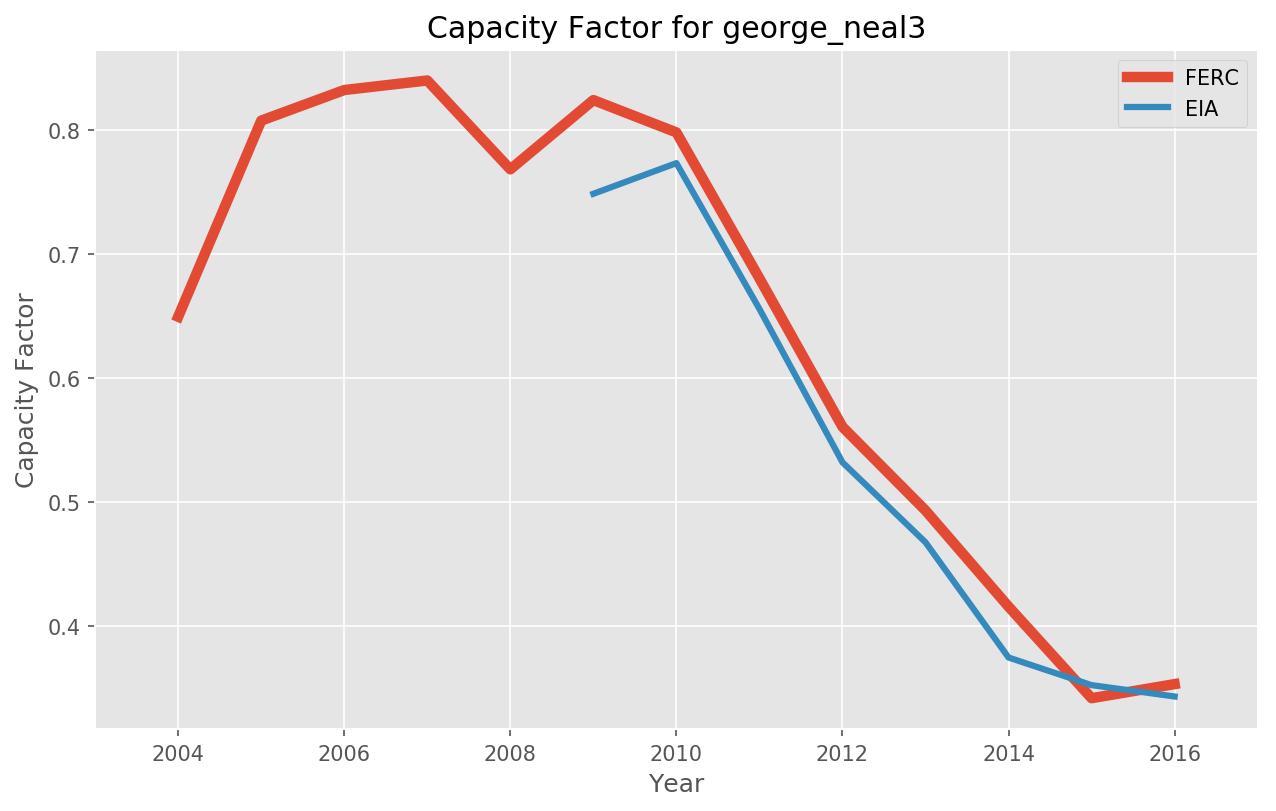

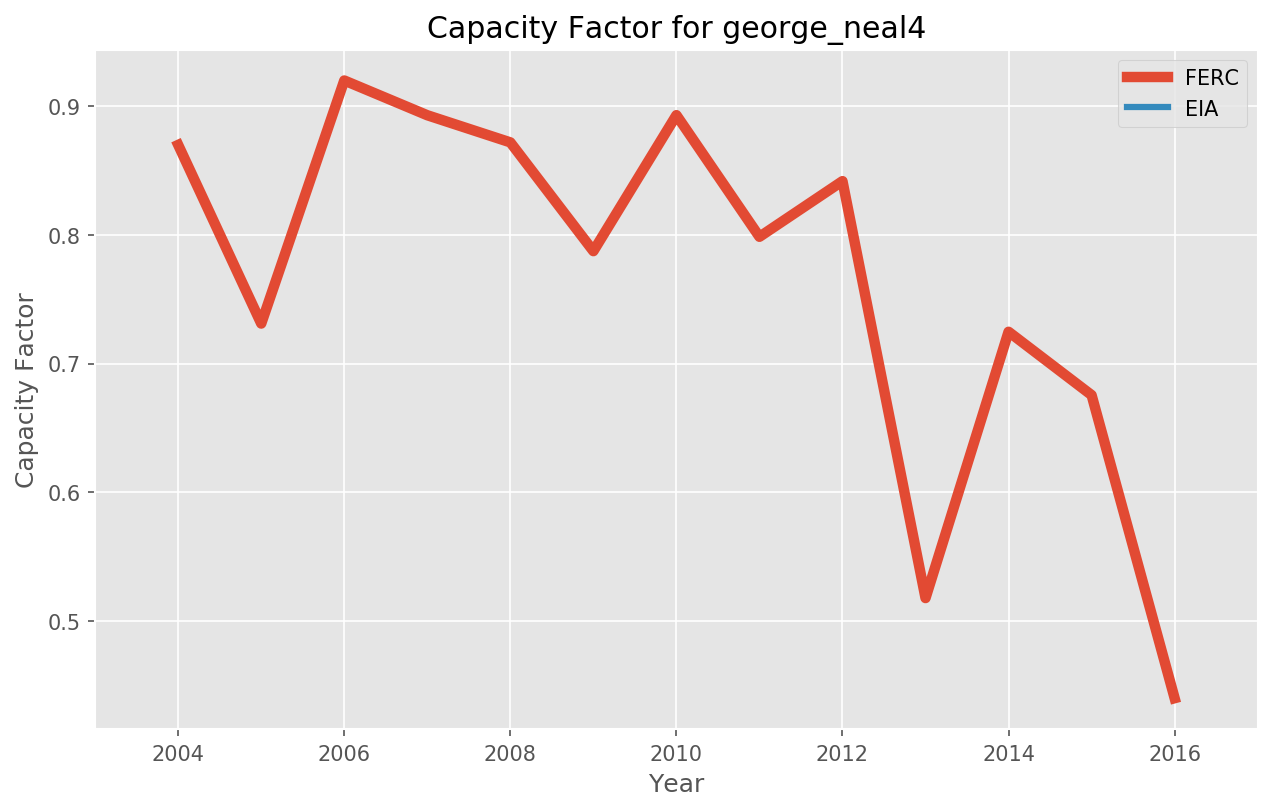

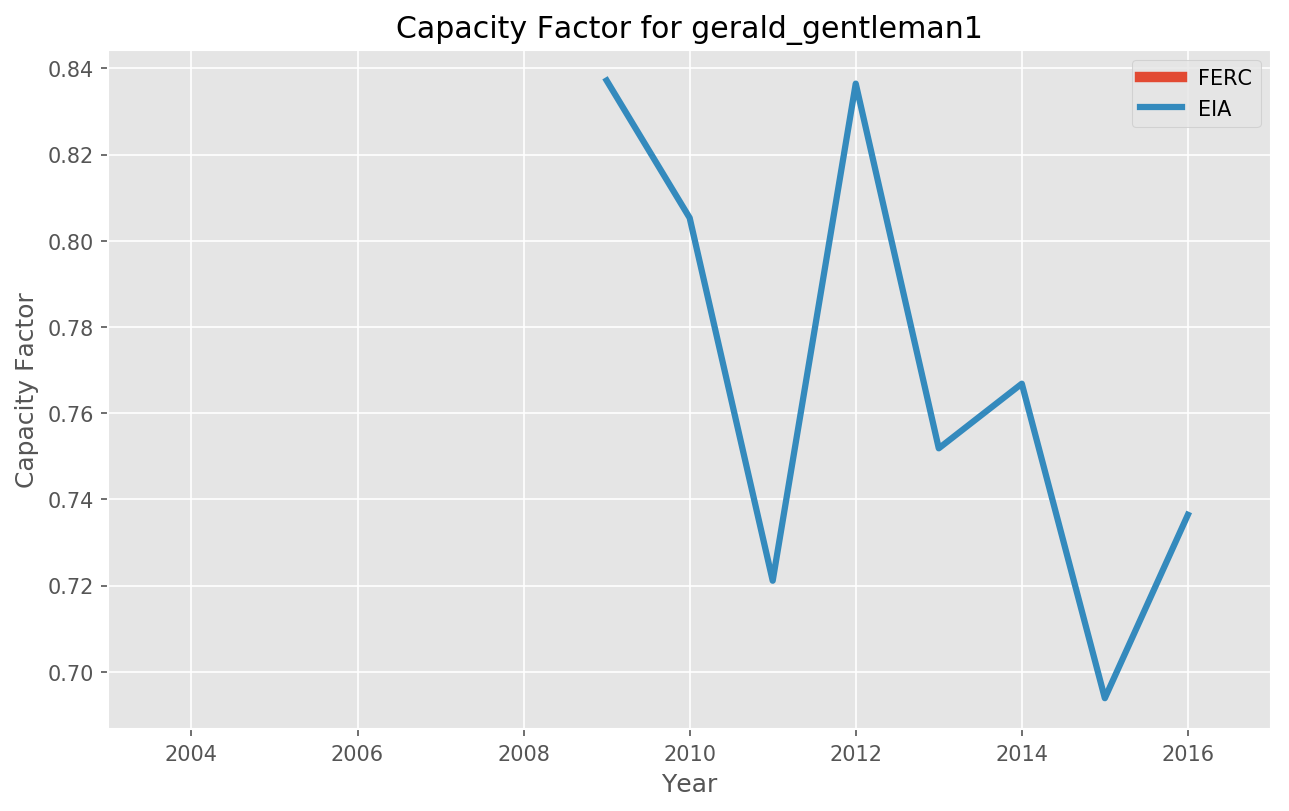

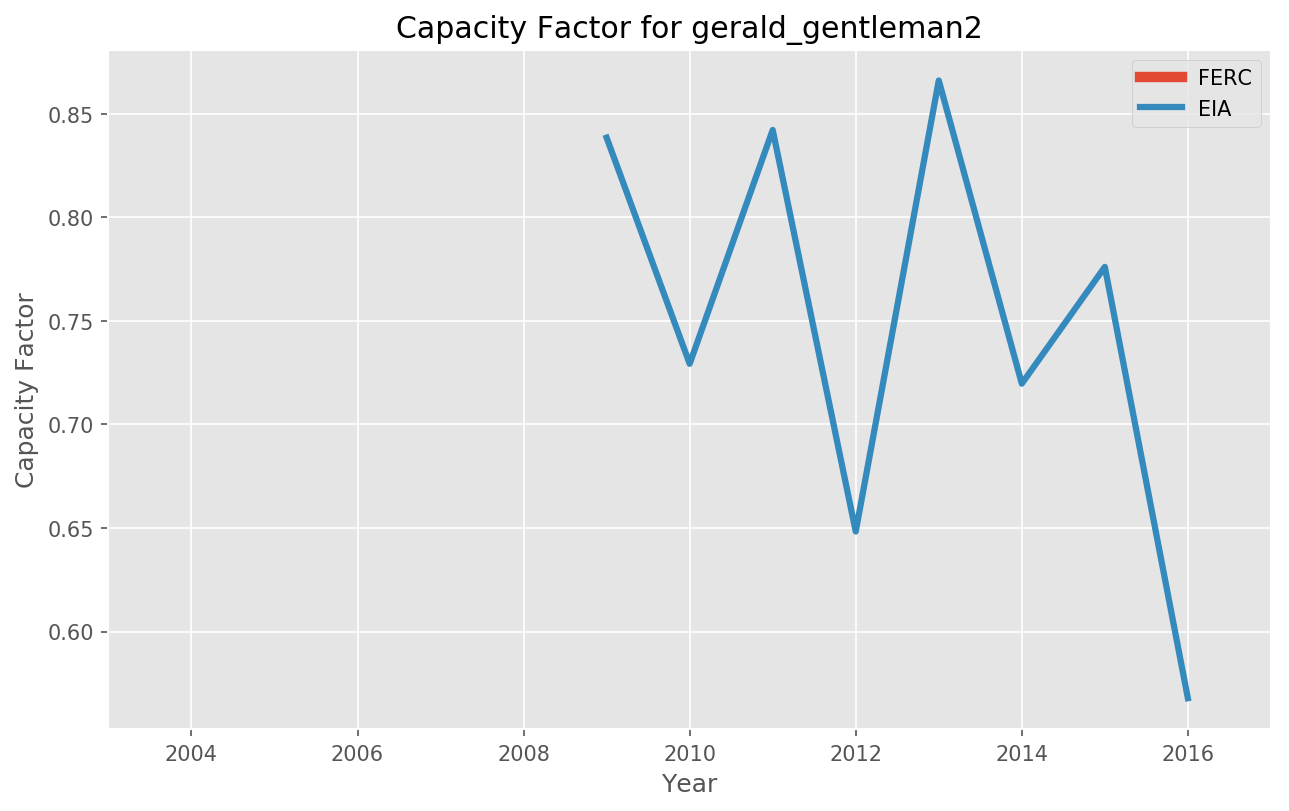

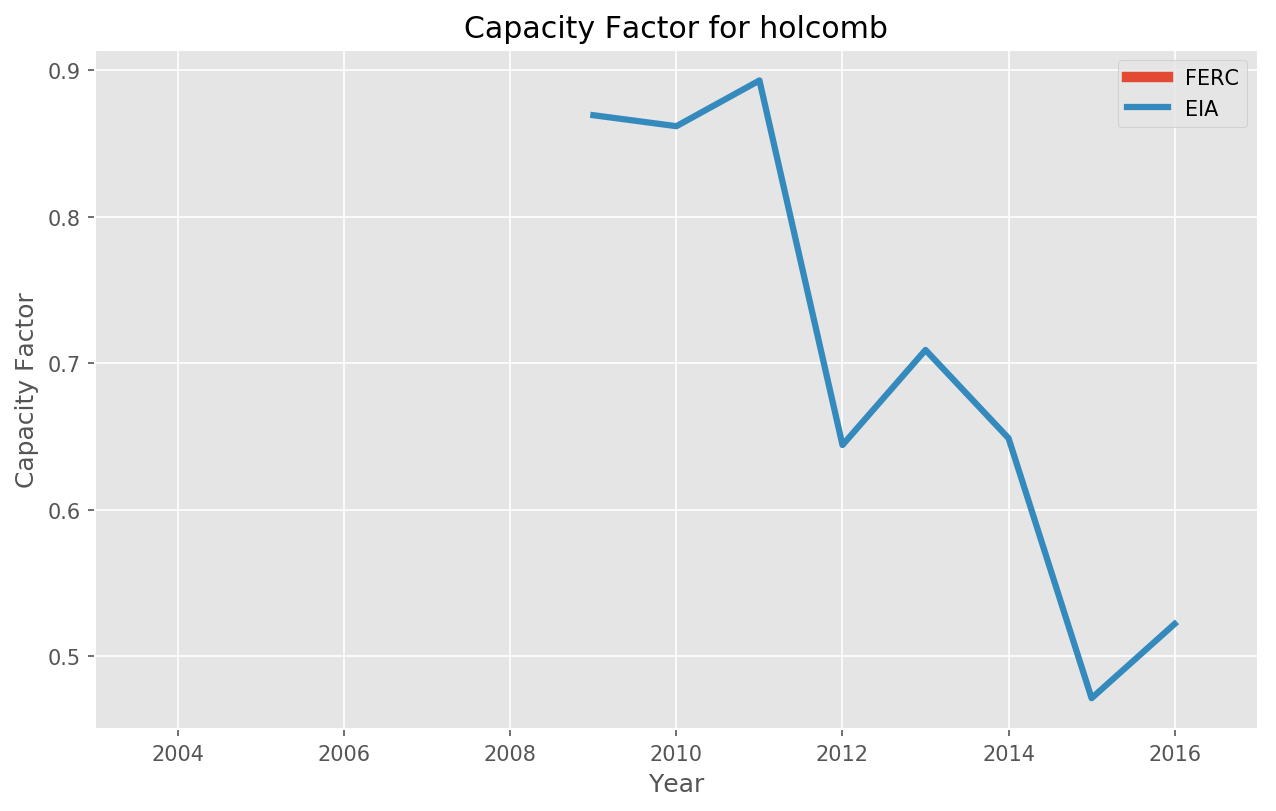

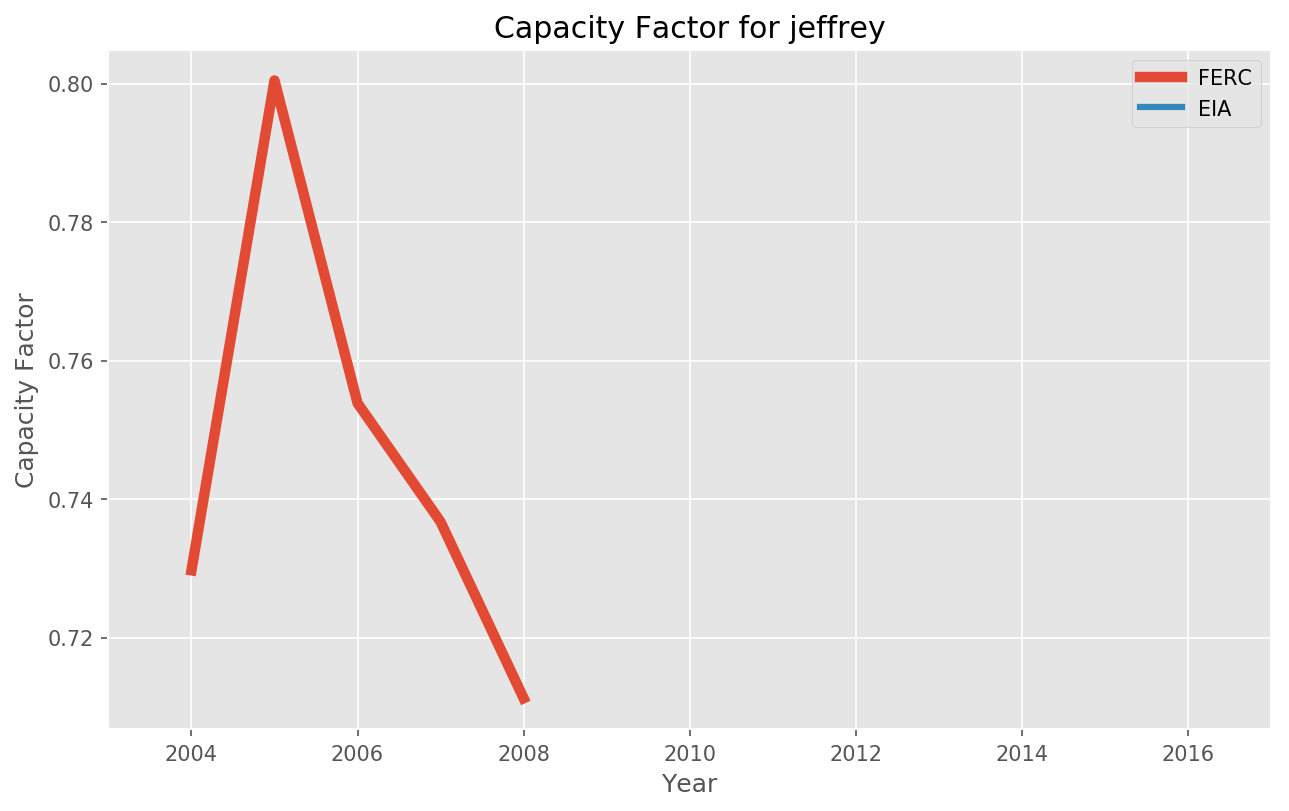

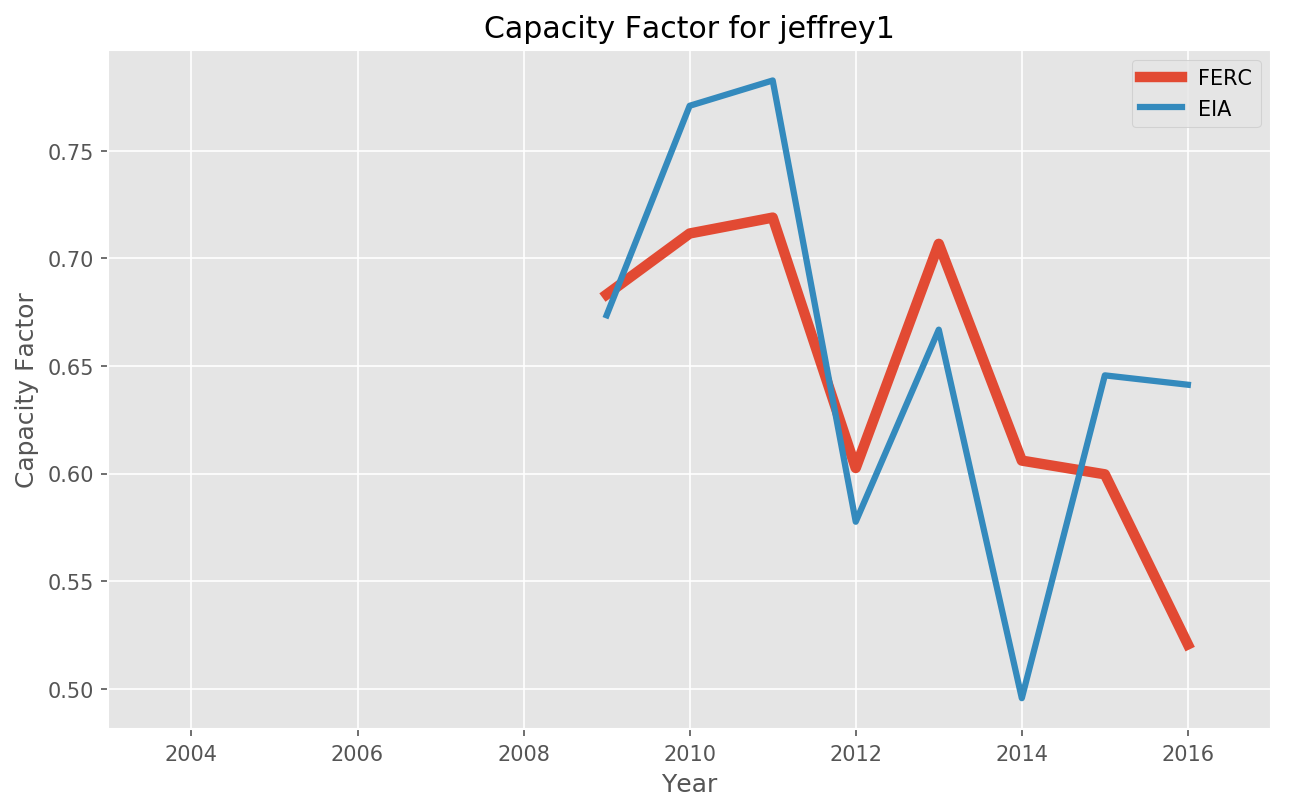

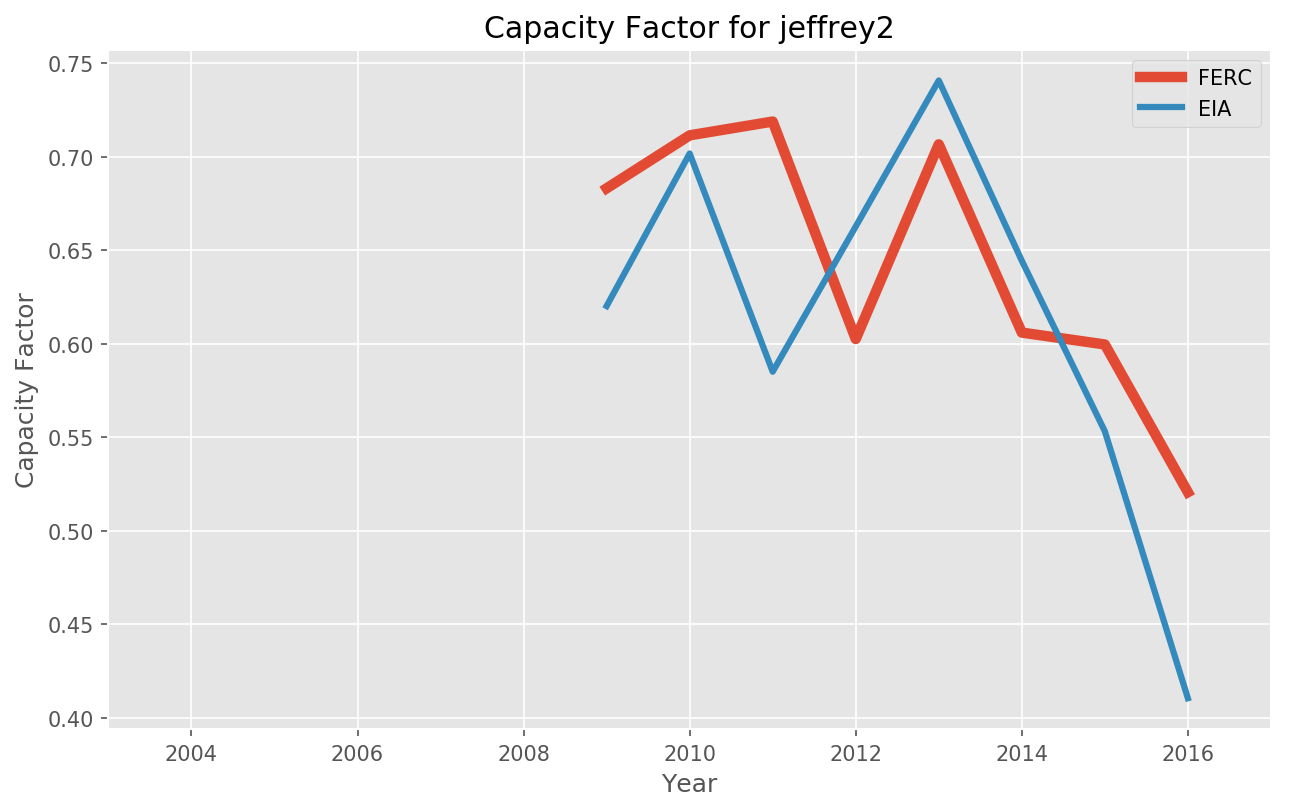

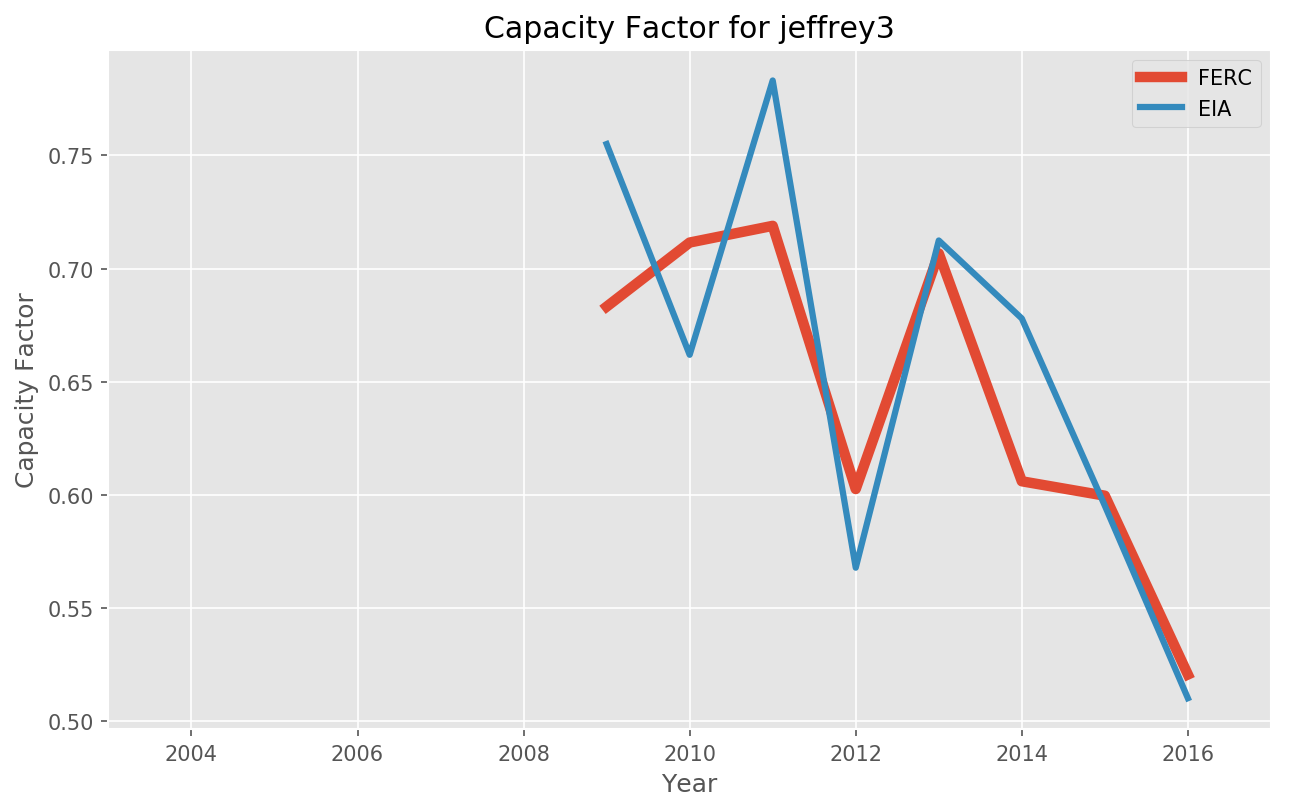

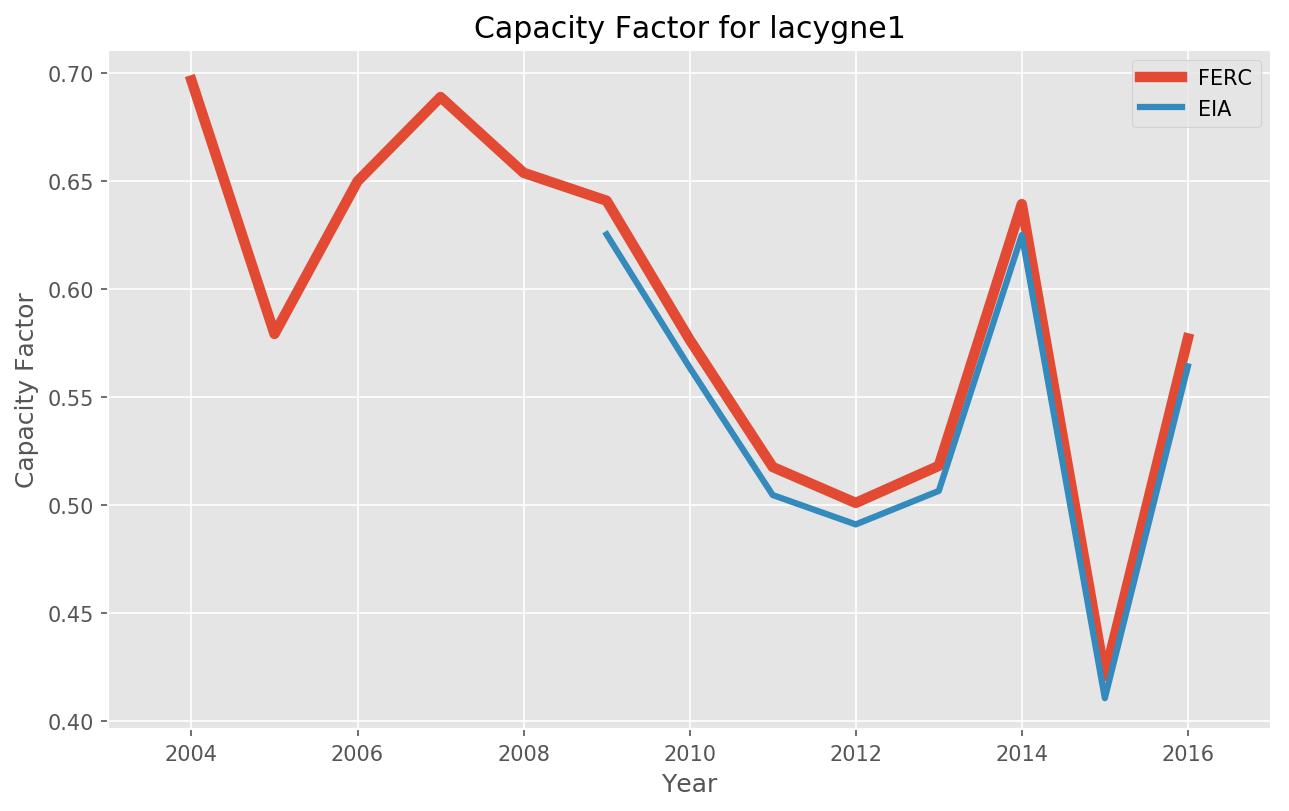

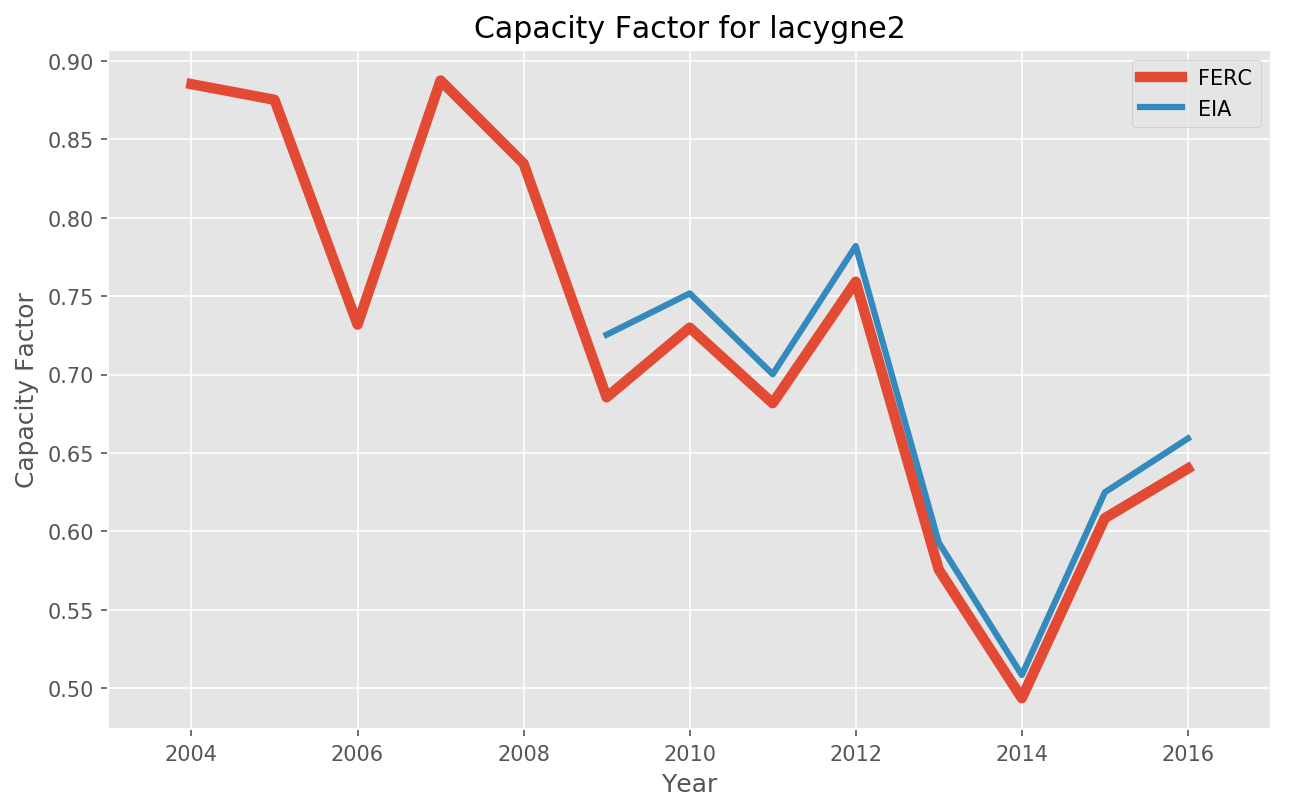

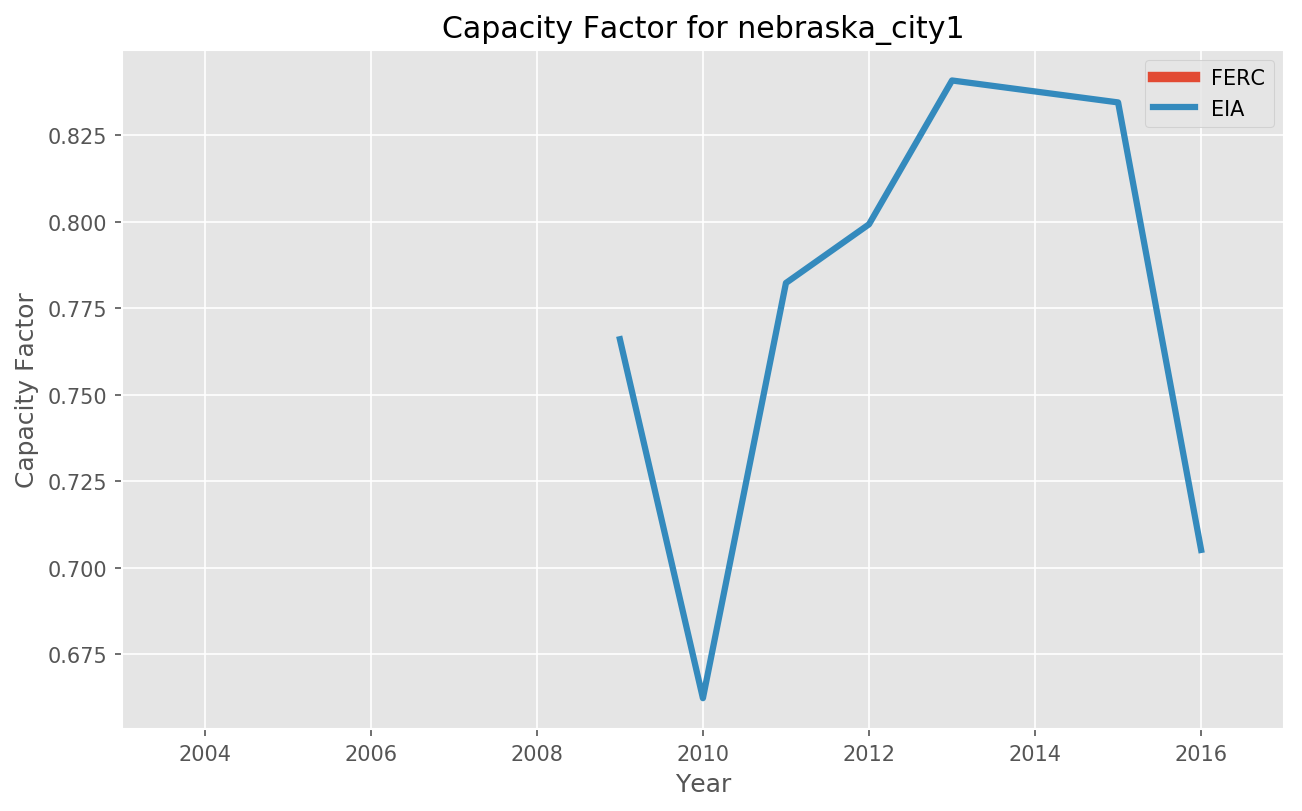

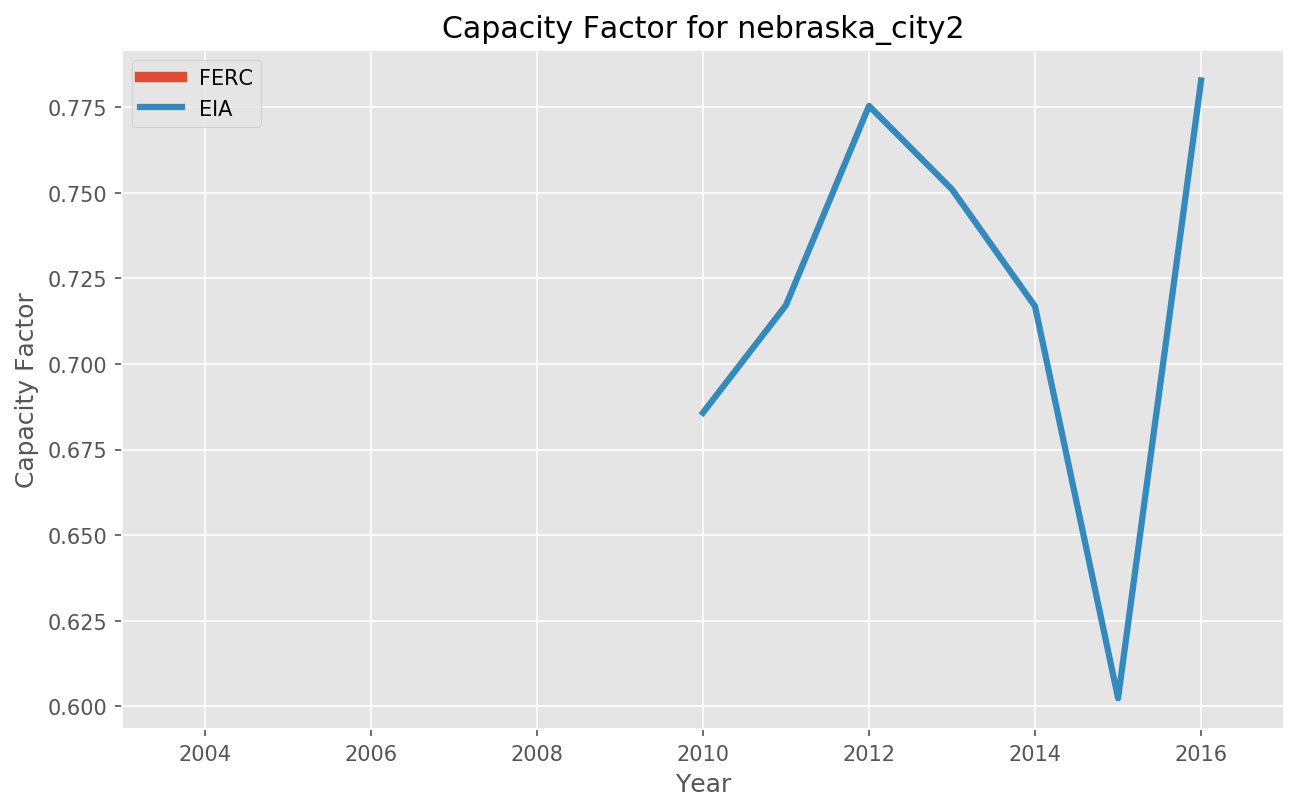

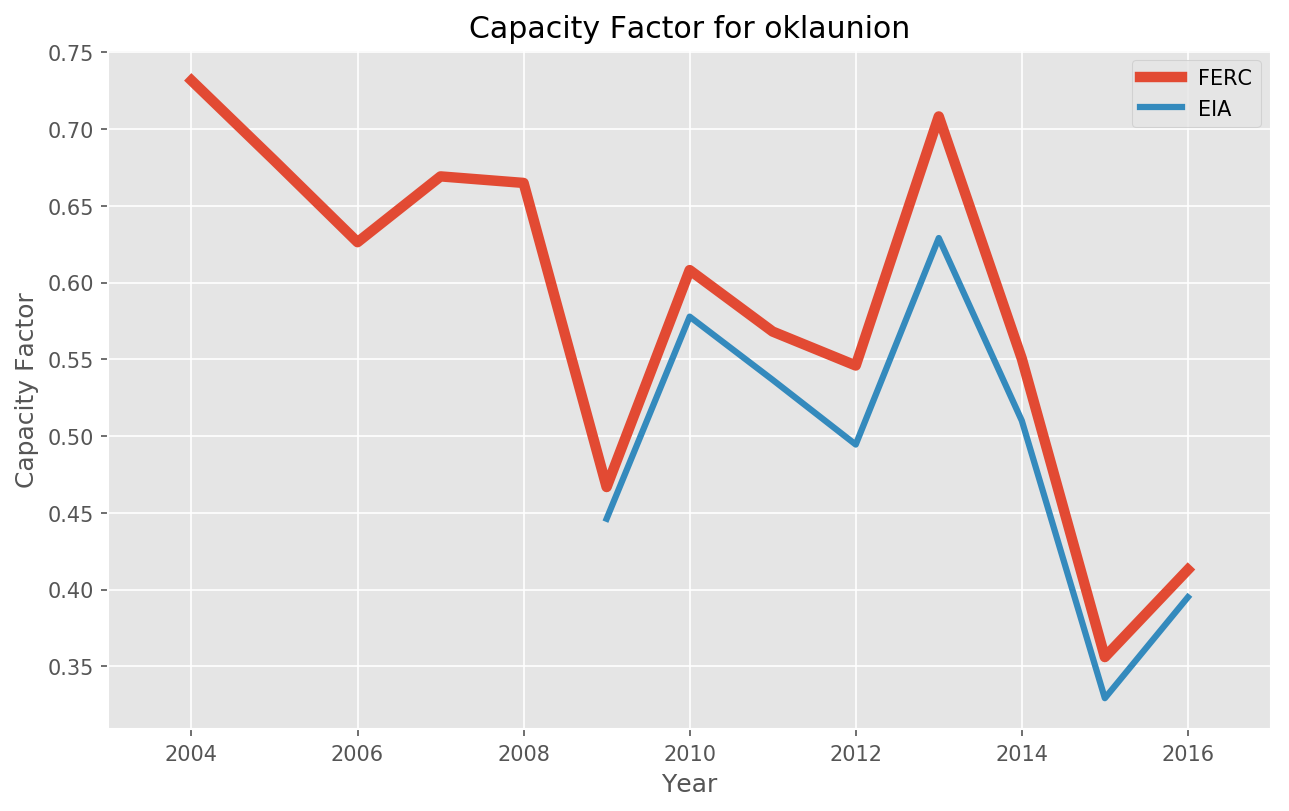

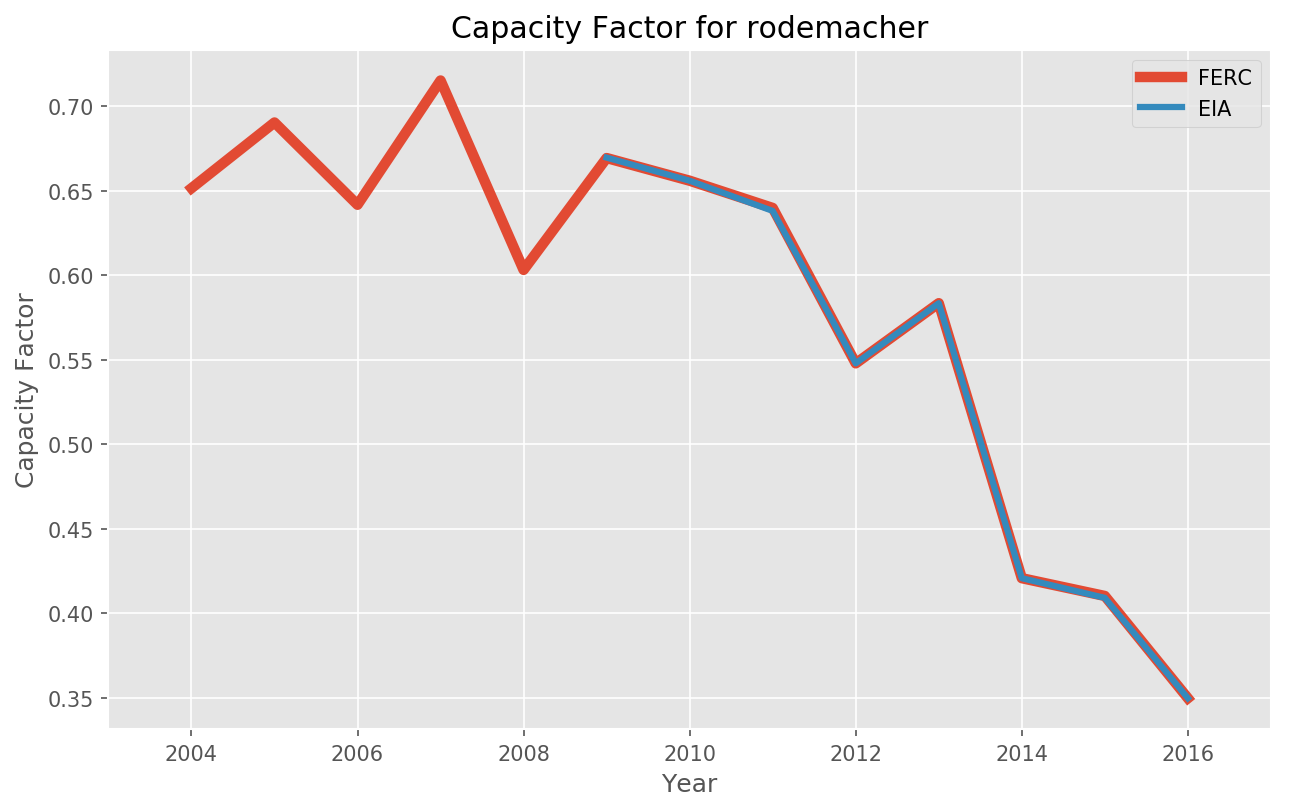

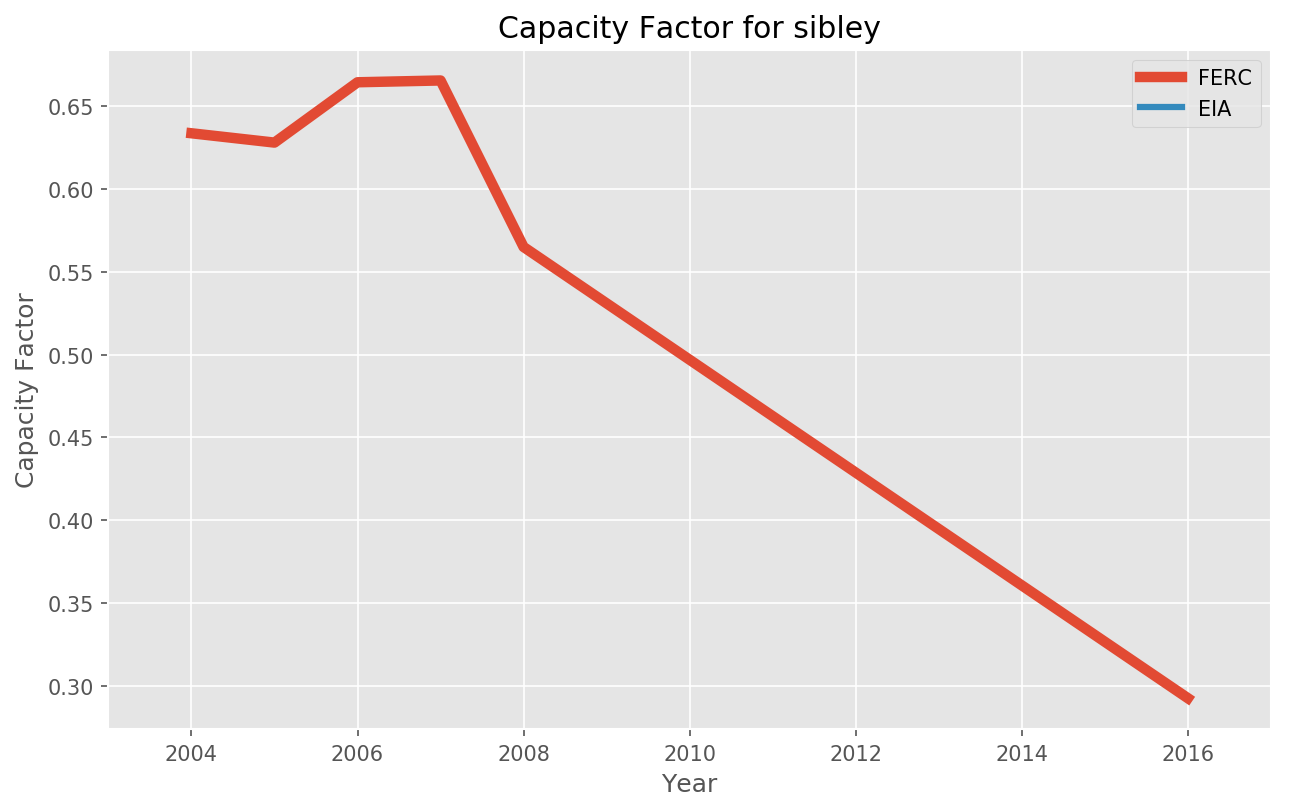

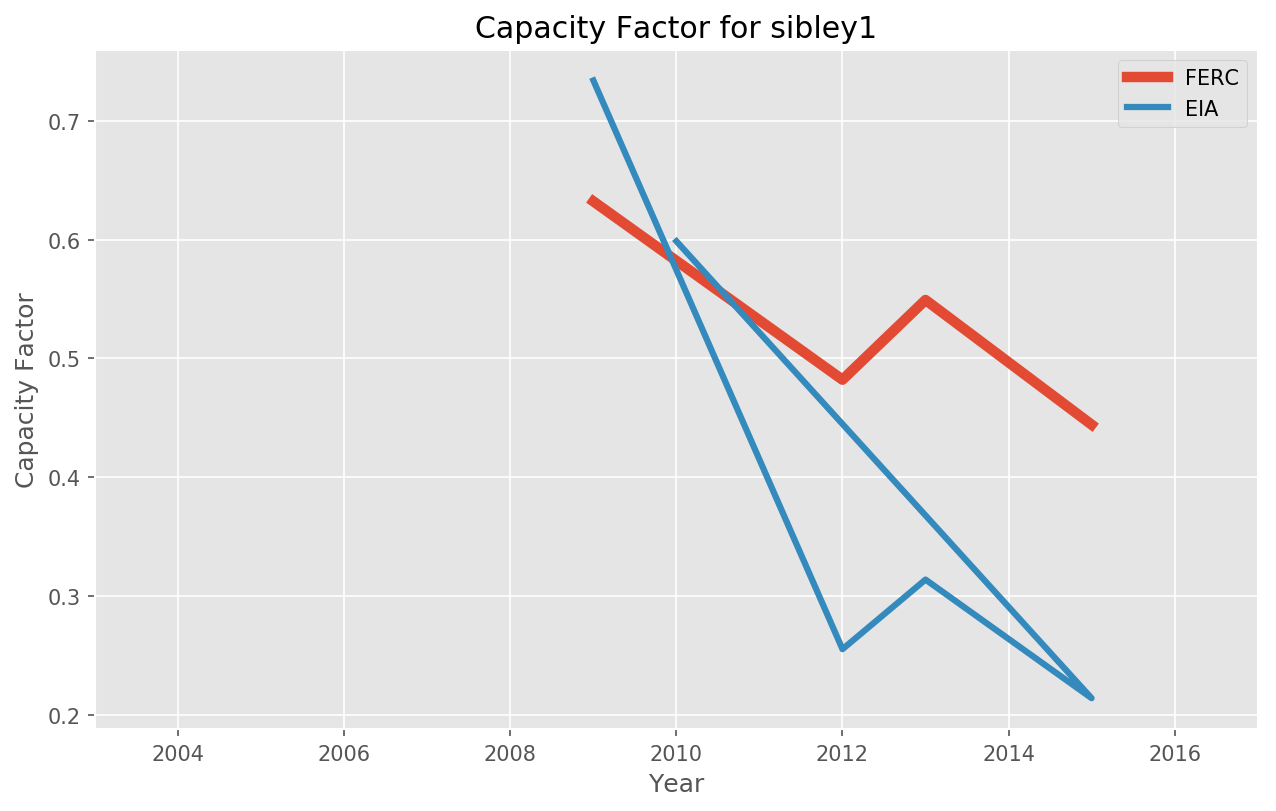

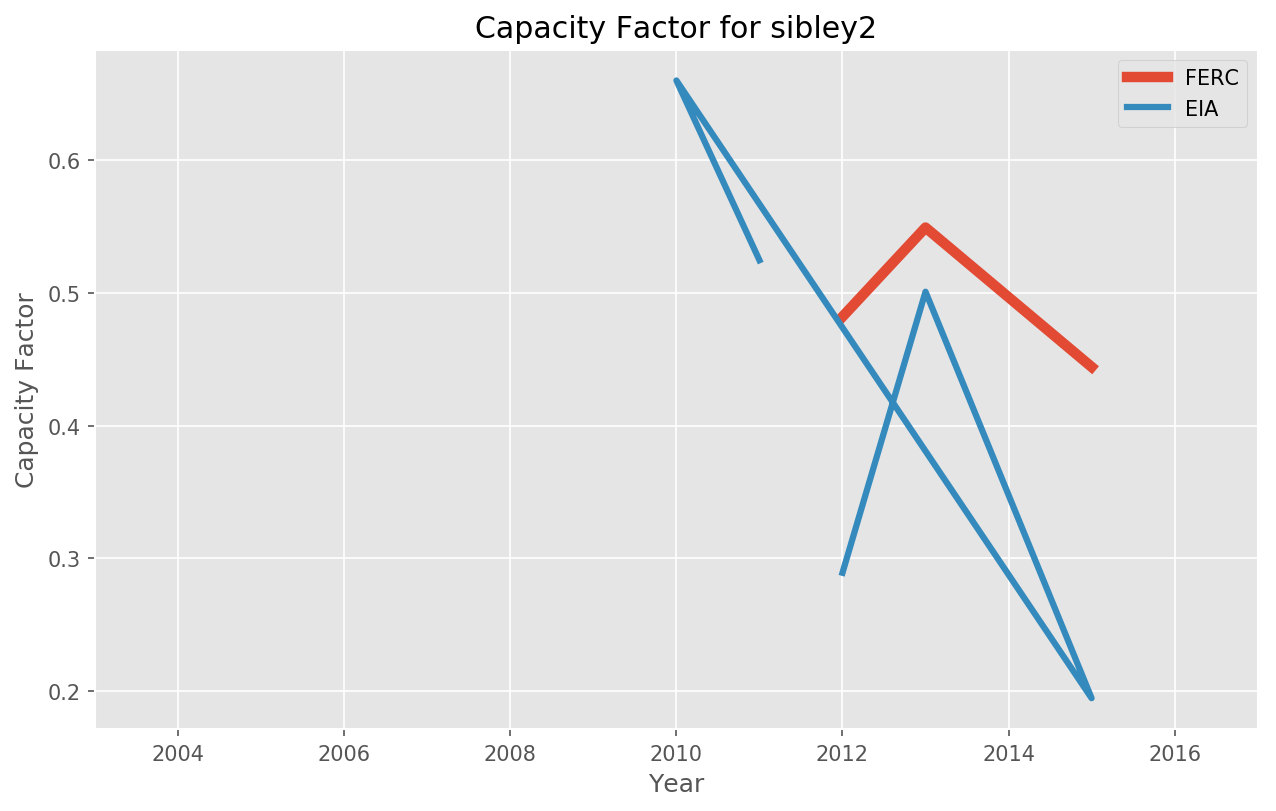

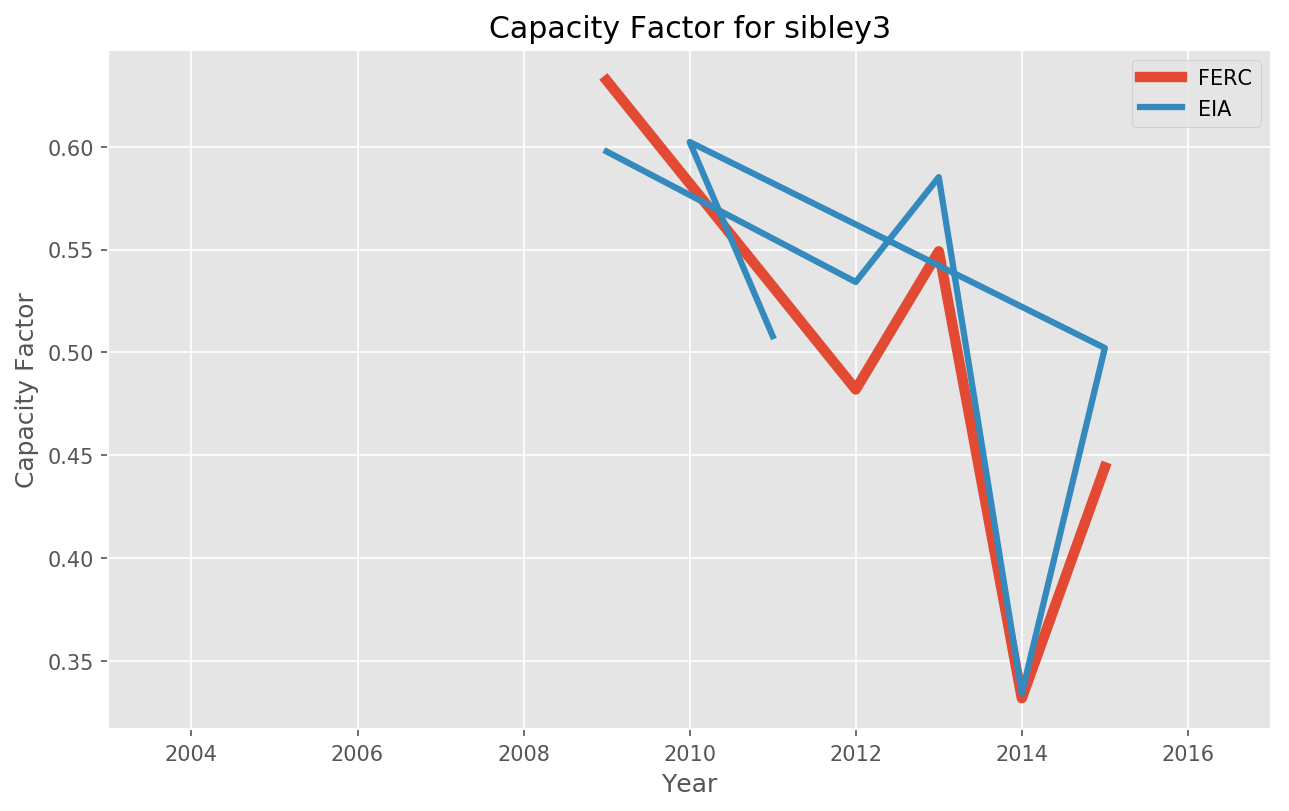

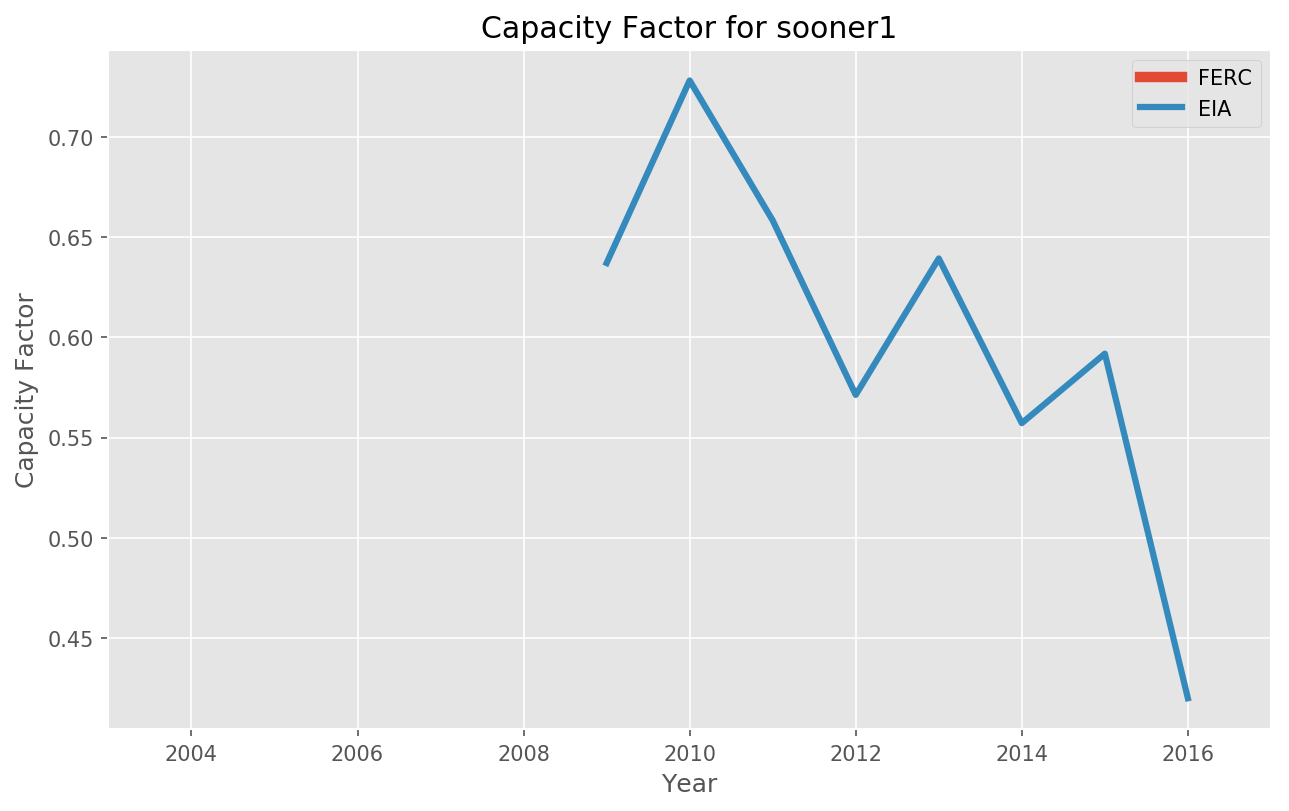

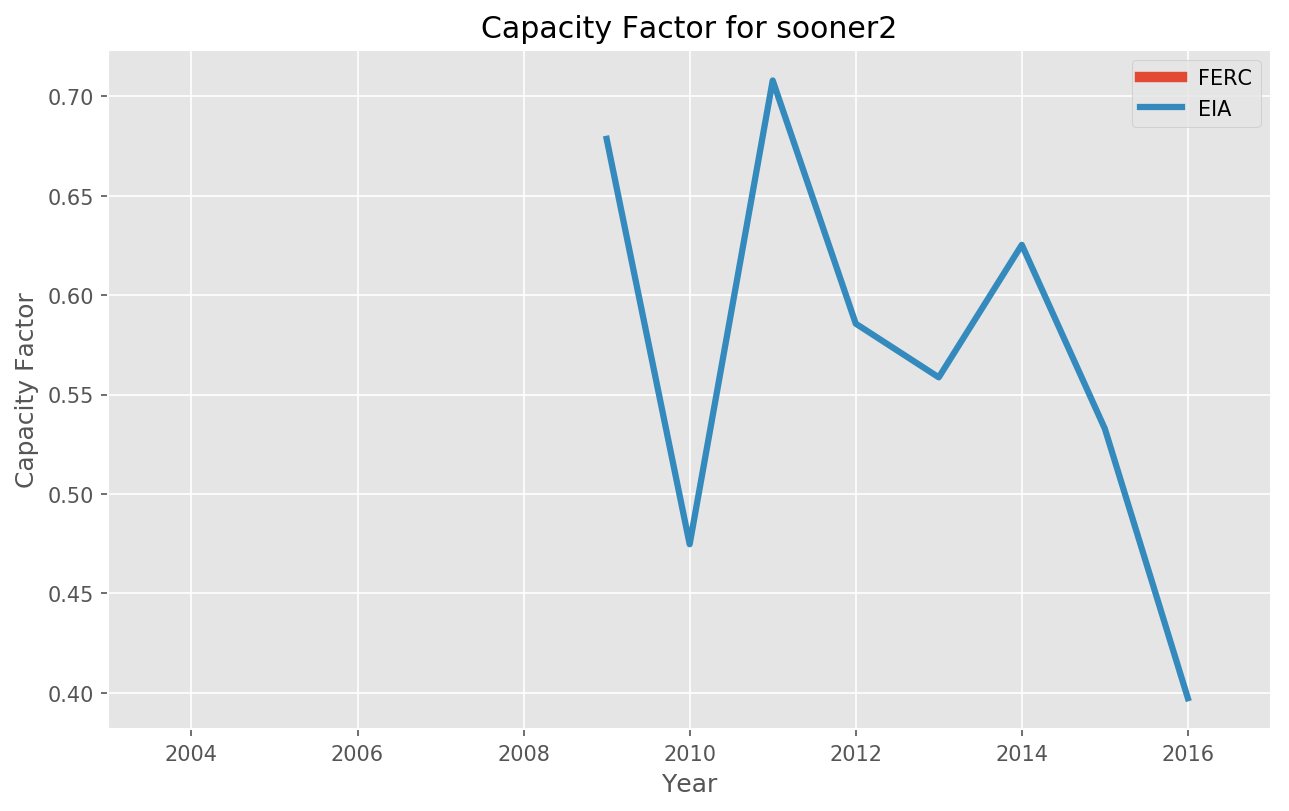

In [53]:
plot_ferc_eia(ces_byplant,
              cols = ['capacity_factor_ferc', 'capacity_factor_eia'],
              labels = ['FERC', 'EIA'], lws = [5,3],
              title='Capacity Factor', ylabel='Capacity Factor')

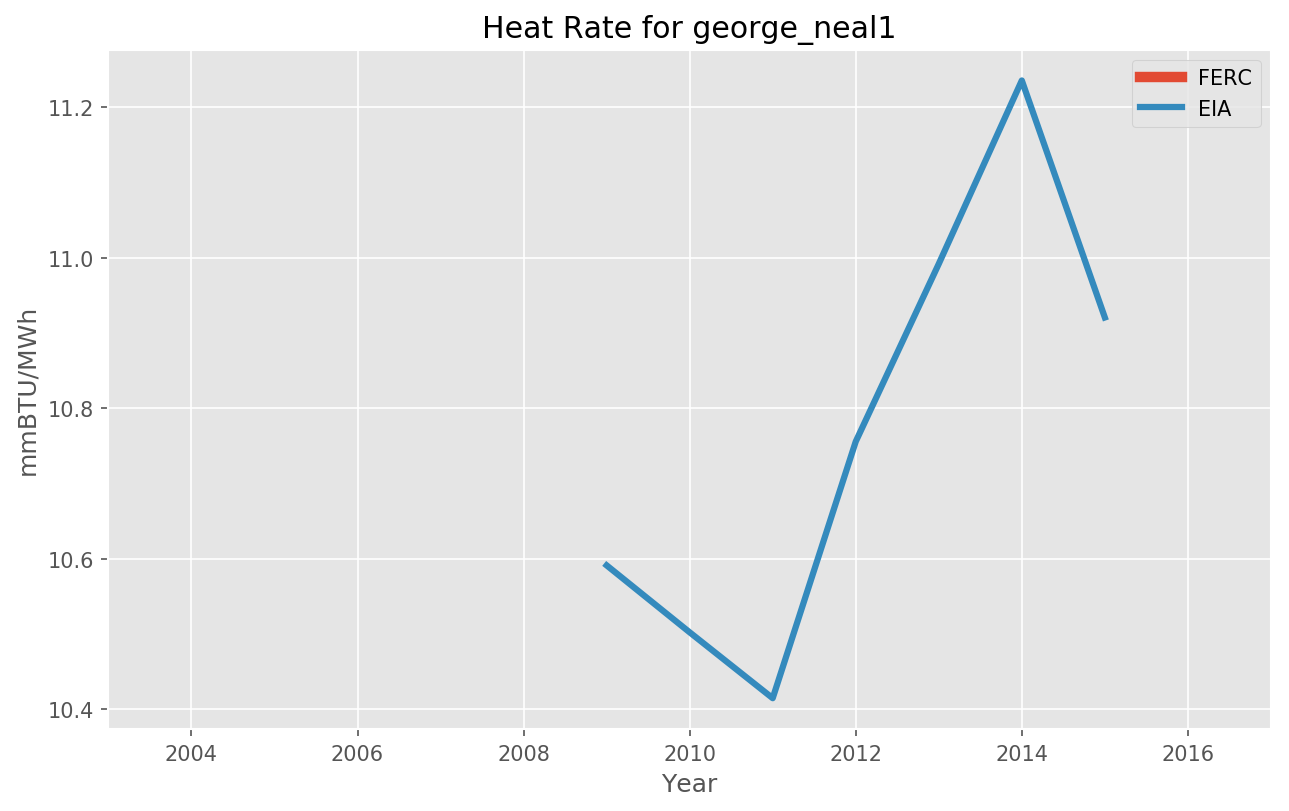

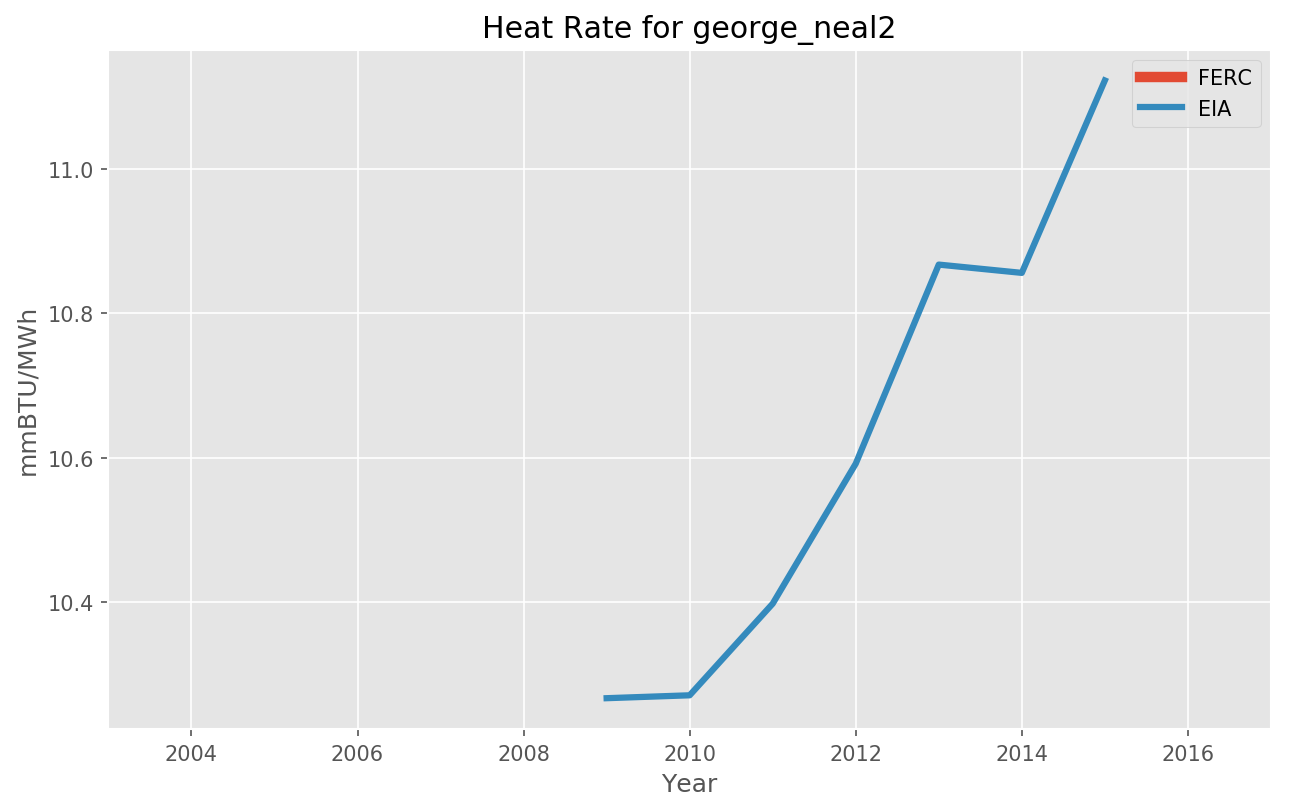

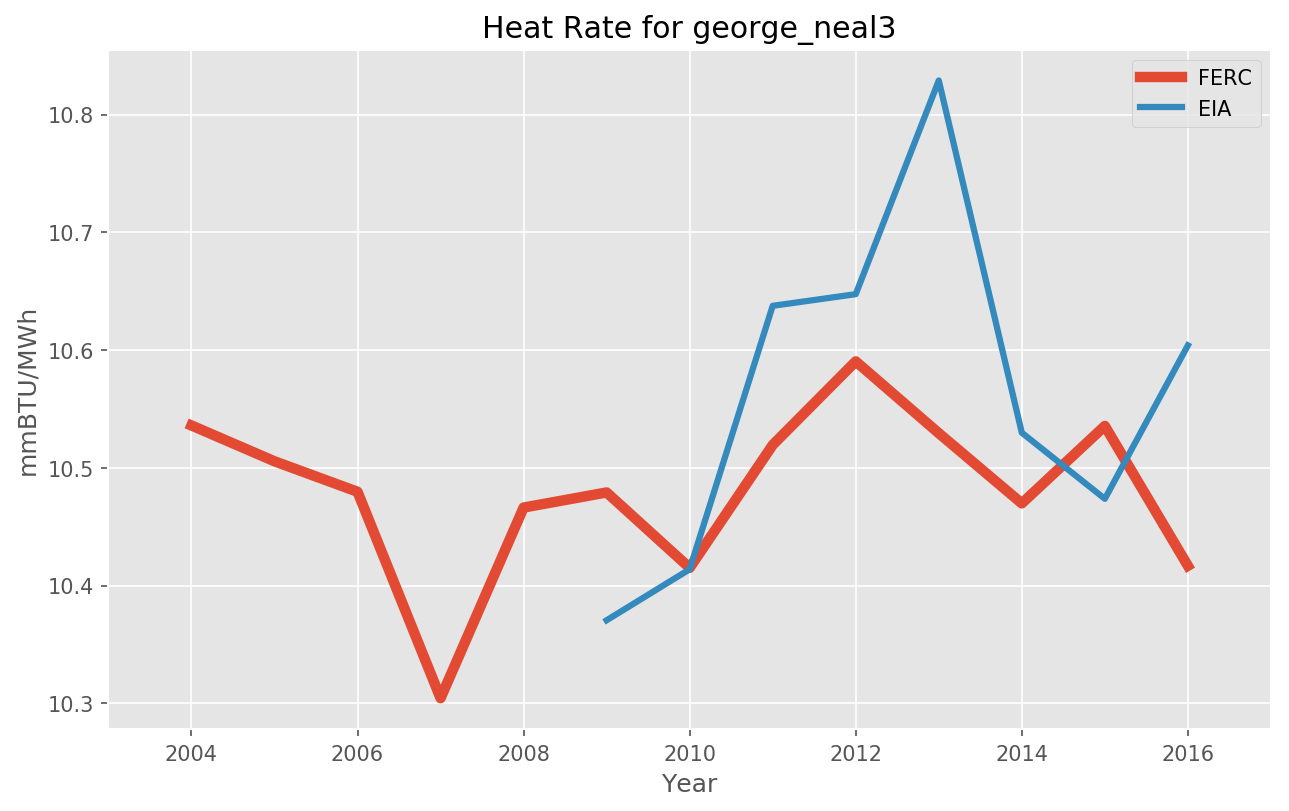

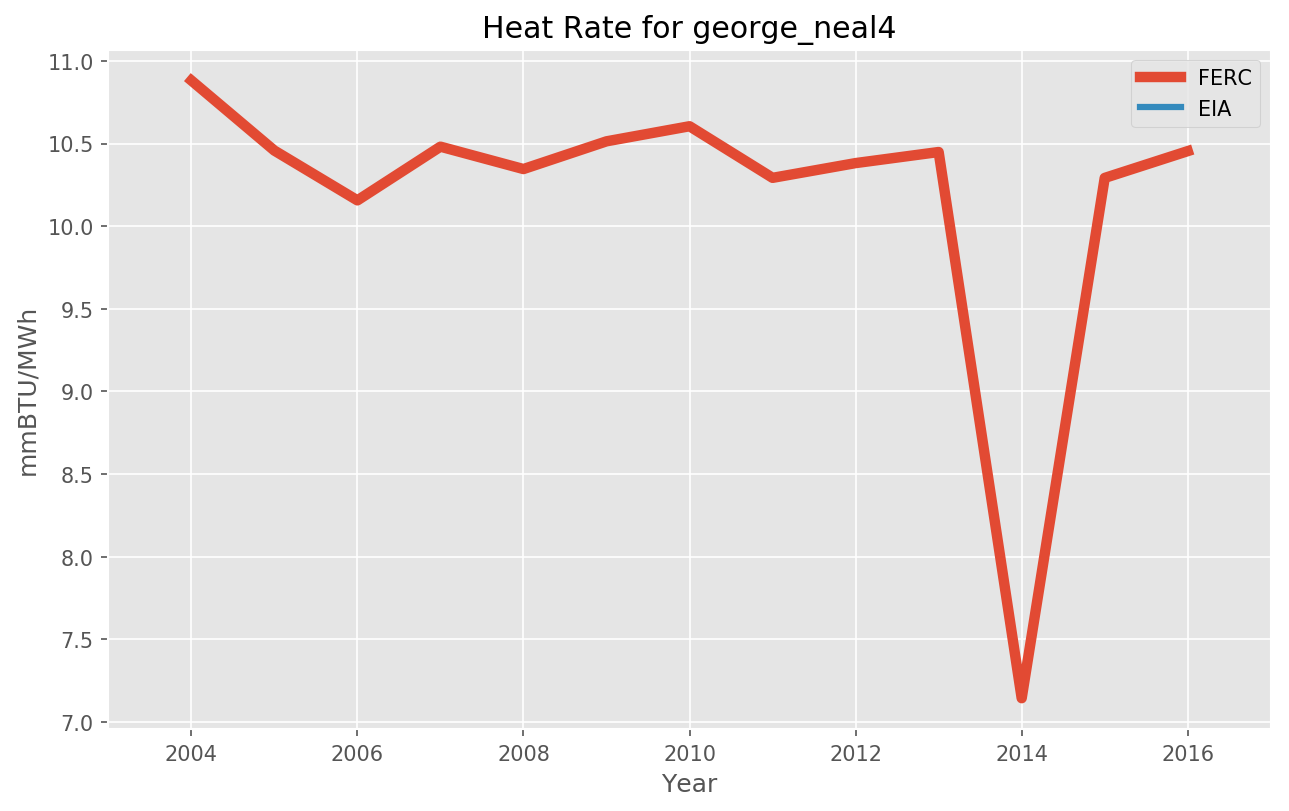

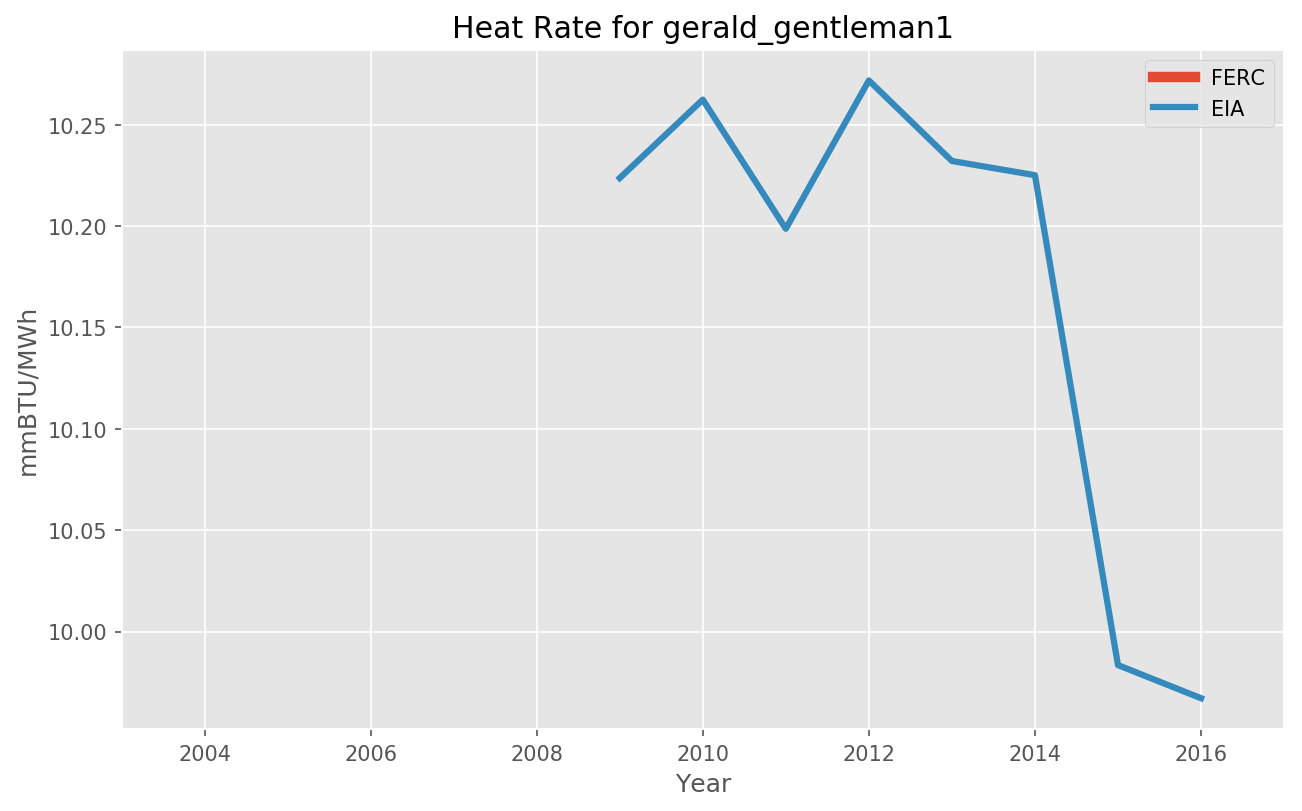

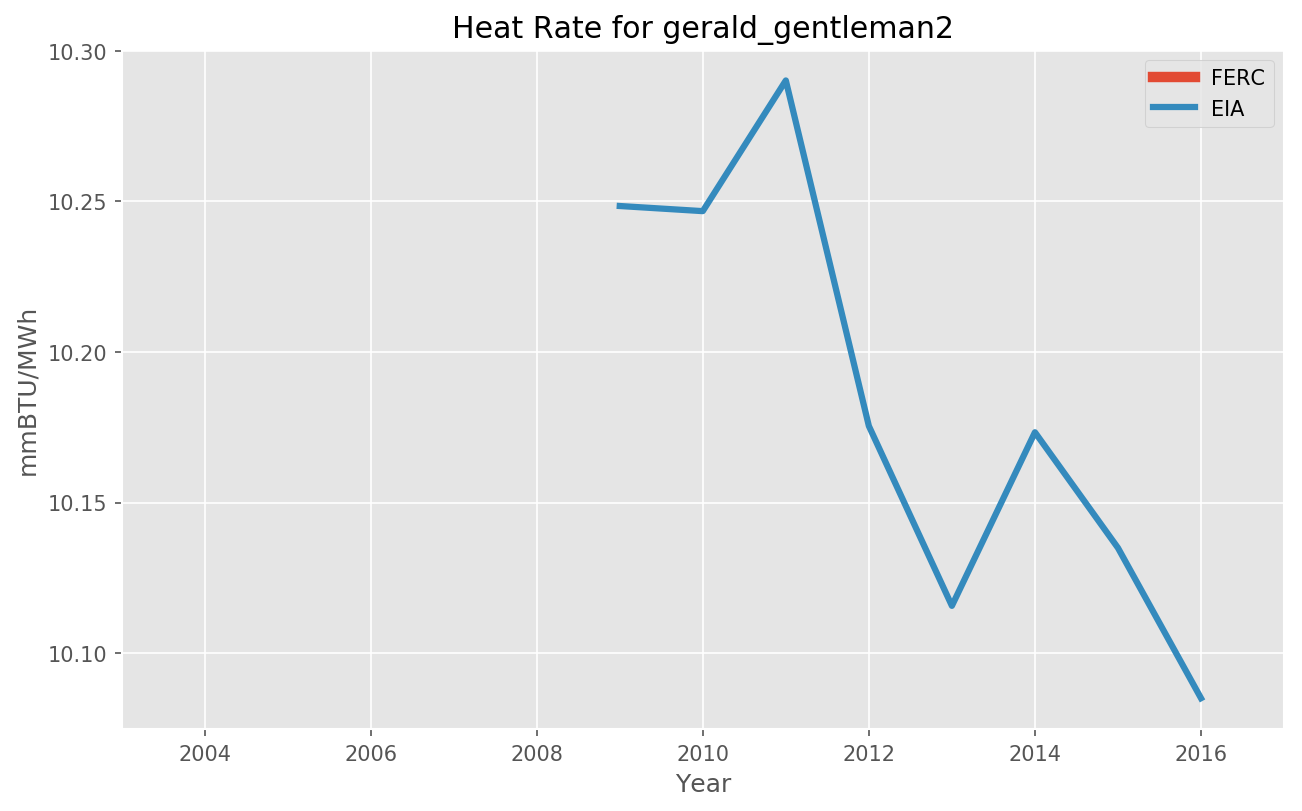

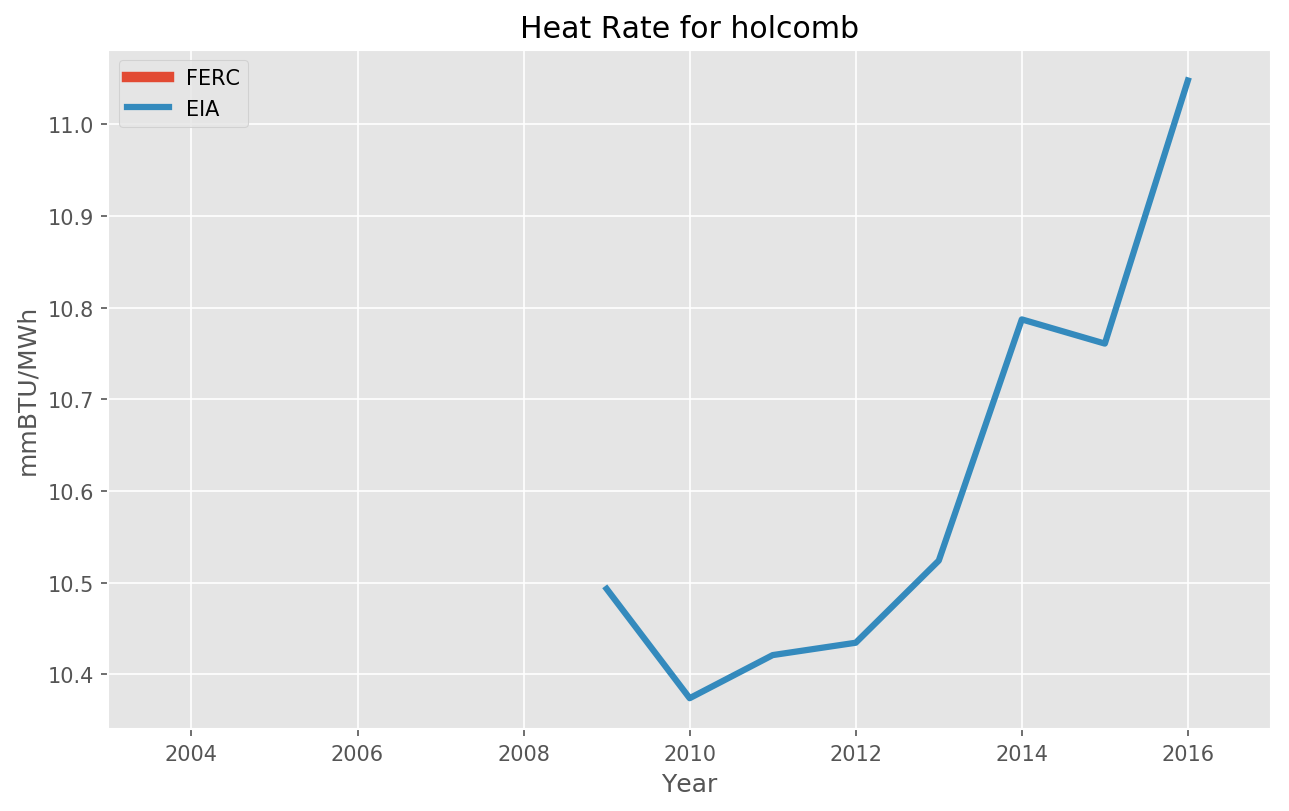

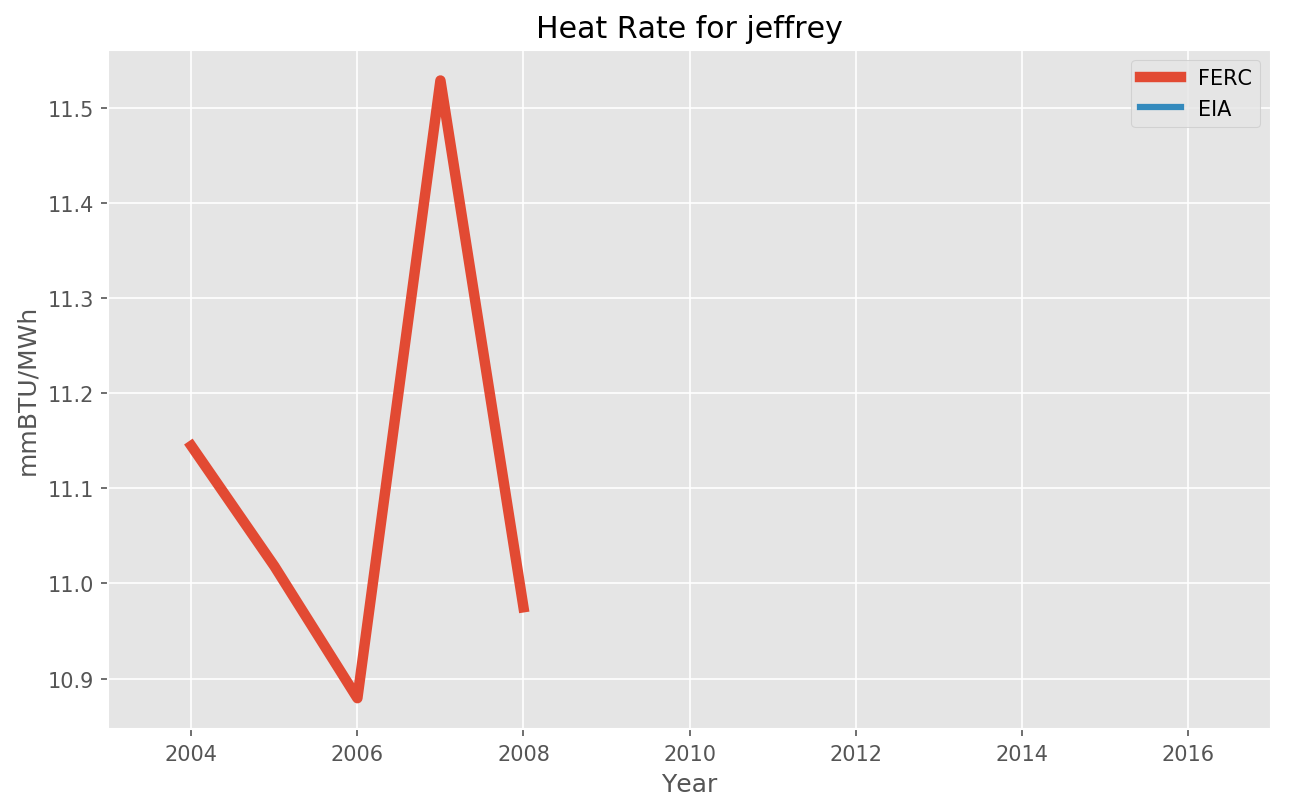

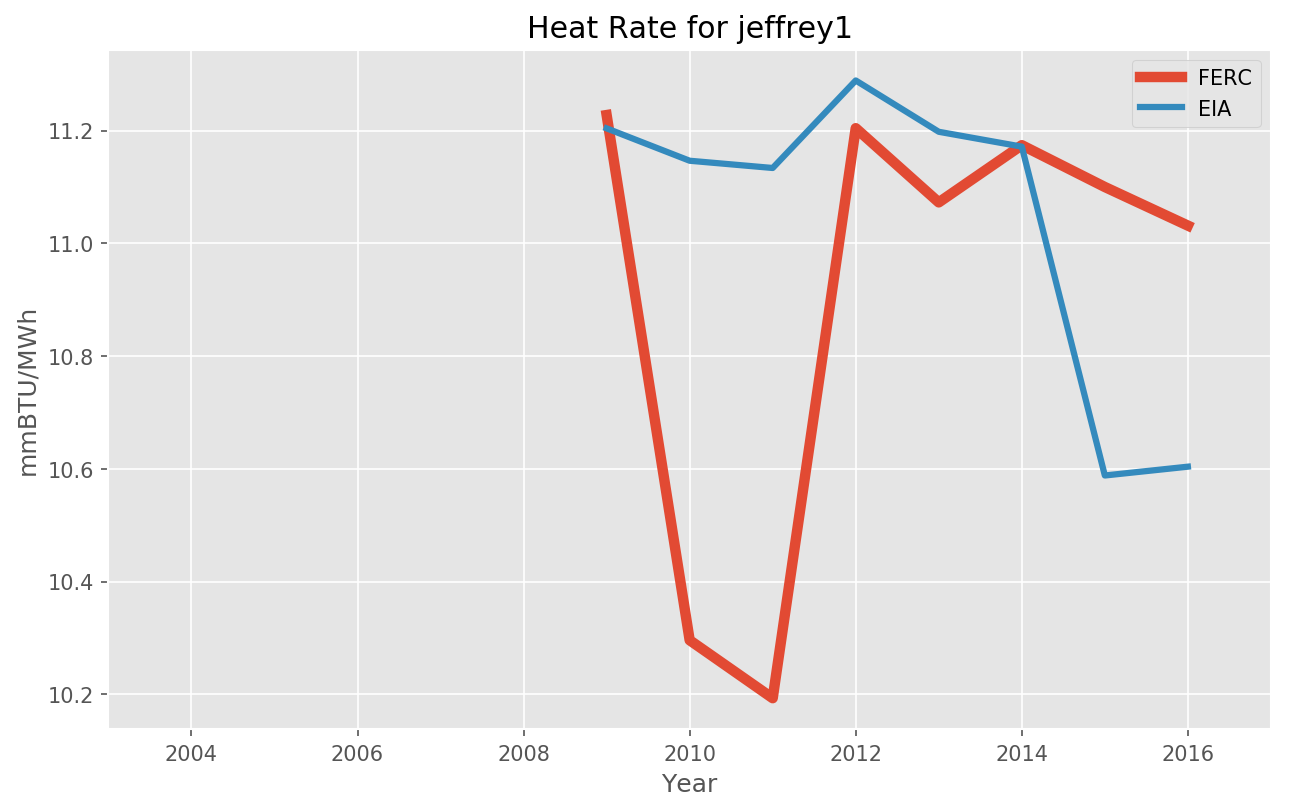

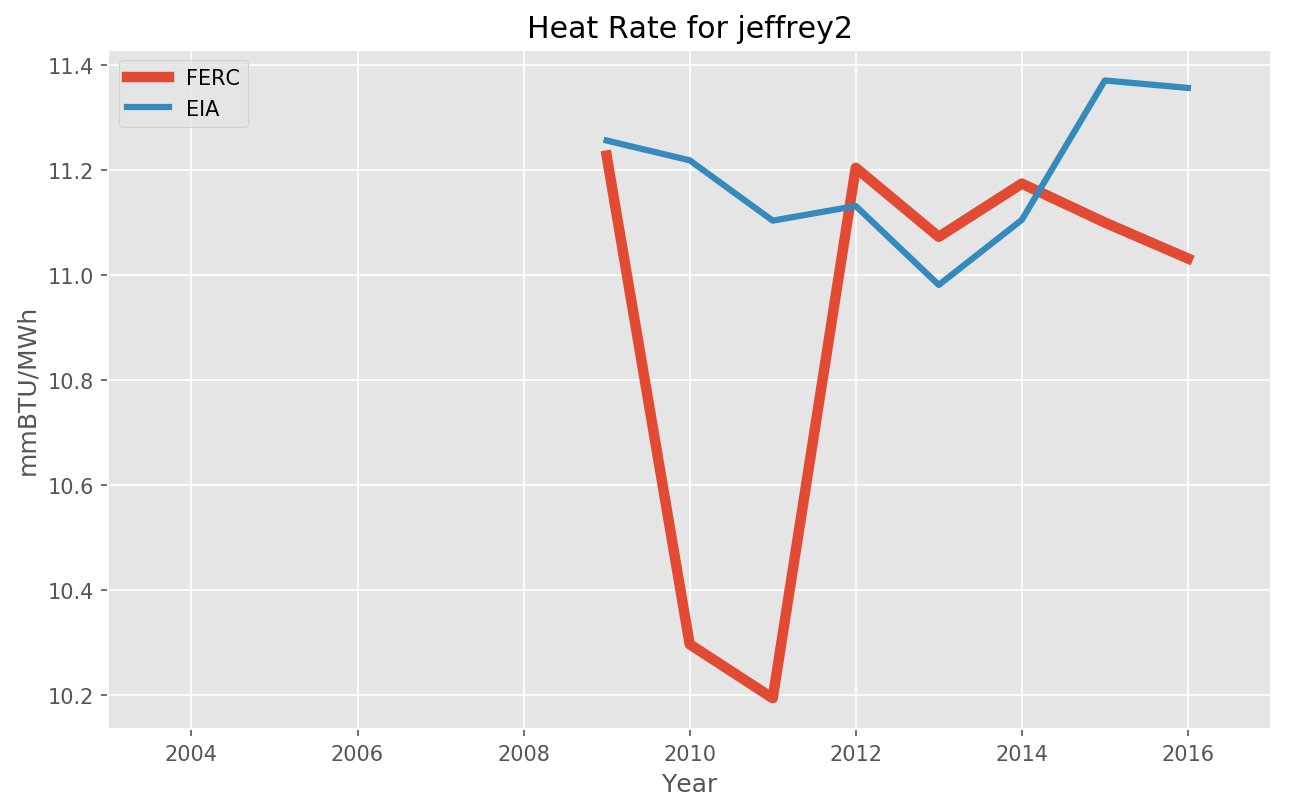

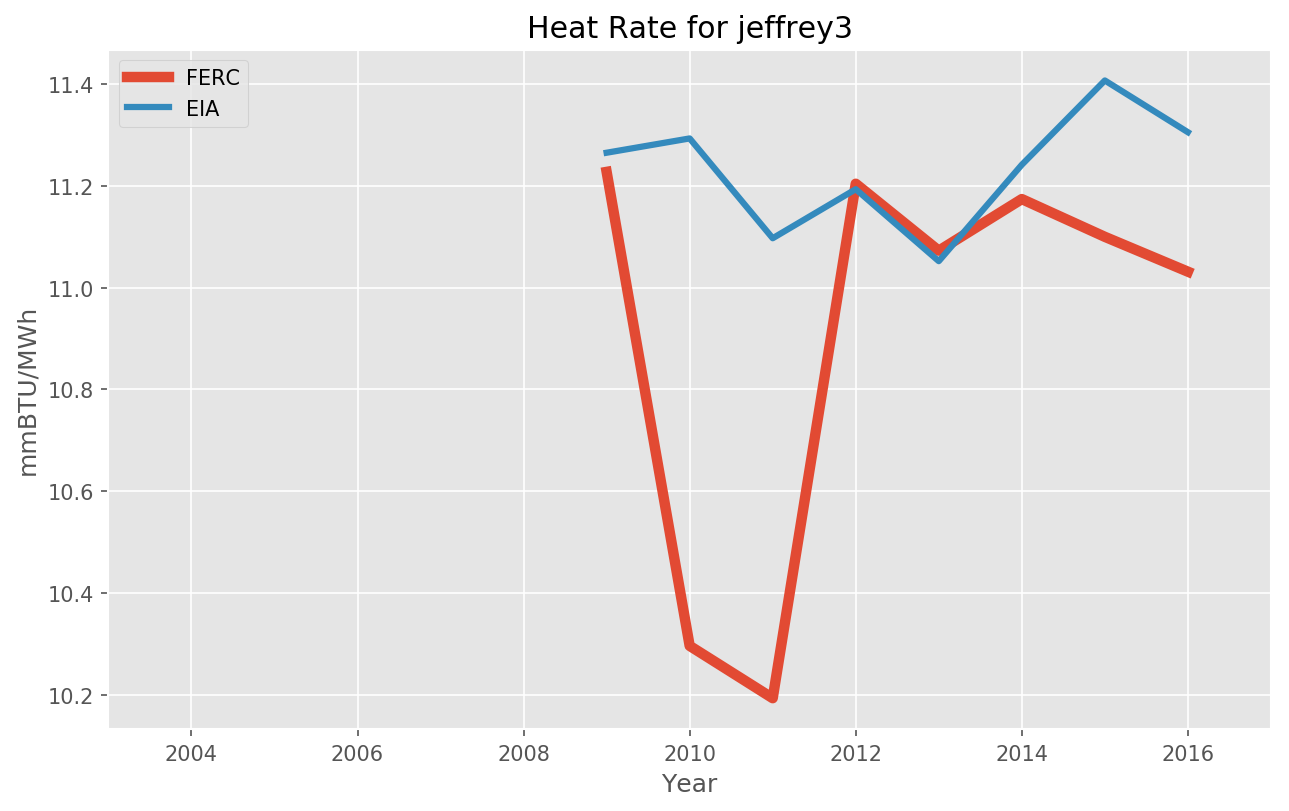

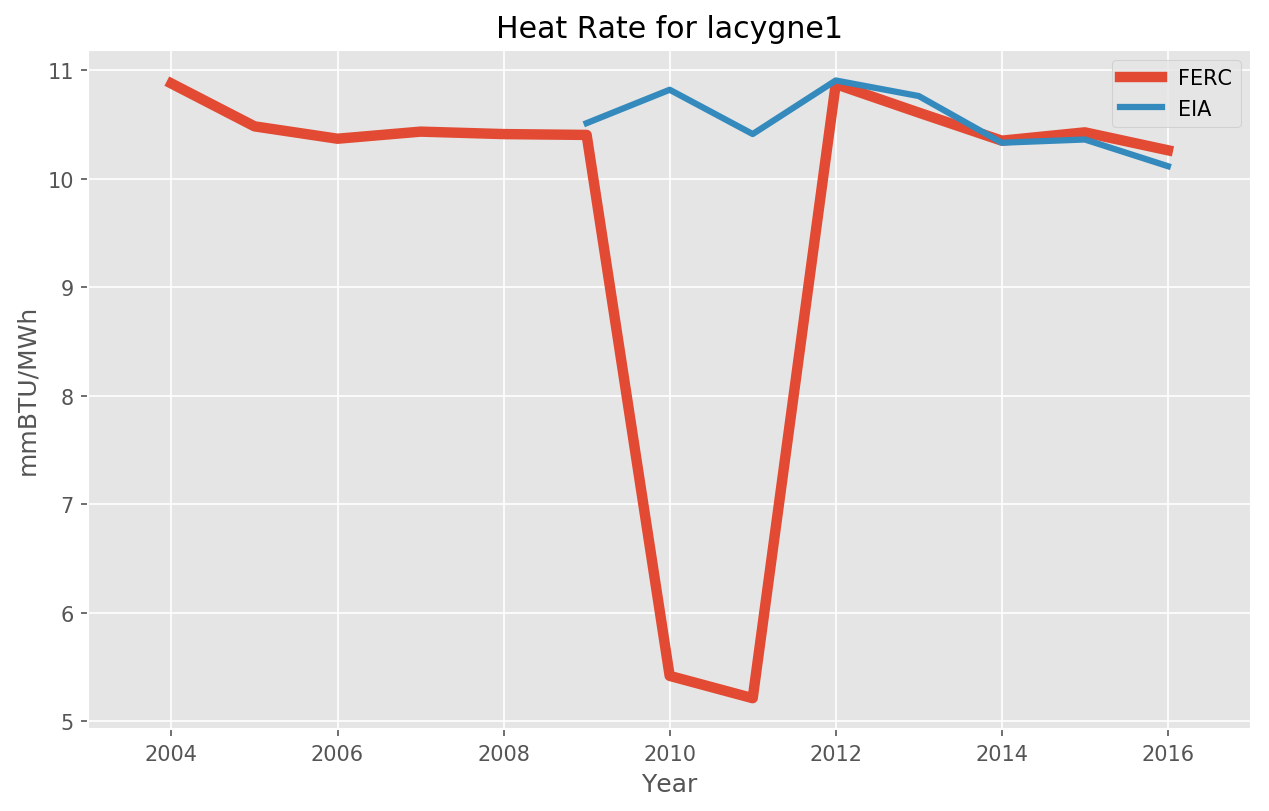

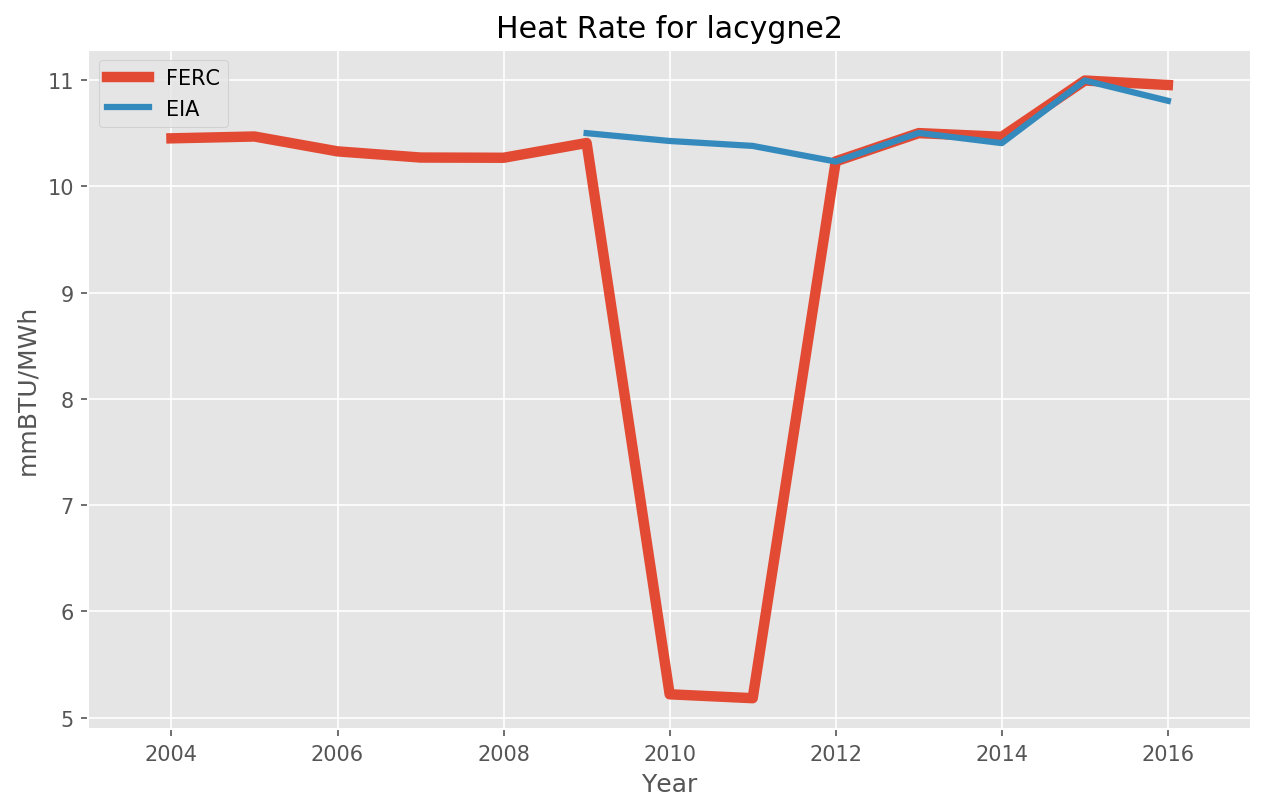

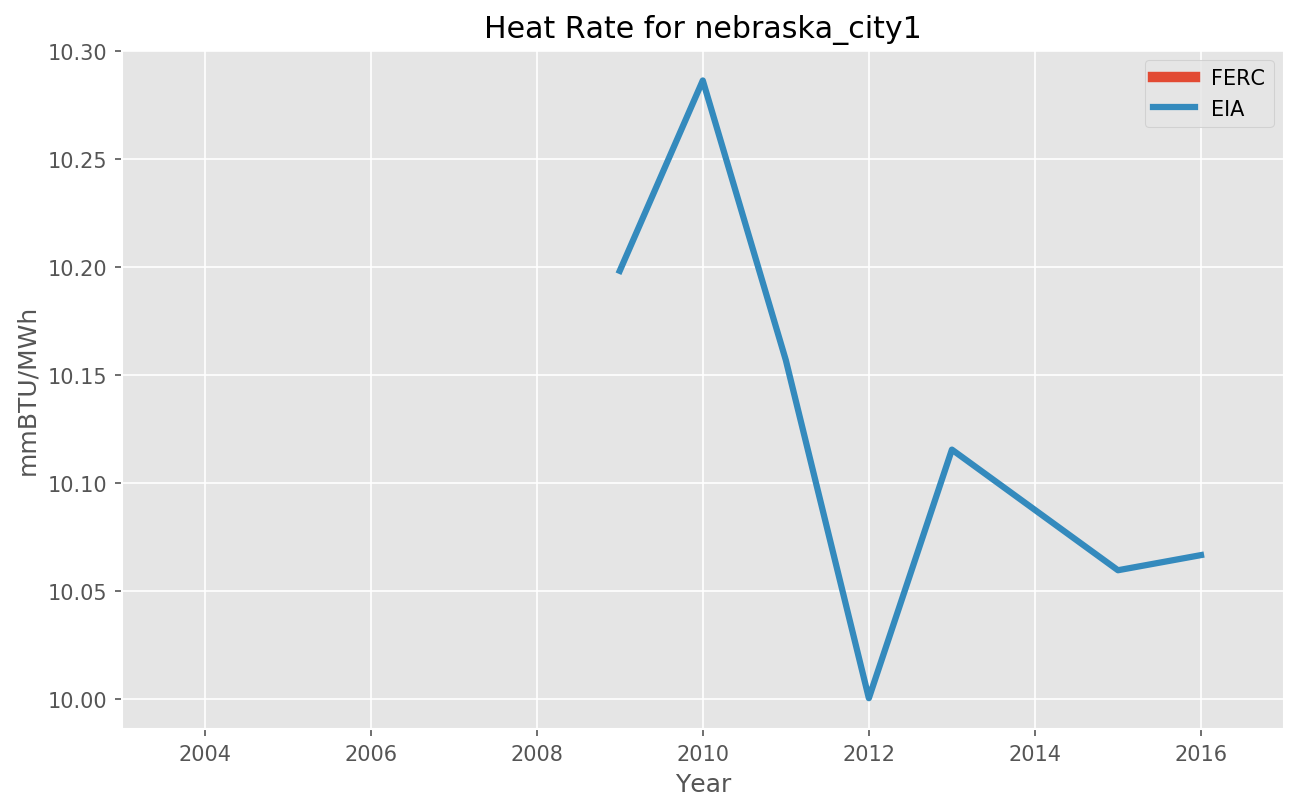

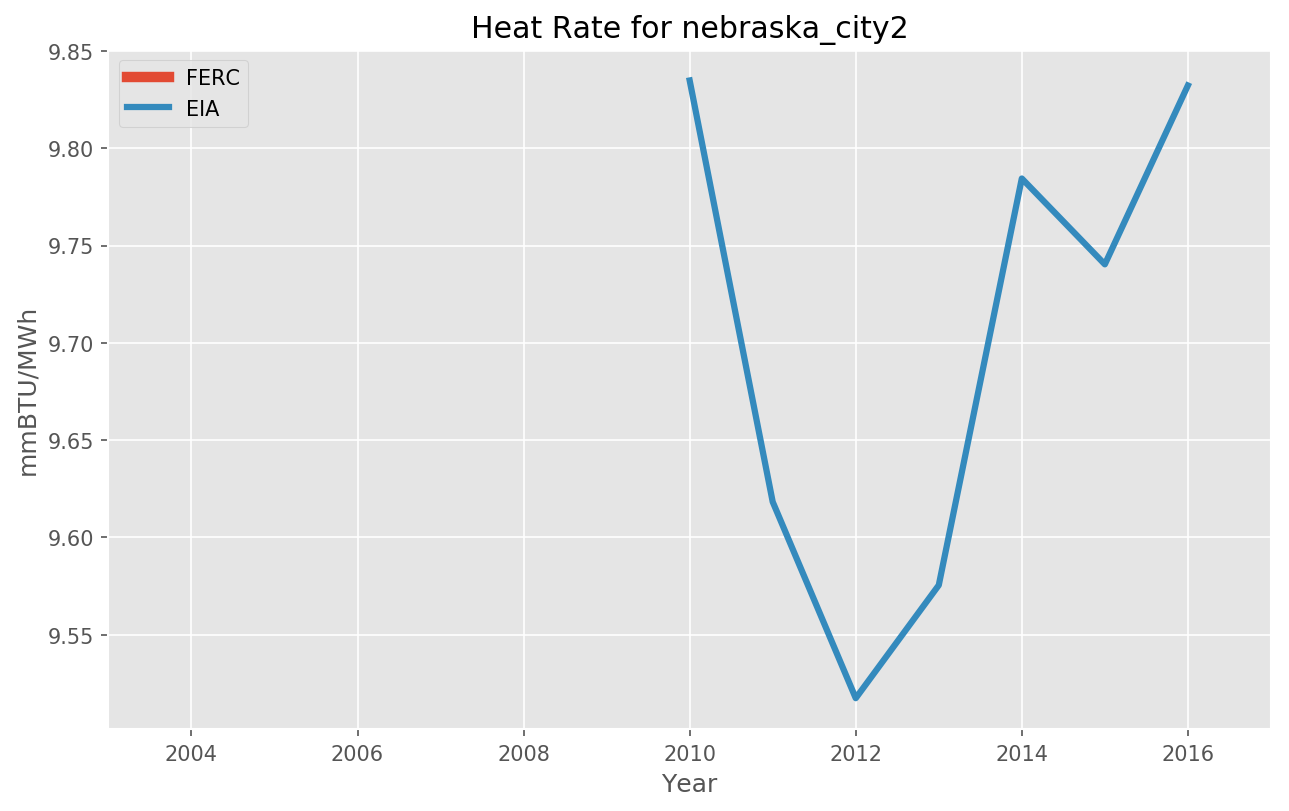

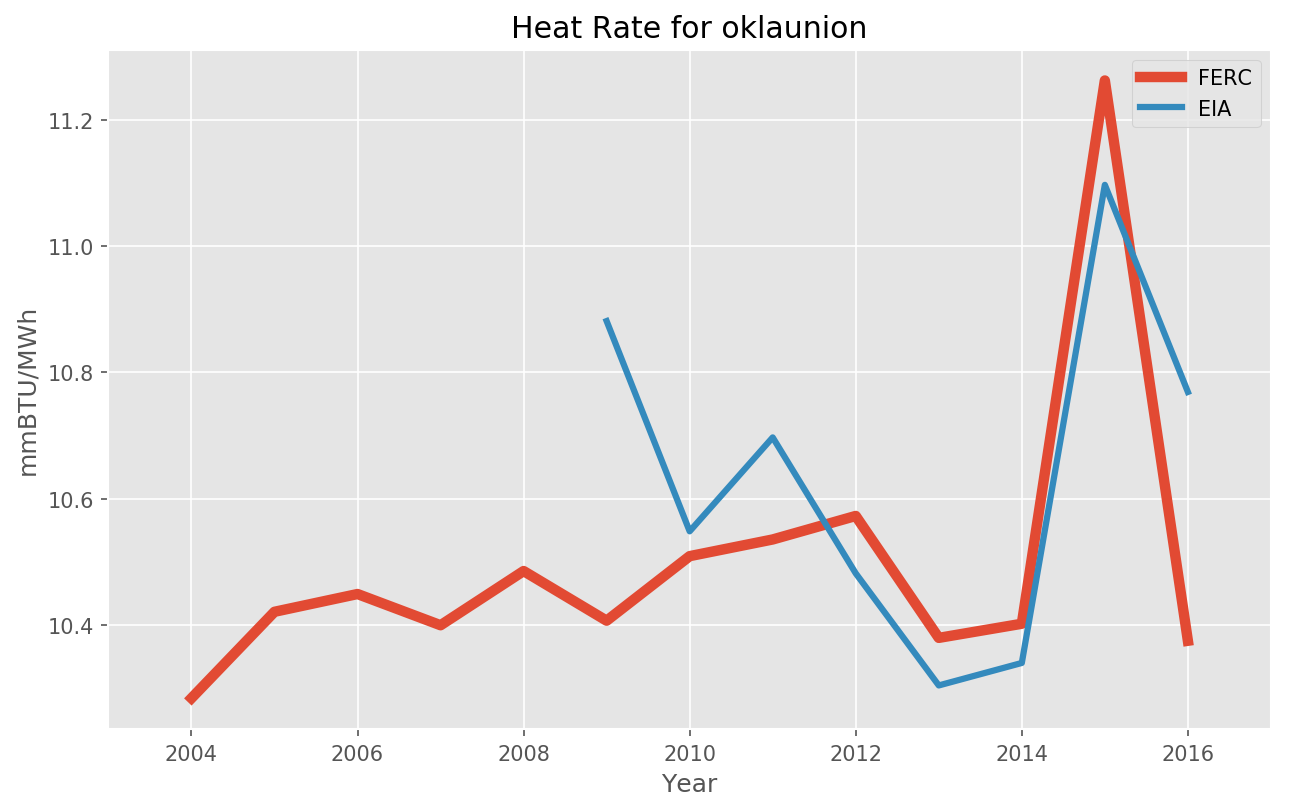

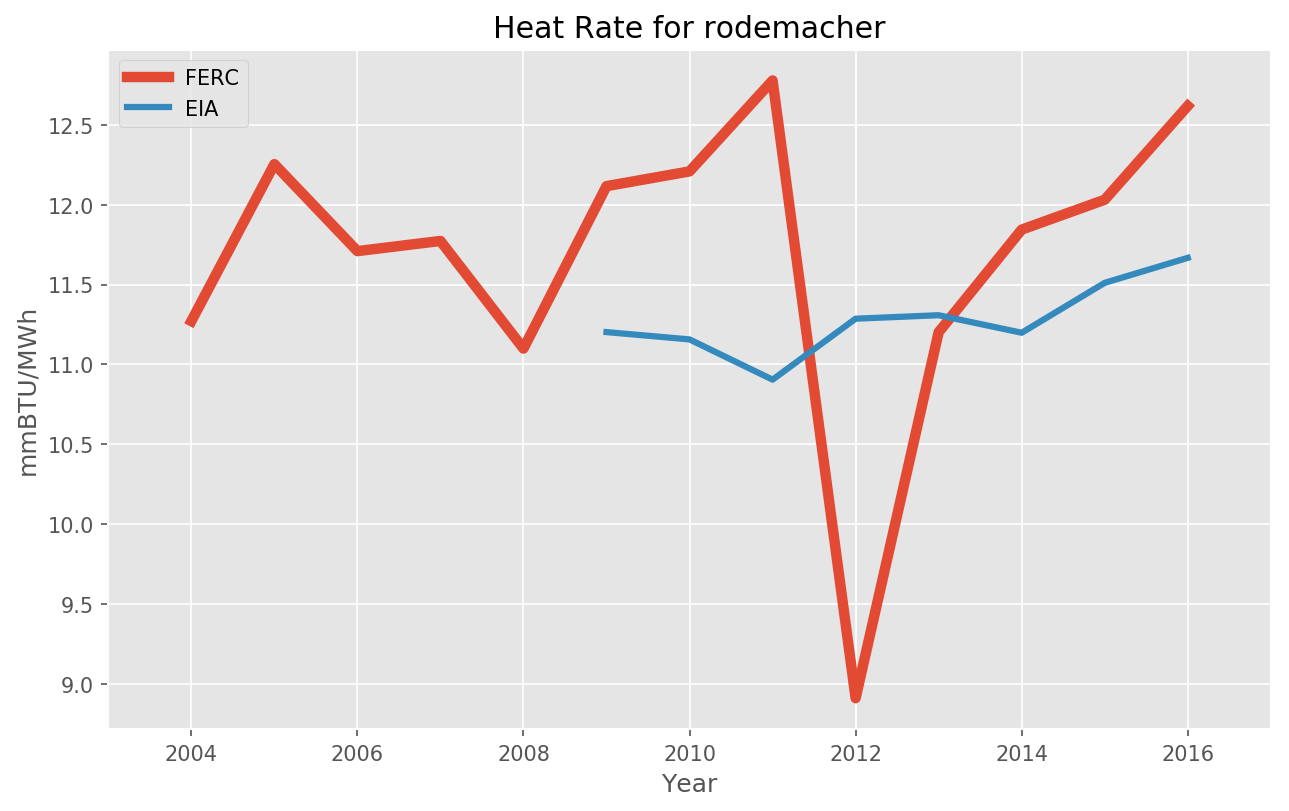

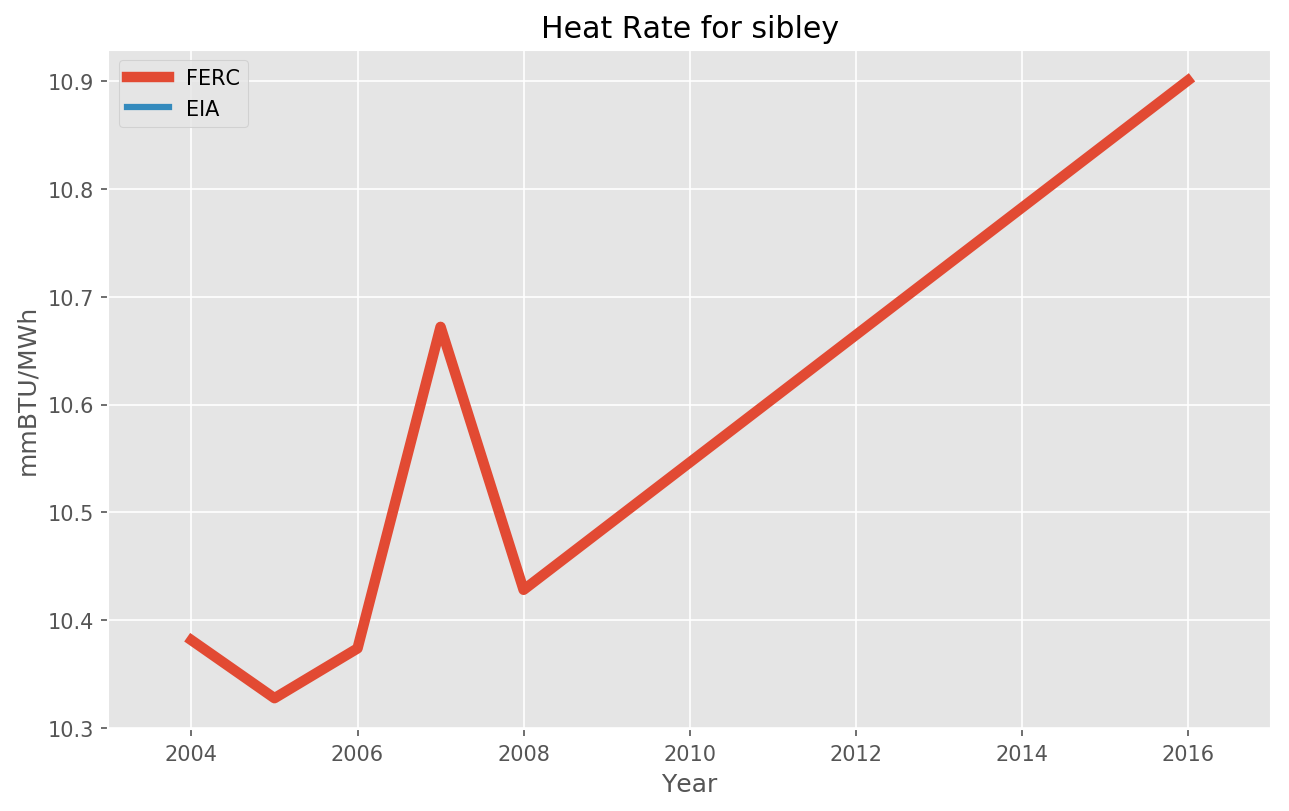

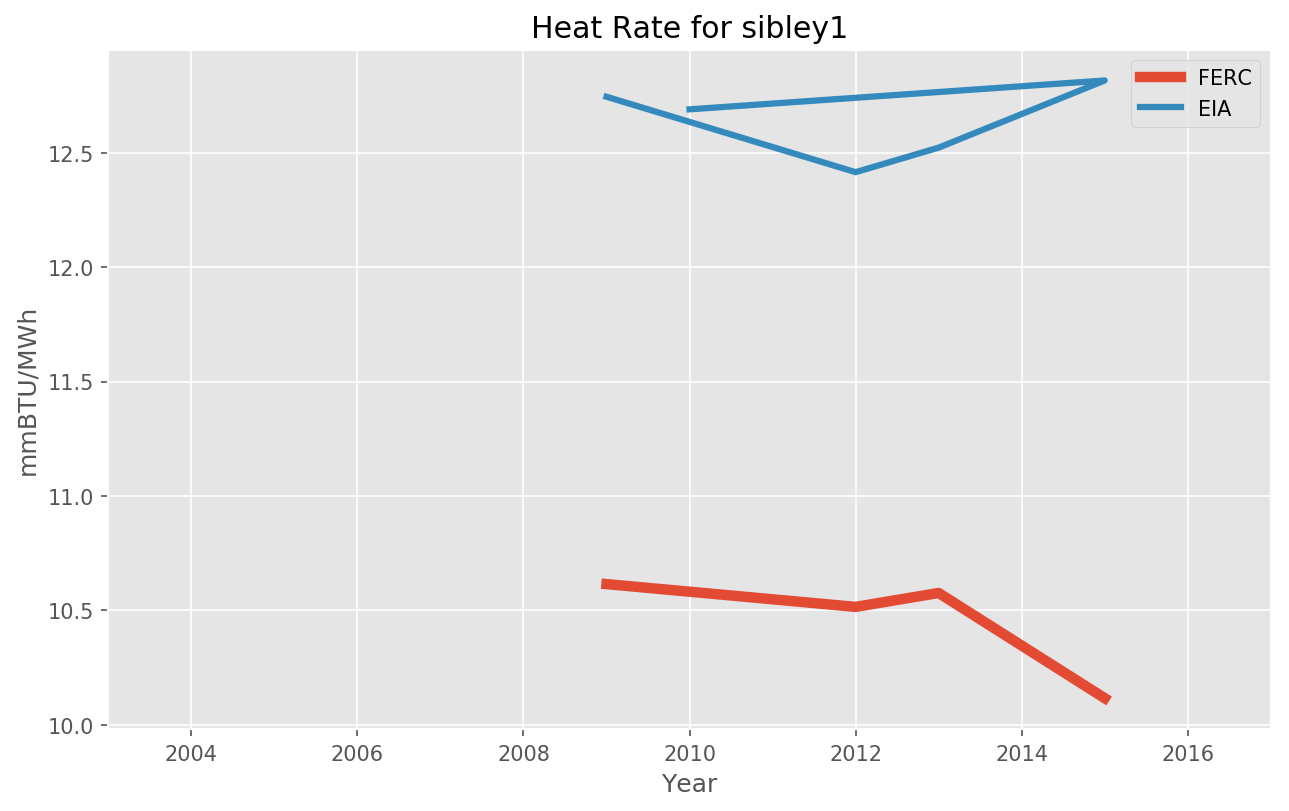

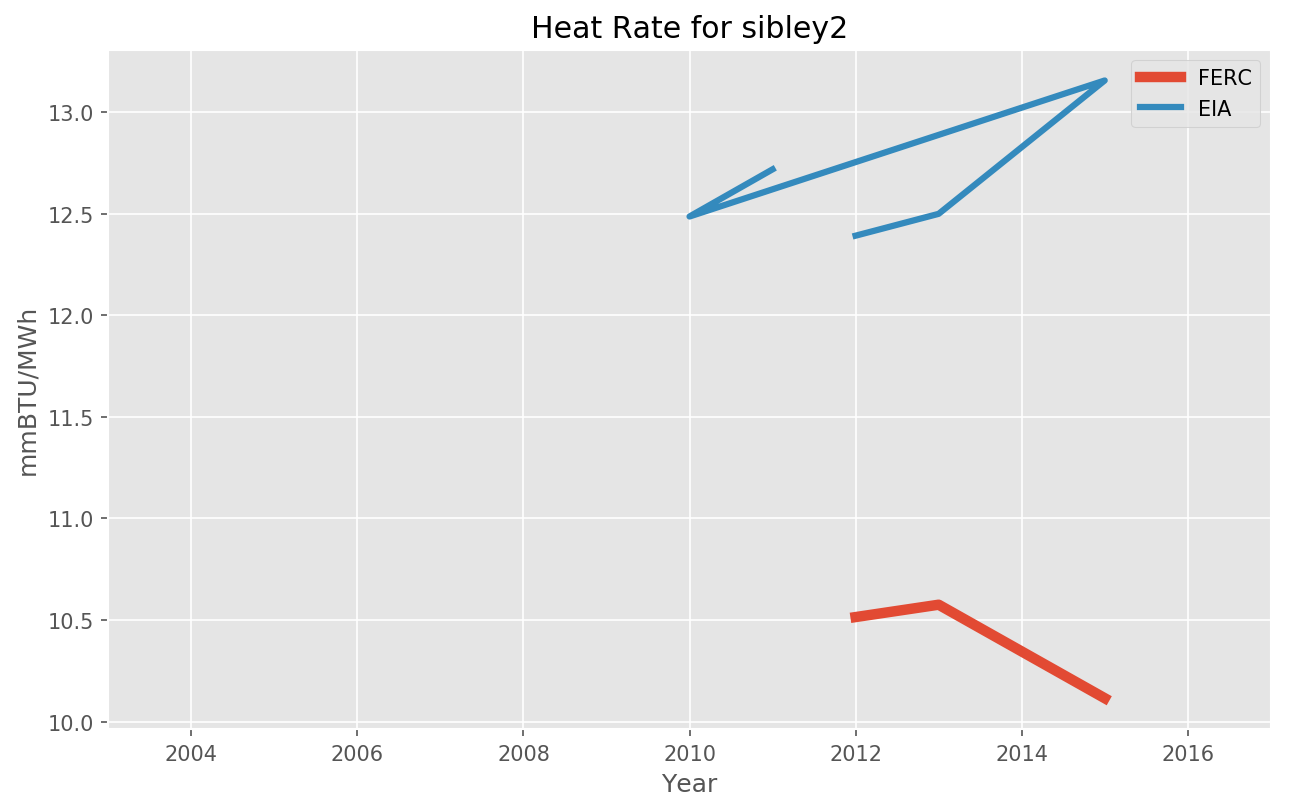

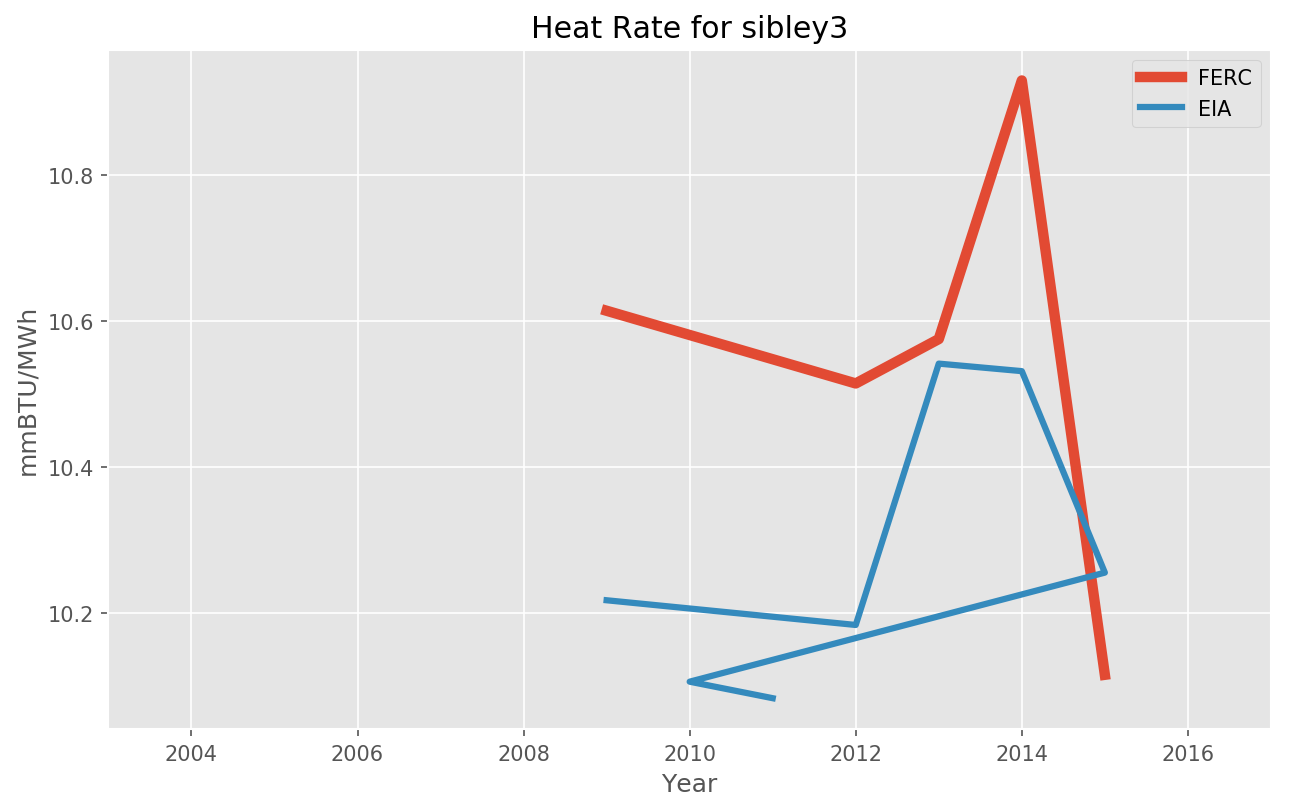

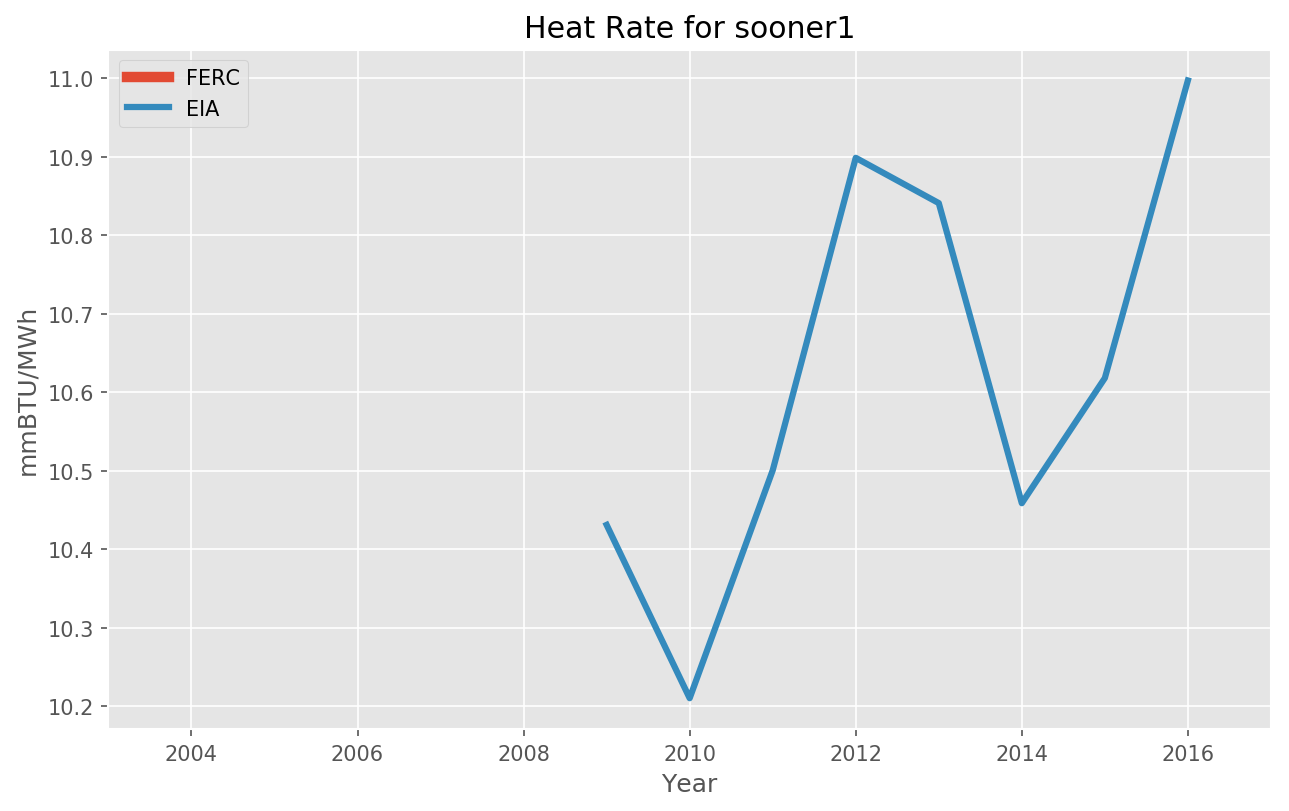

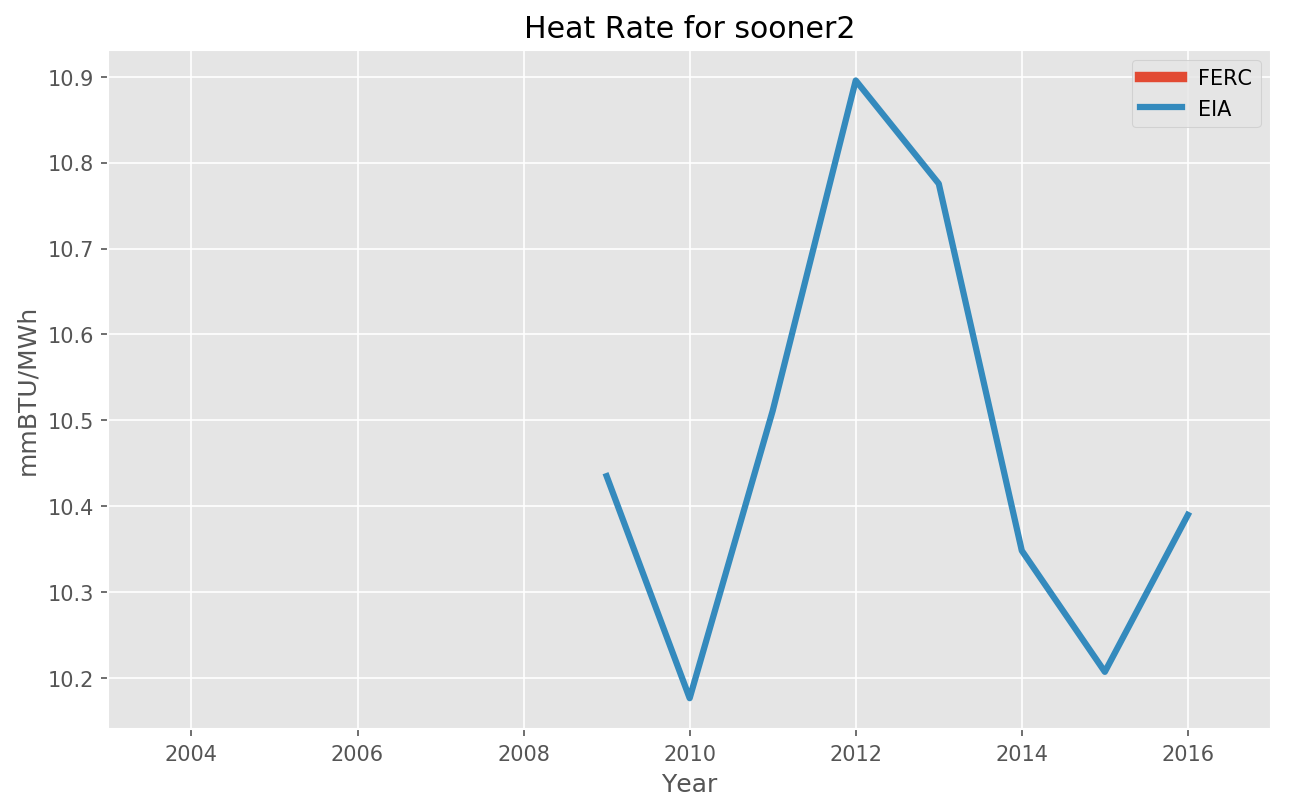

In [54]:
plot_ferc_eia(ces_byplant,
              cols=['heat_rate_mmbtu_mwh_ferc', 'heat_rate_mmbtu_mwh_eia'],
              labels=['FERC', 'EIA'], lws=[5,3],
              title='Heat Rate', ylabel='mmBTU/MWh')

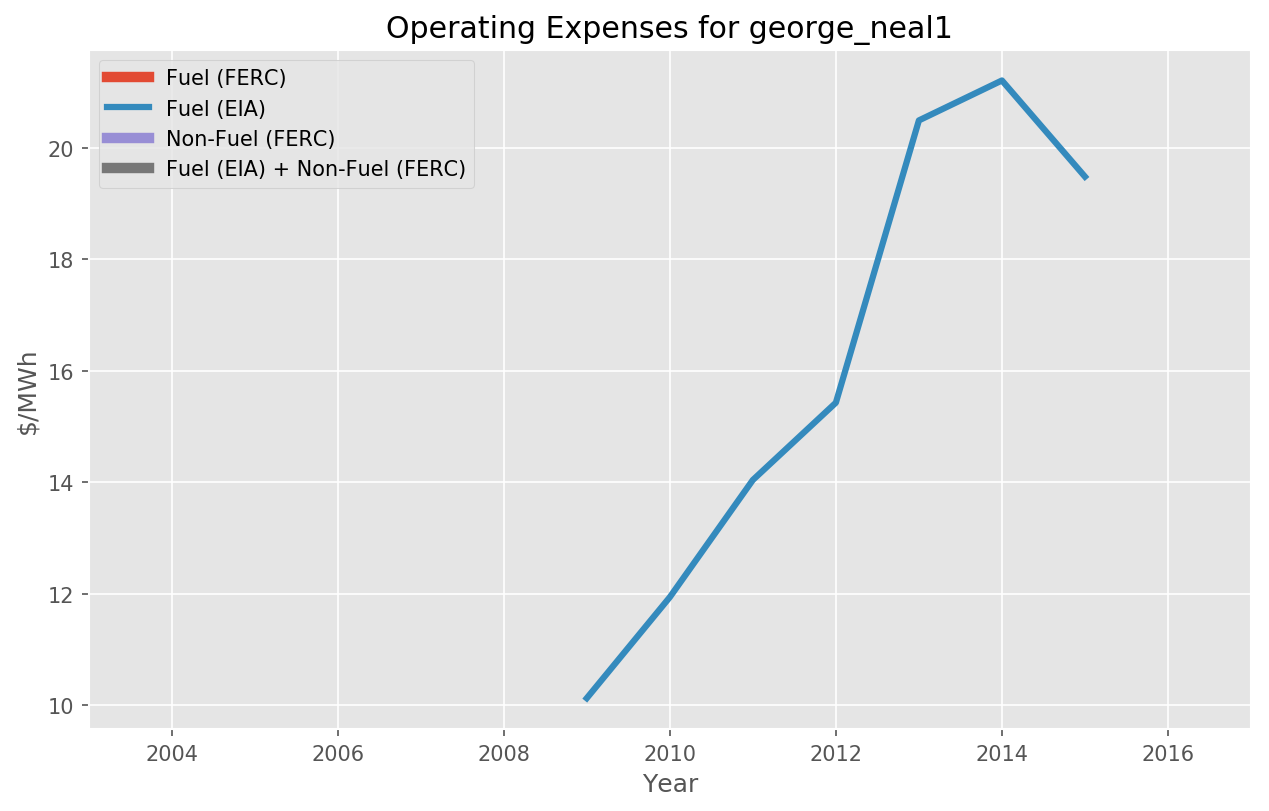

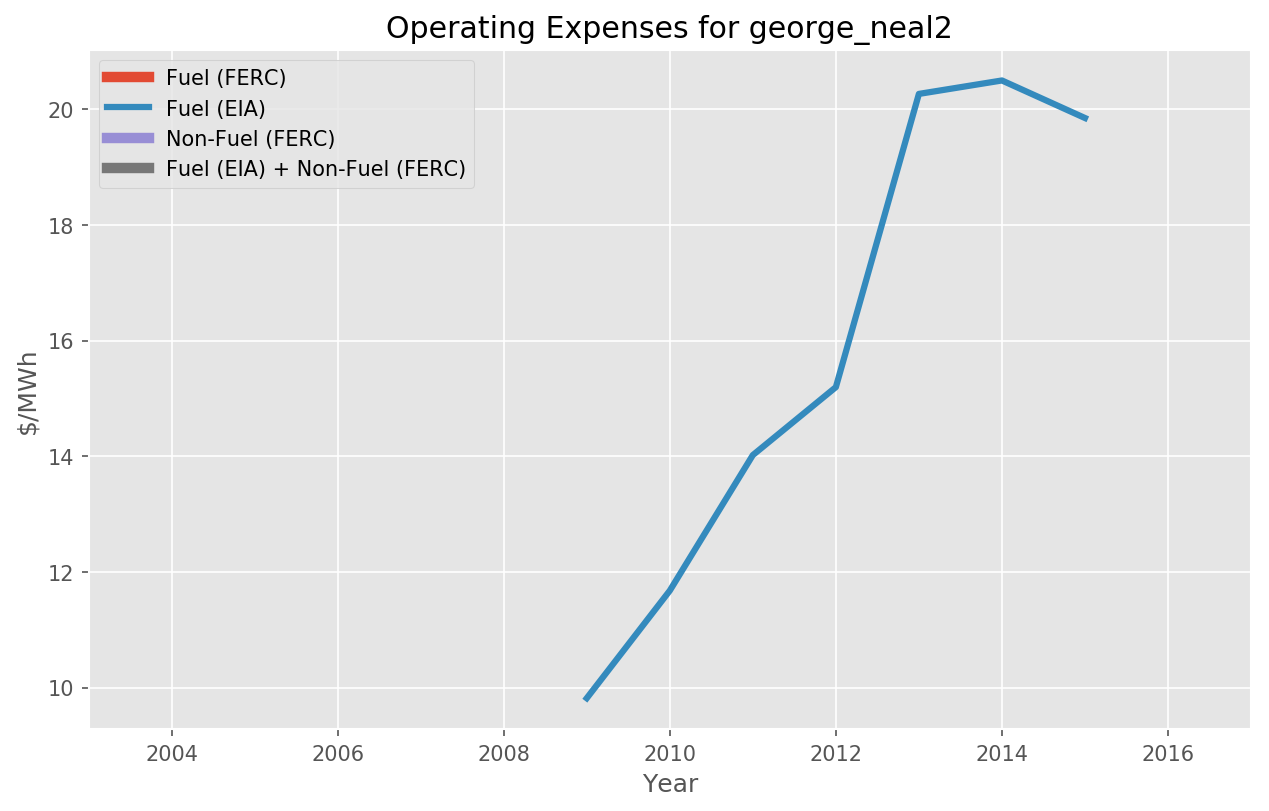

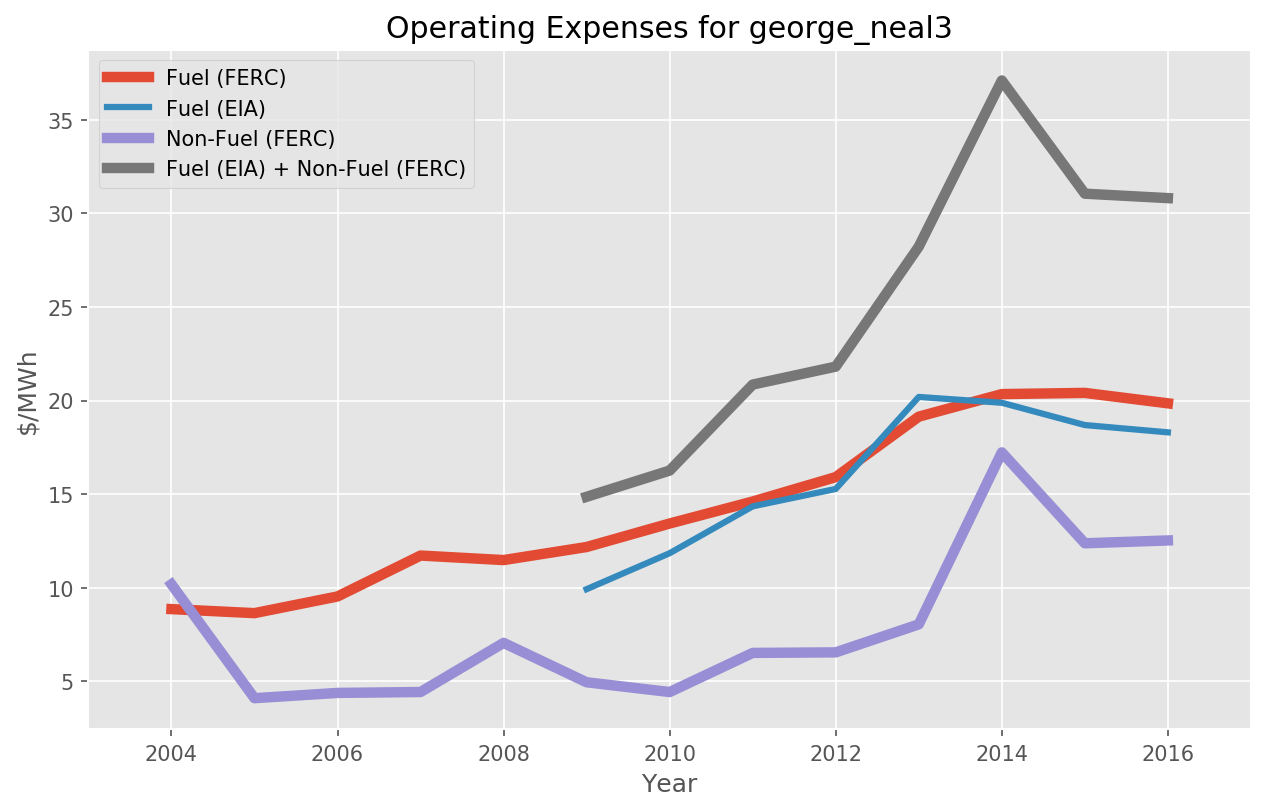

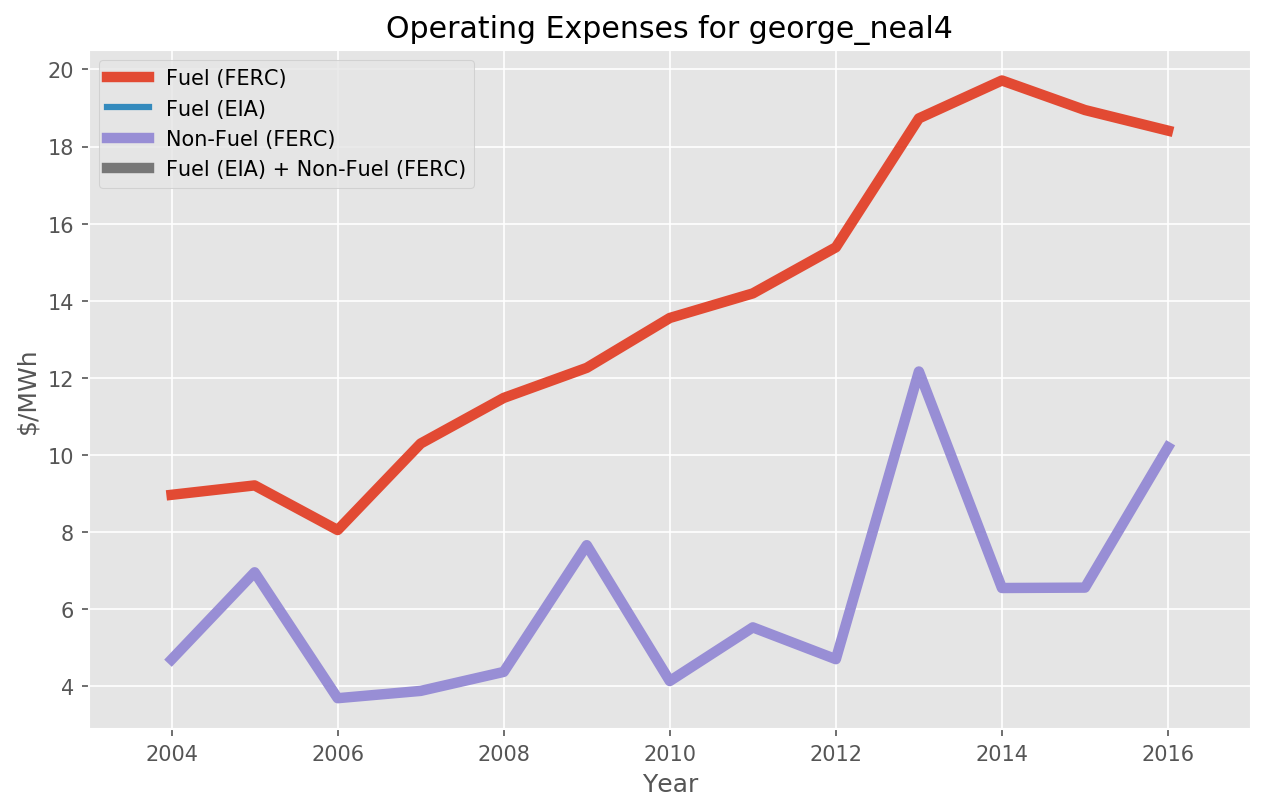

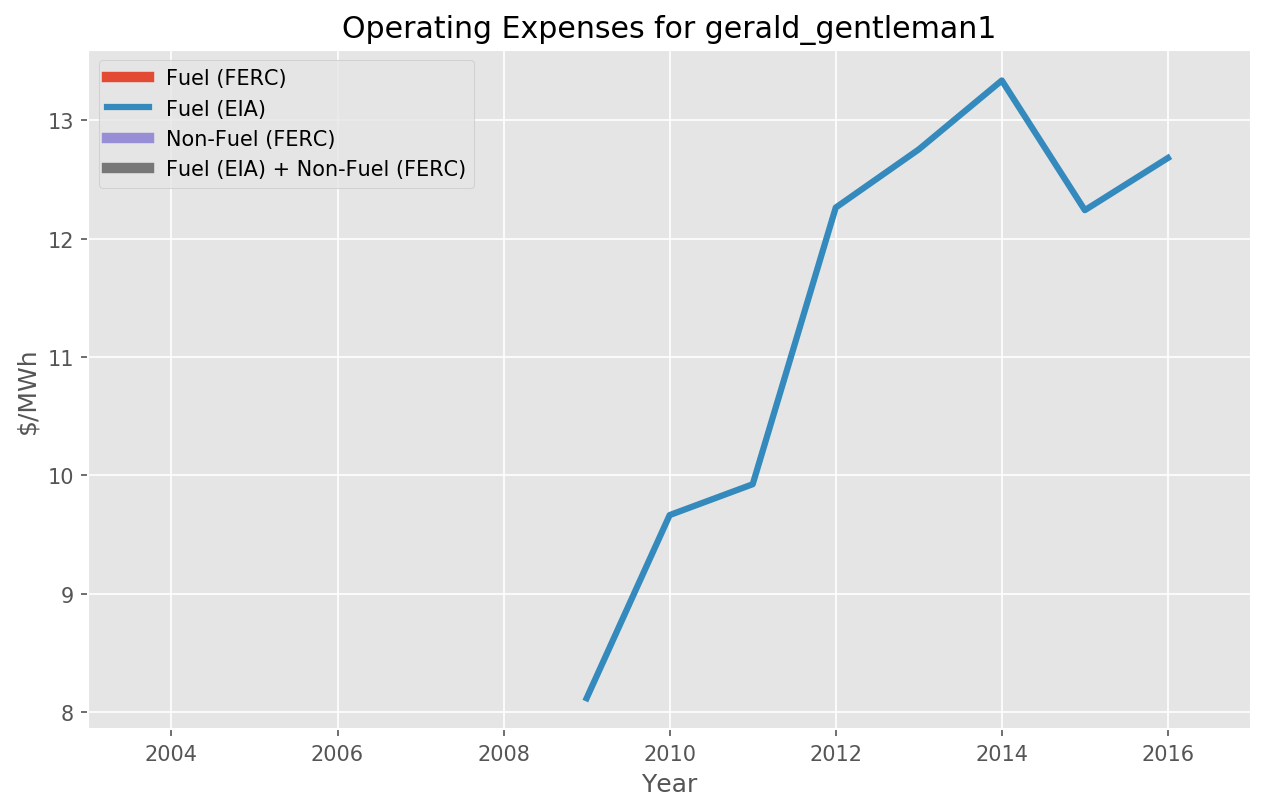

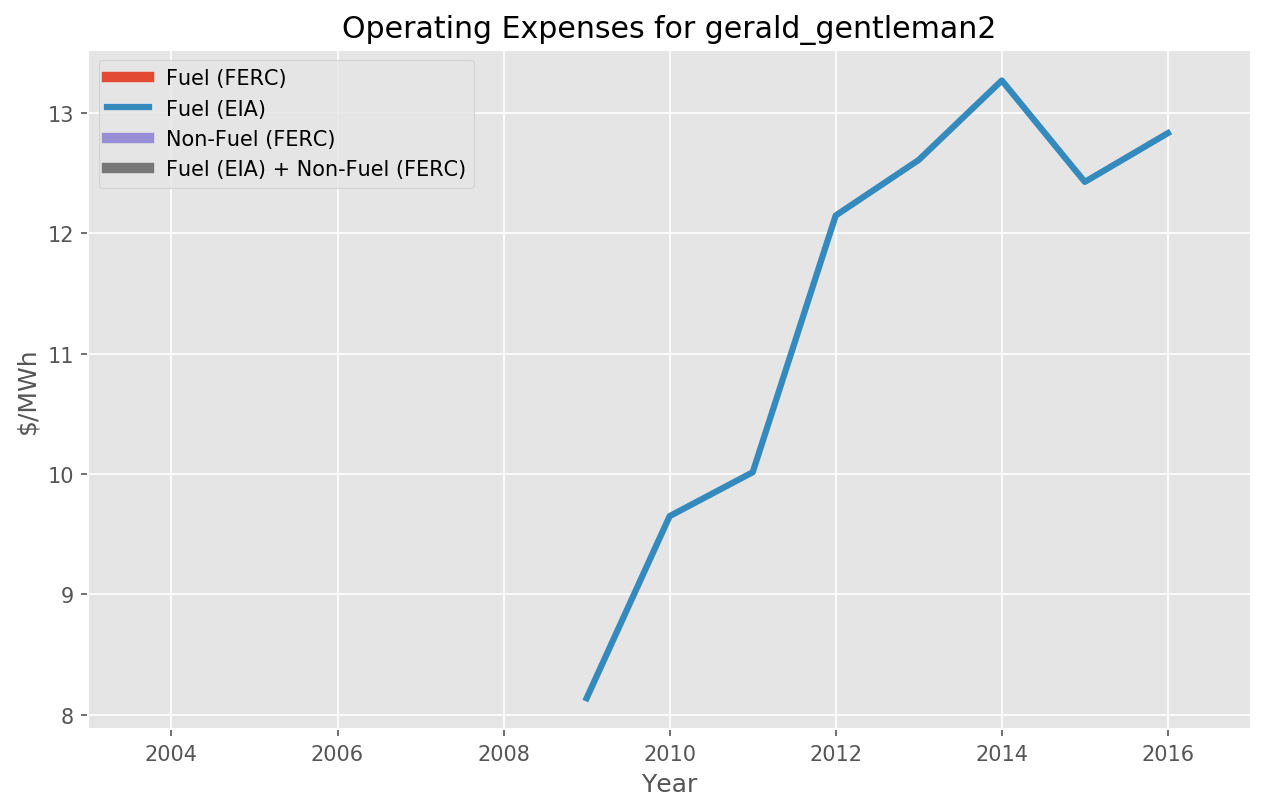

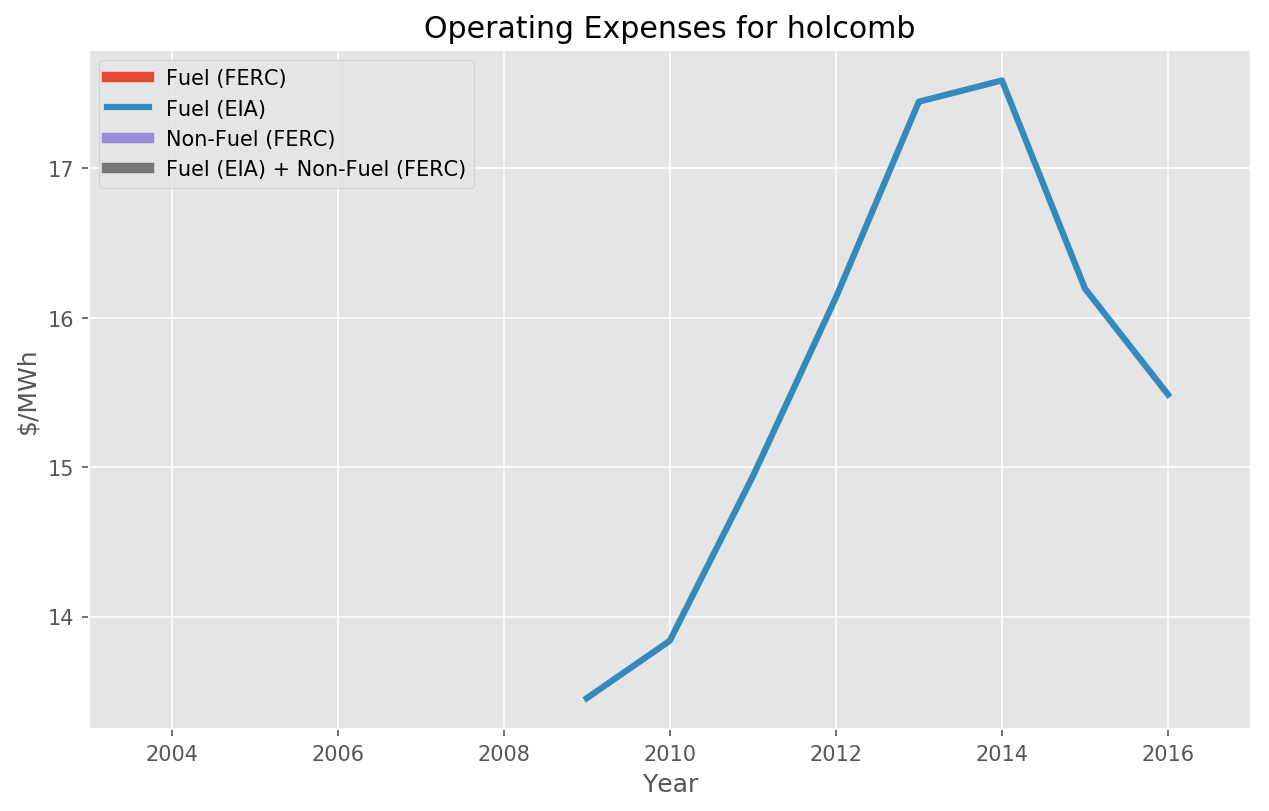

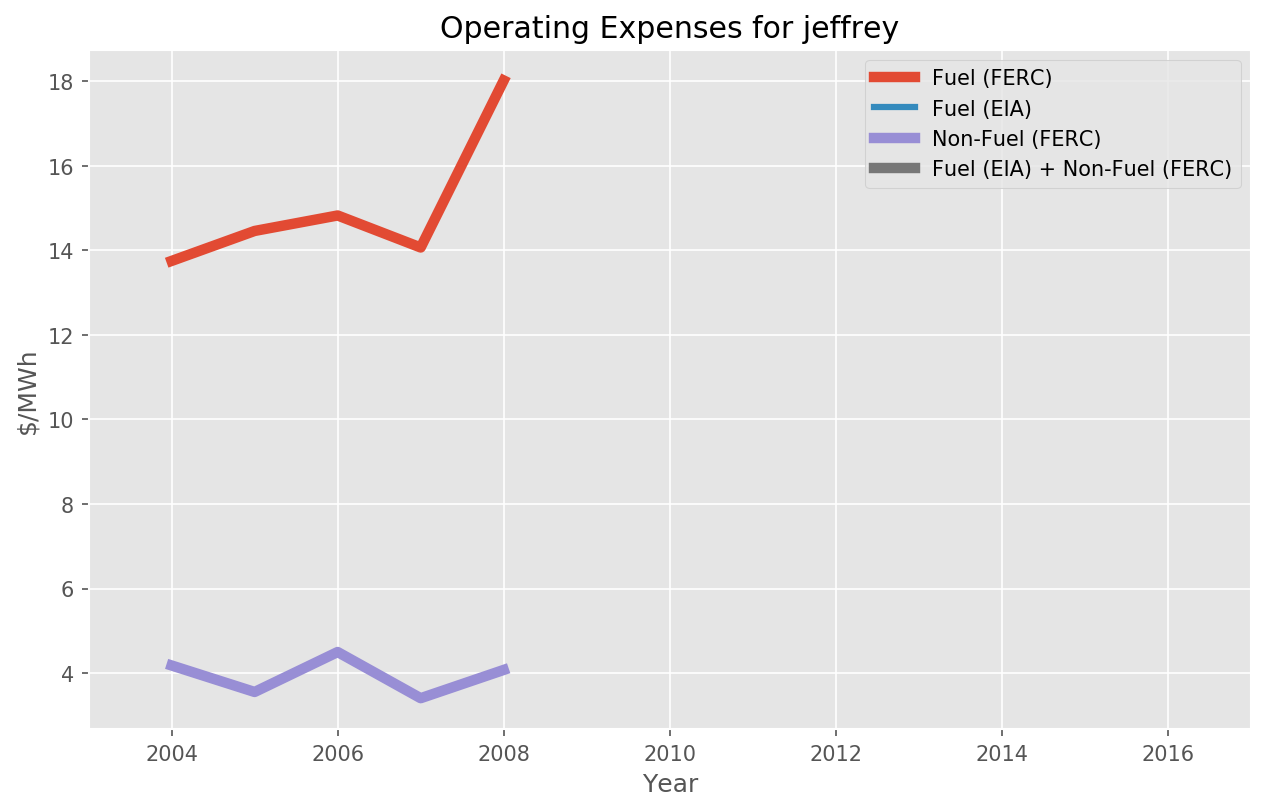

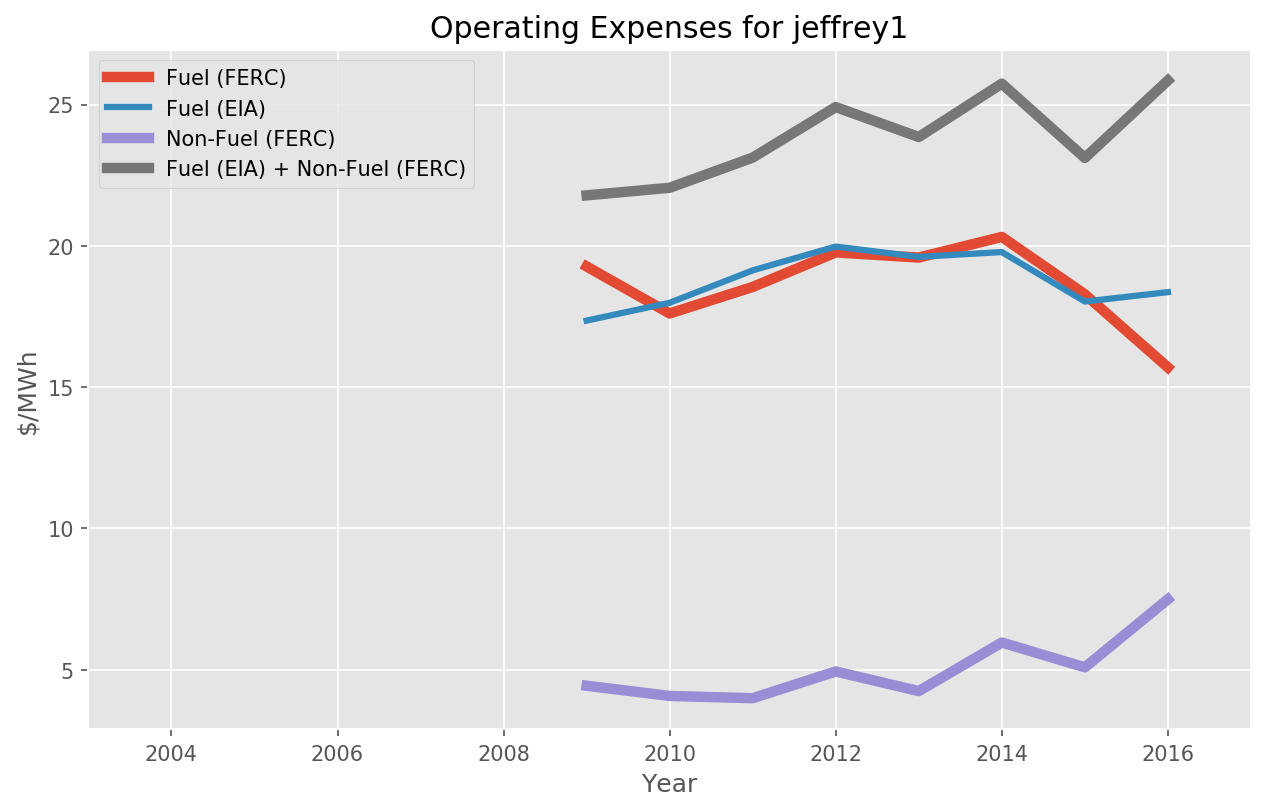

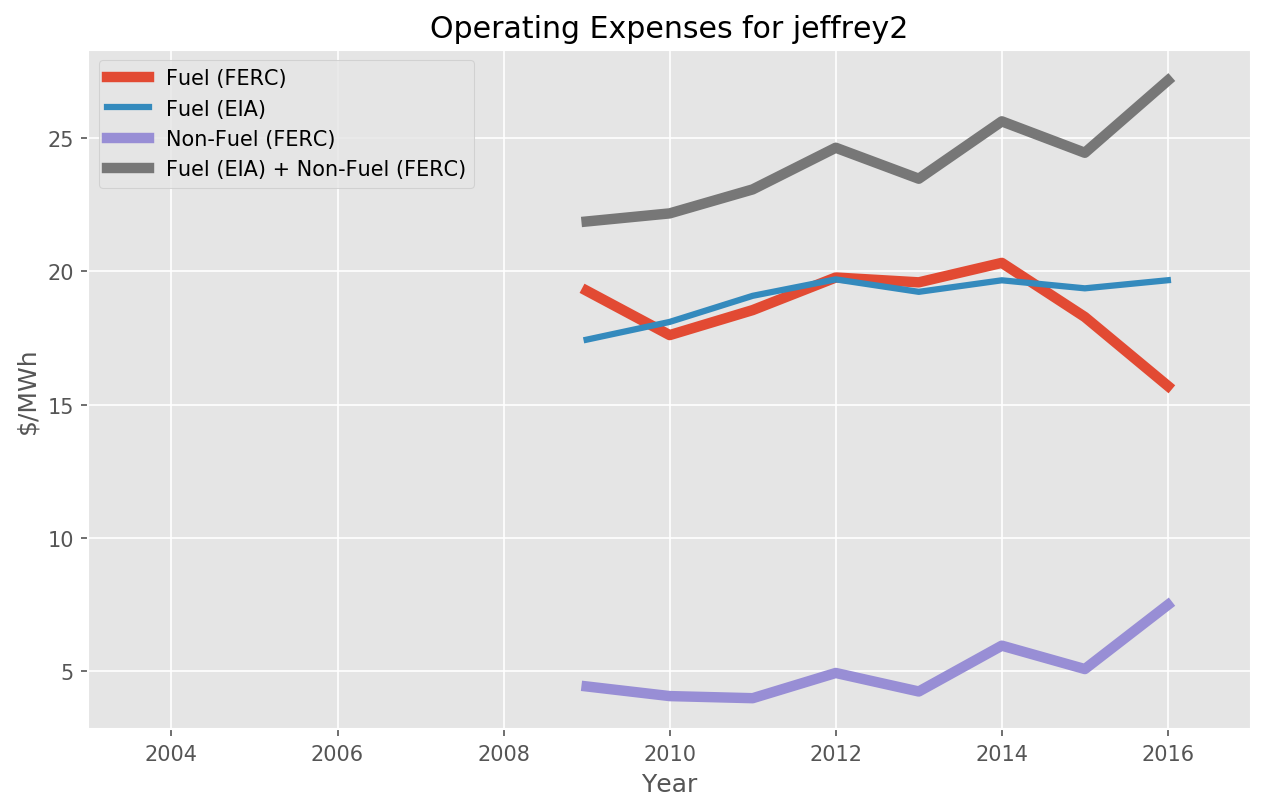

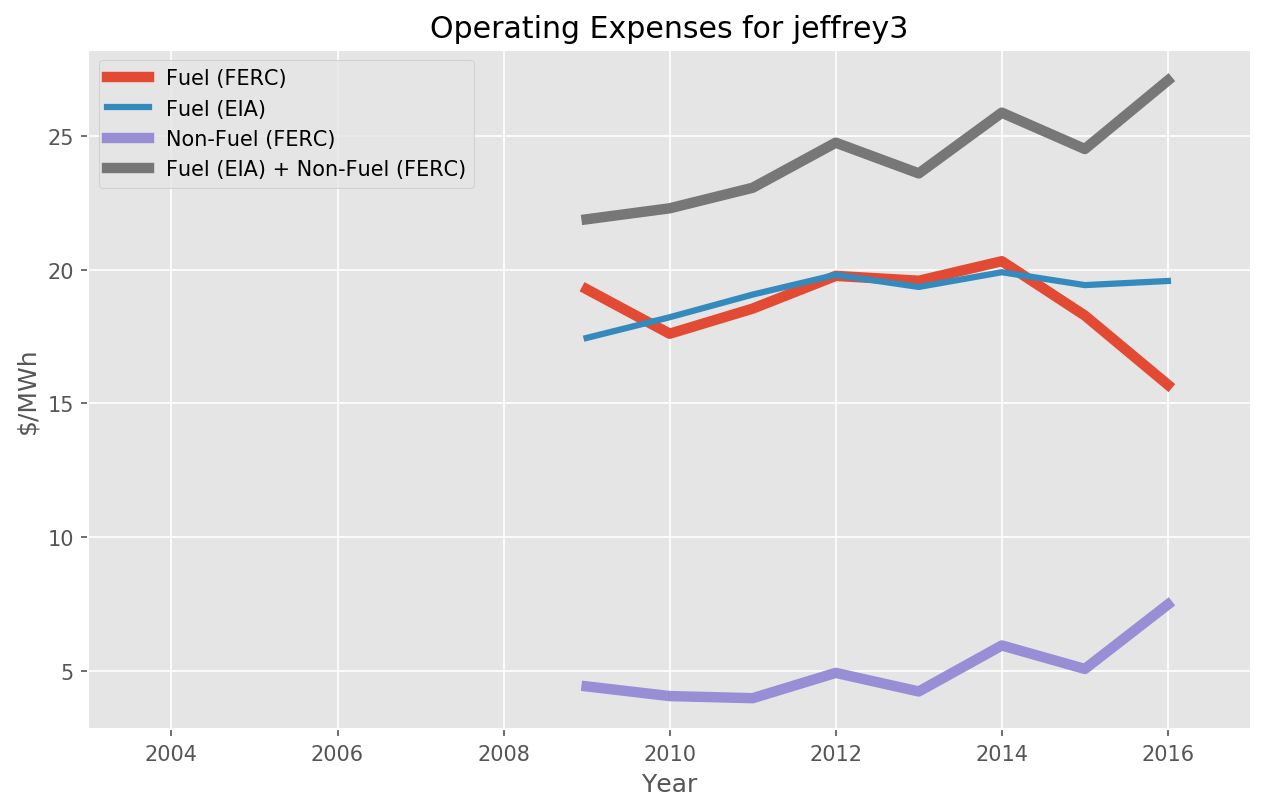

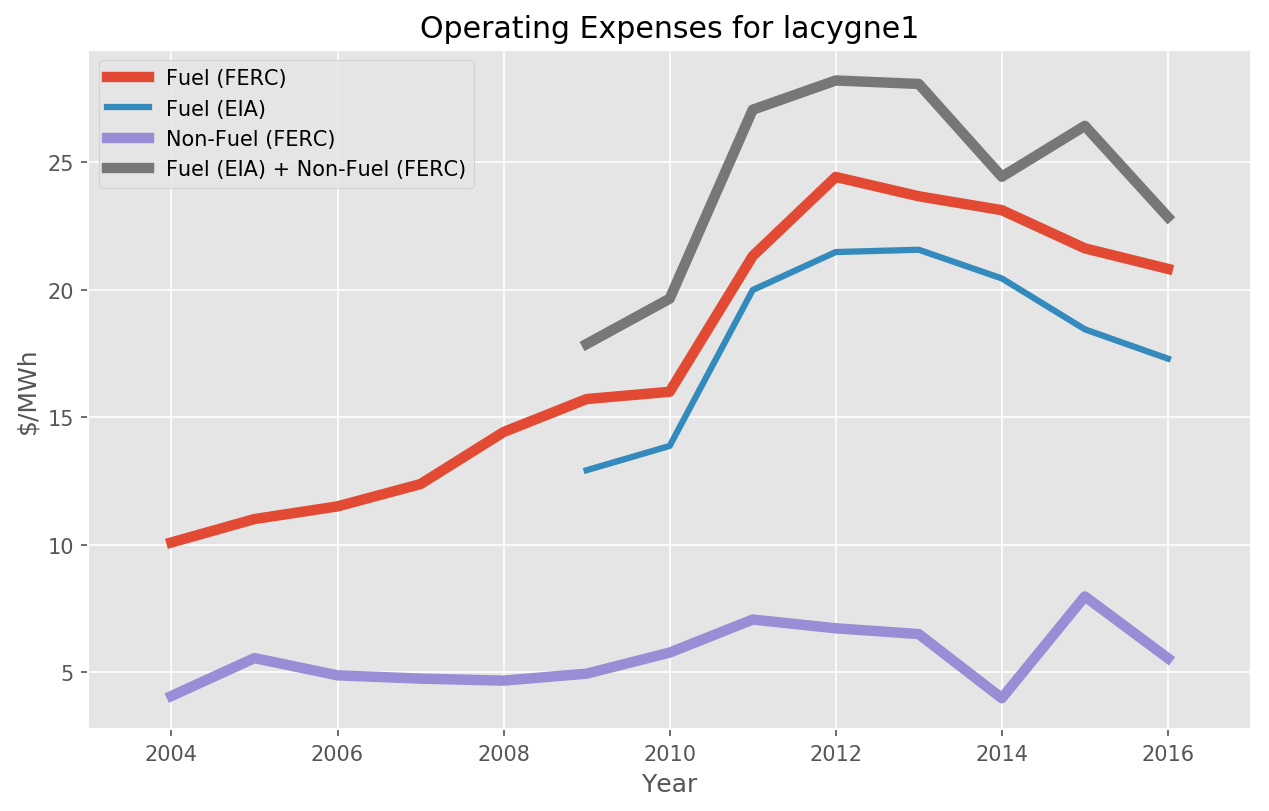

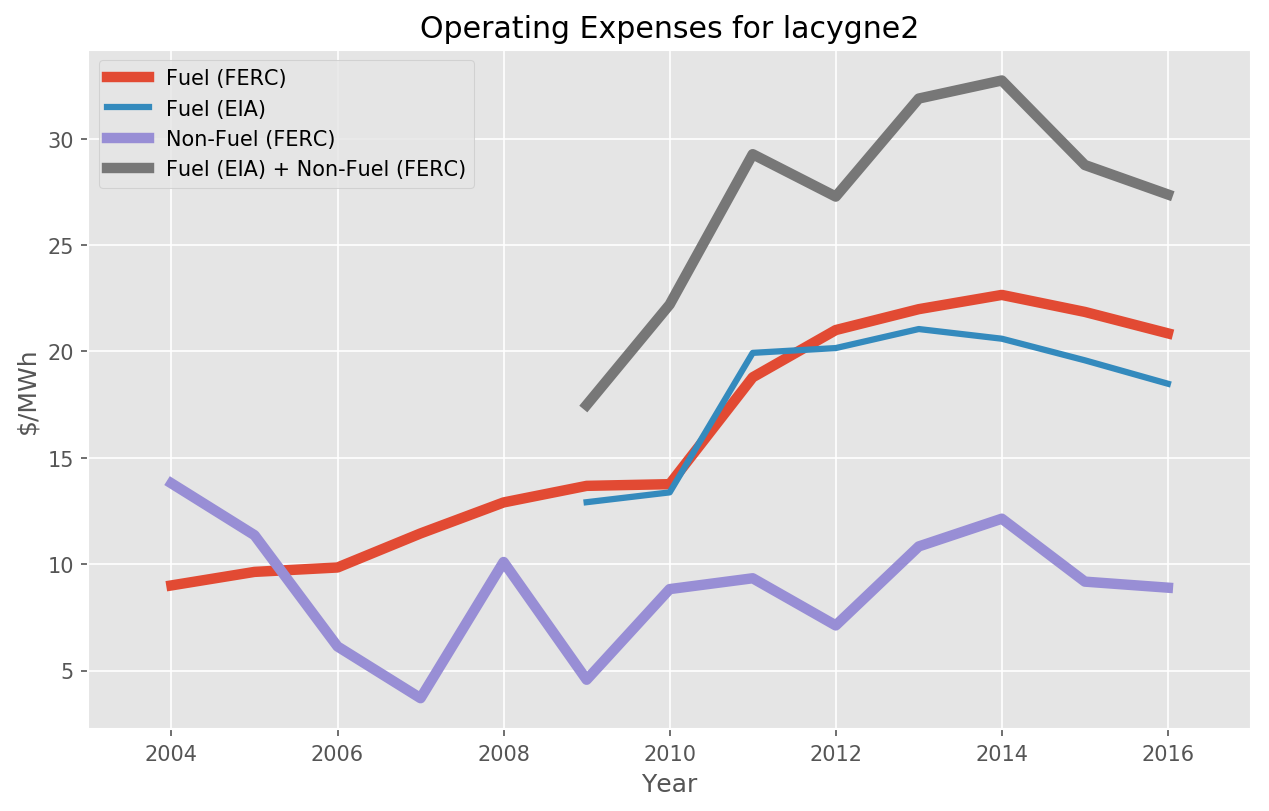

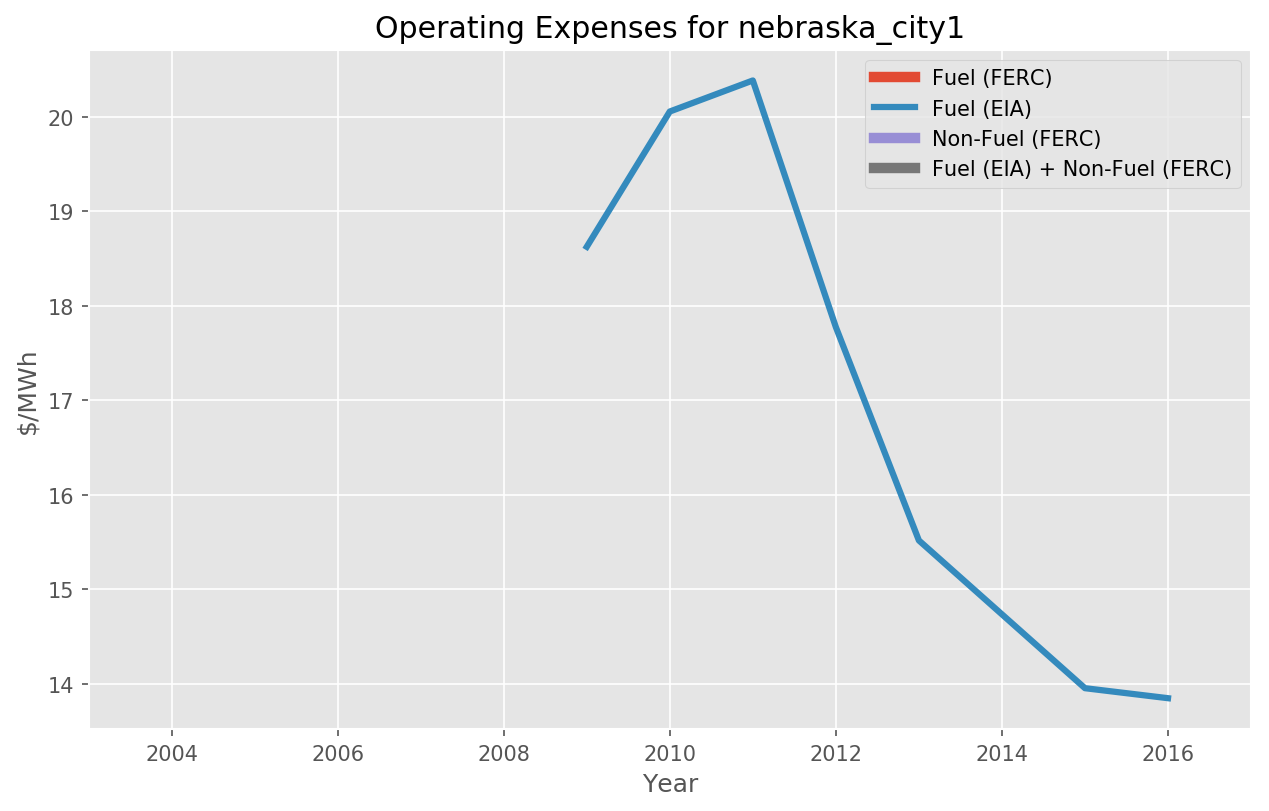

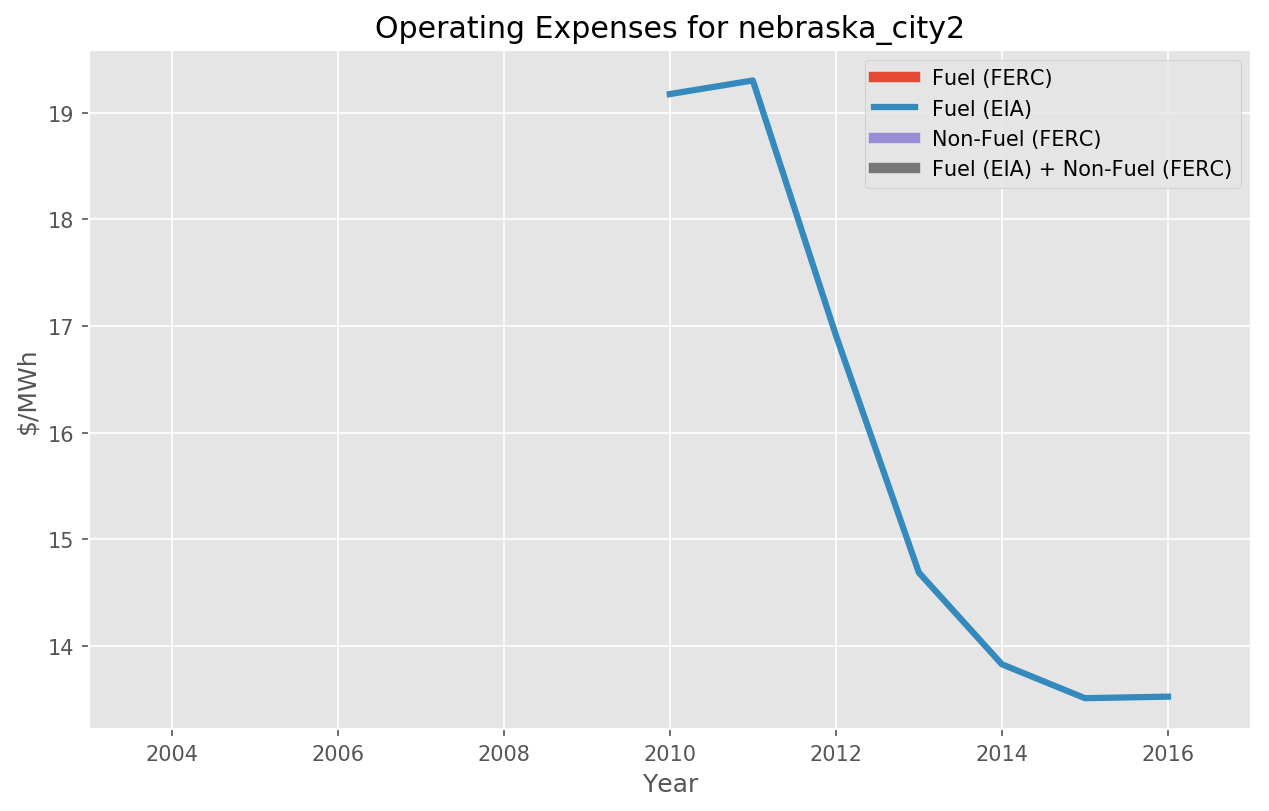

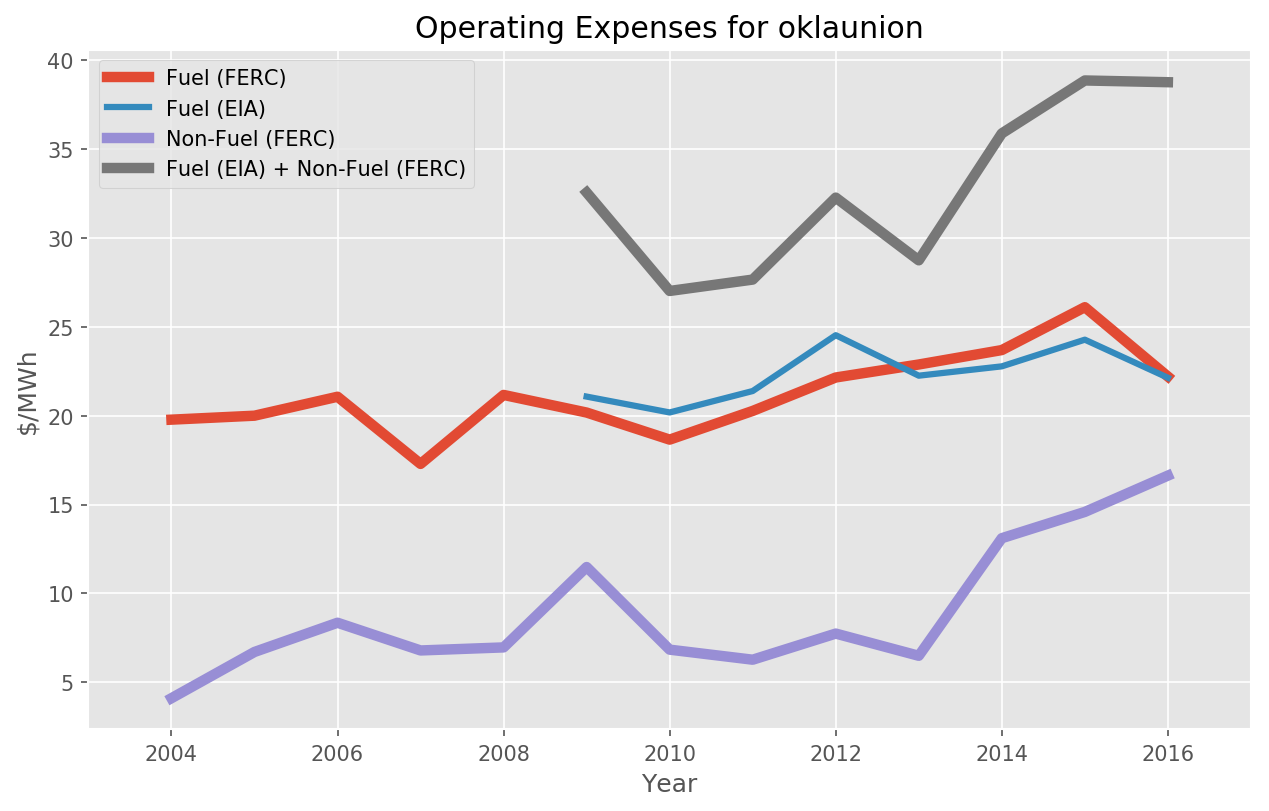

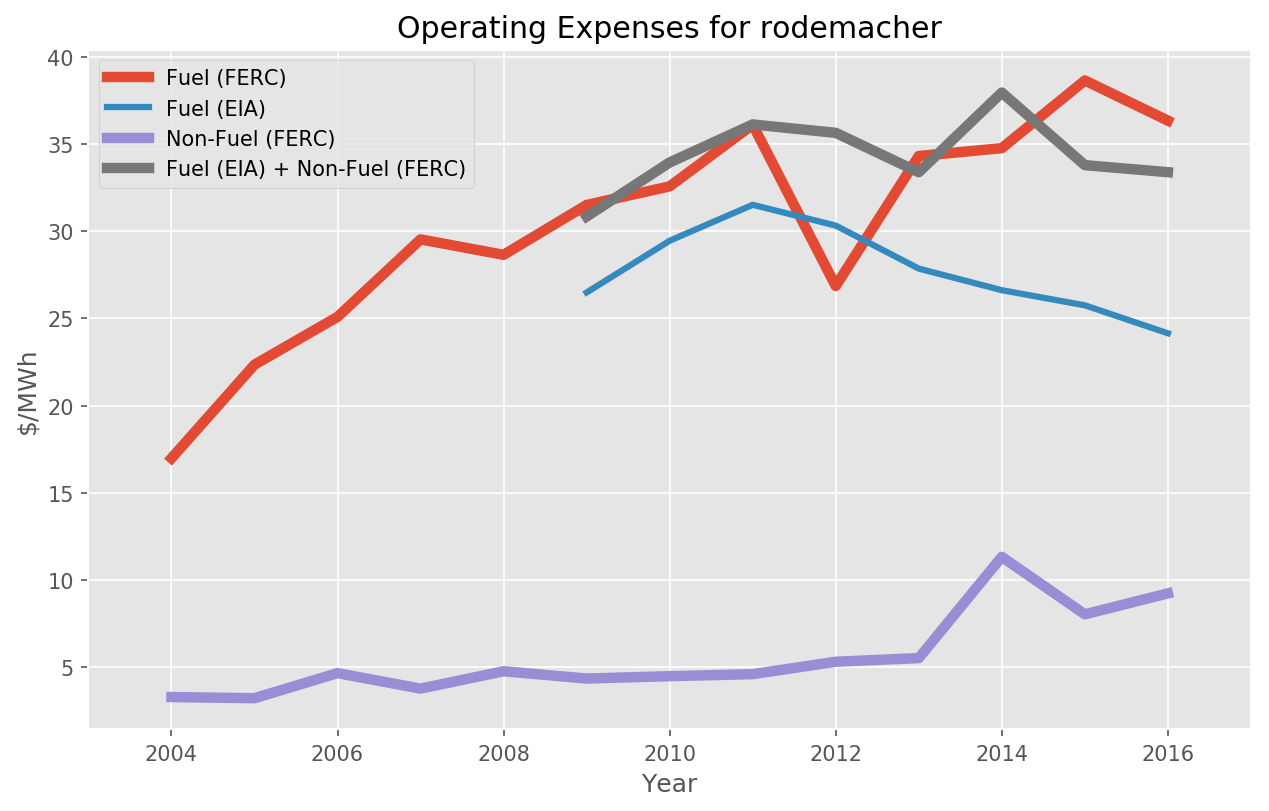

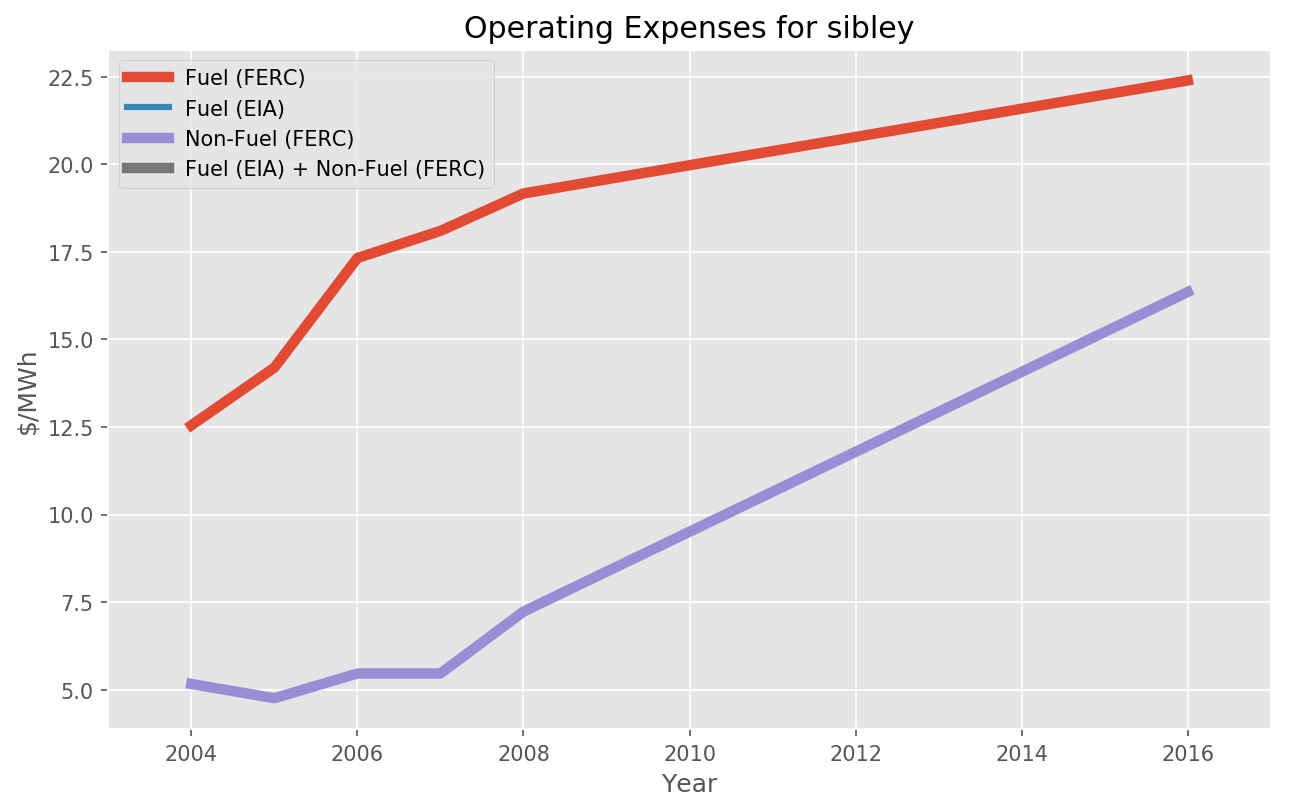

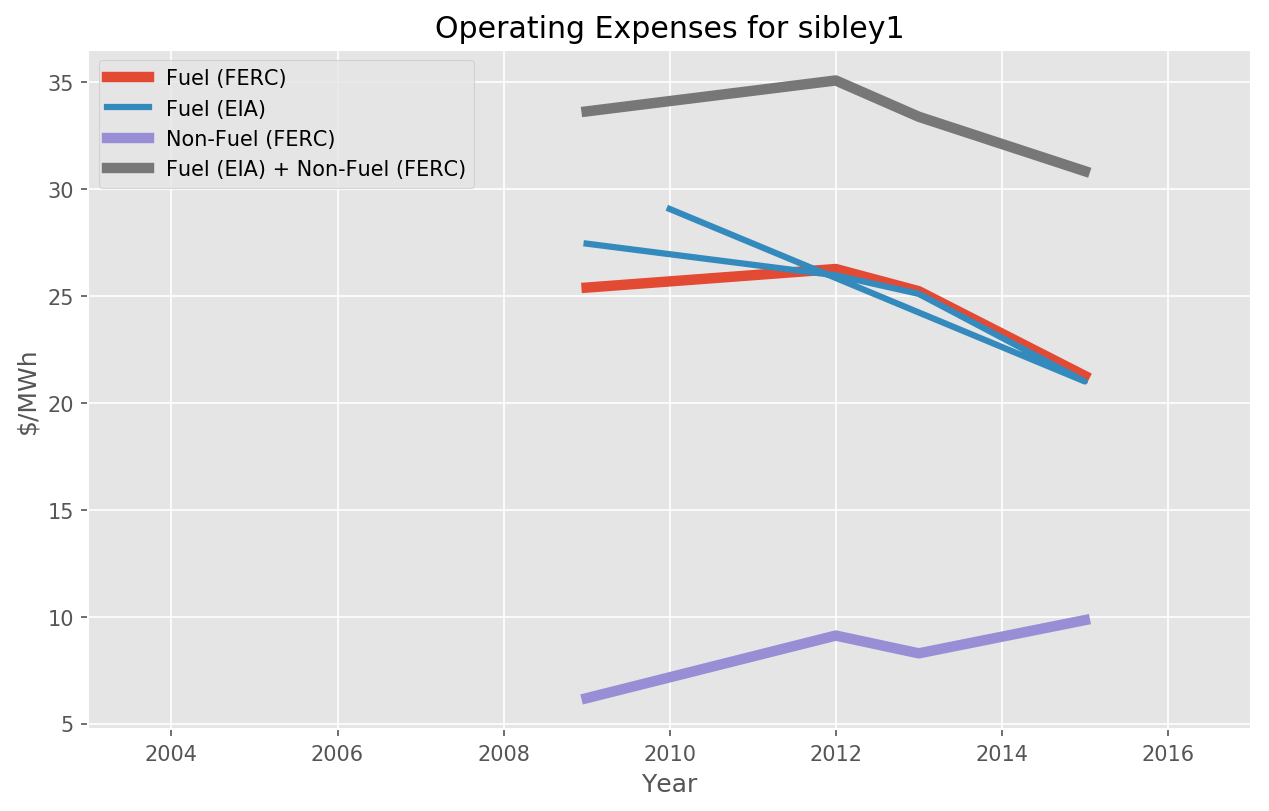

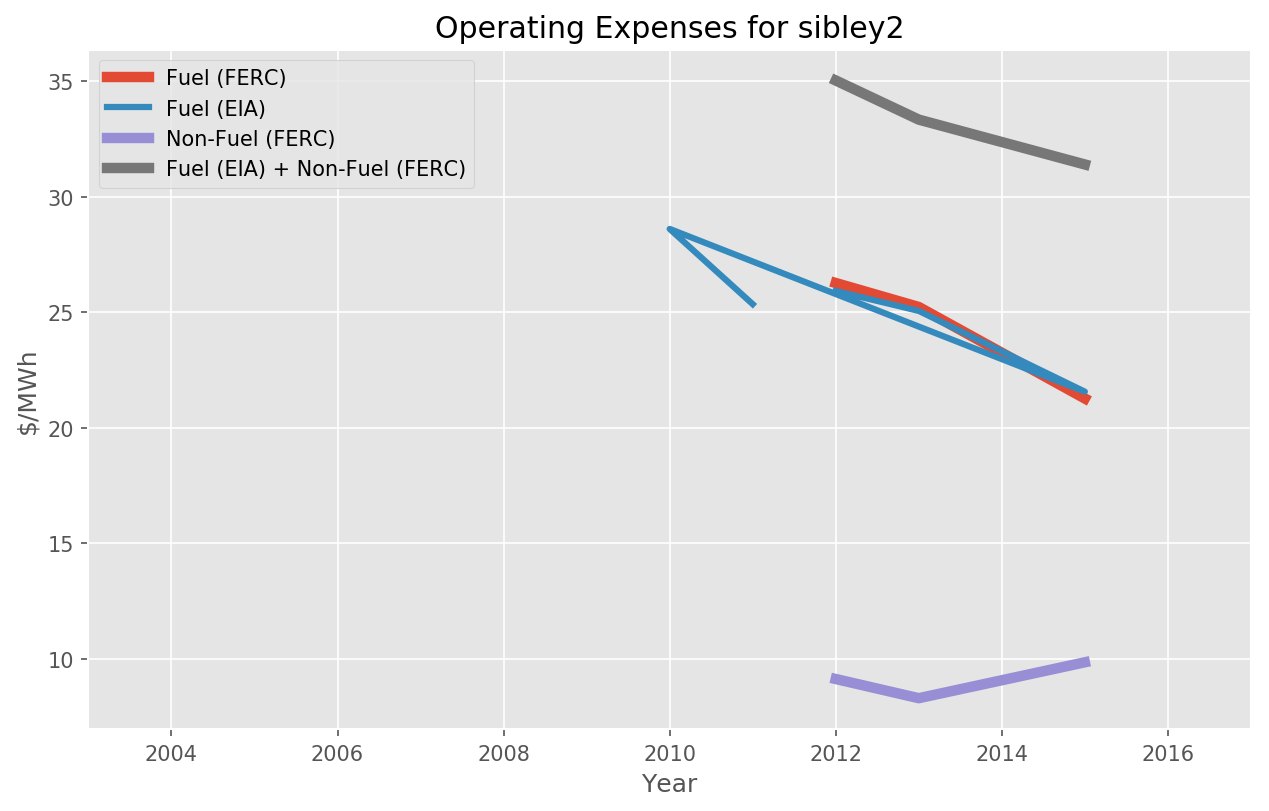

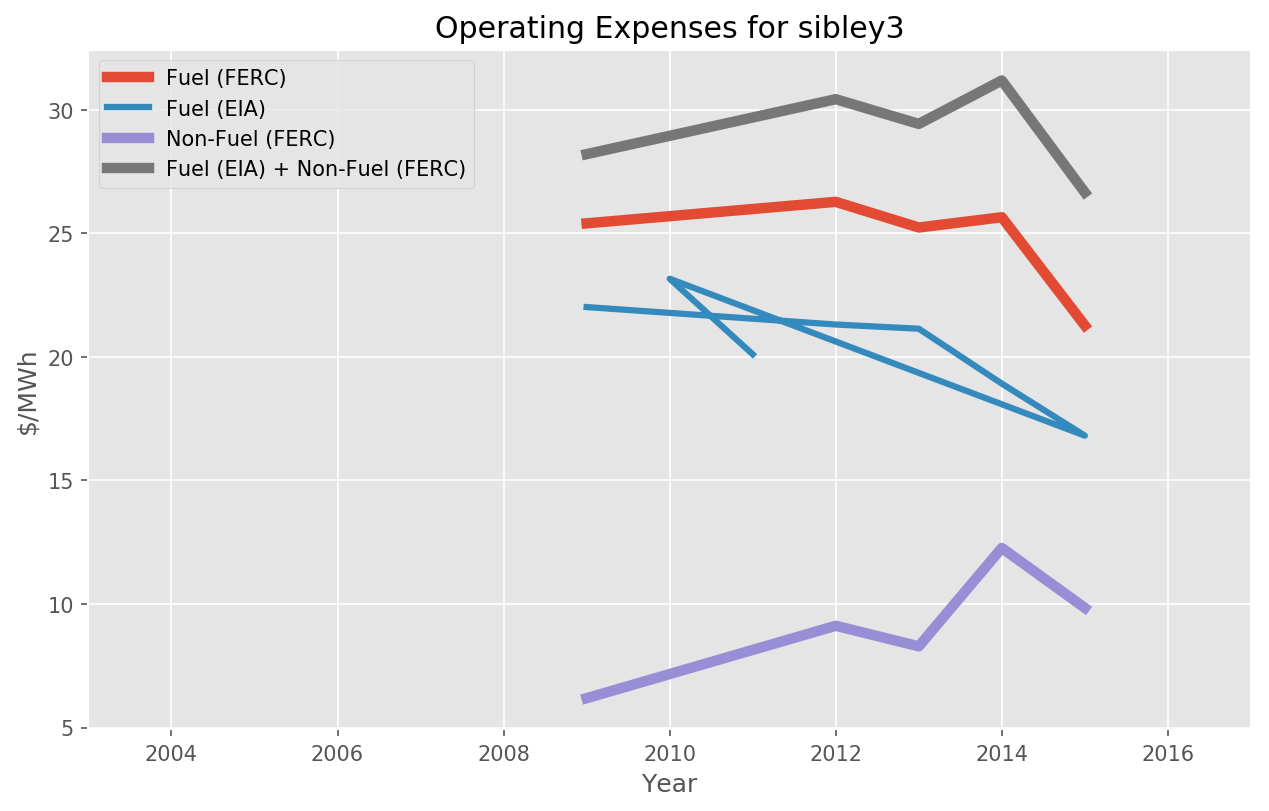

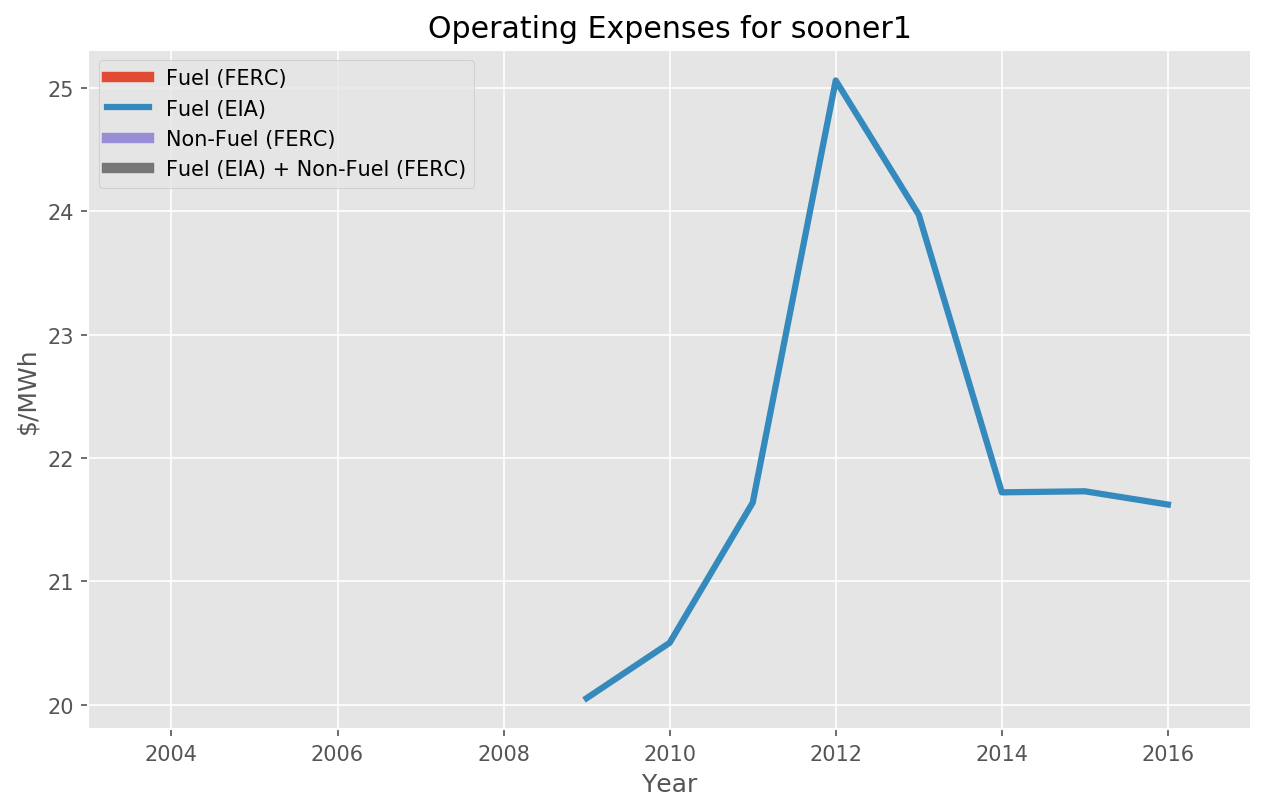

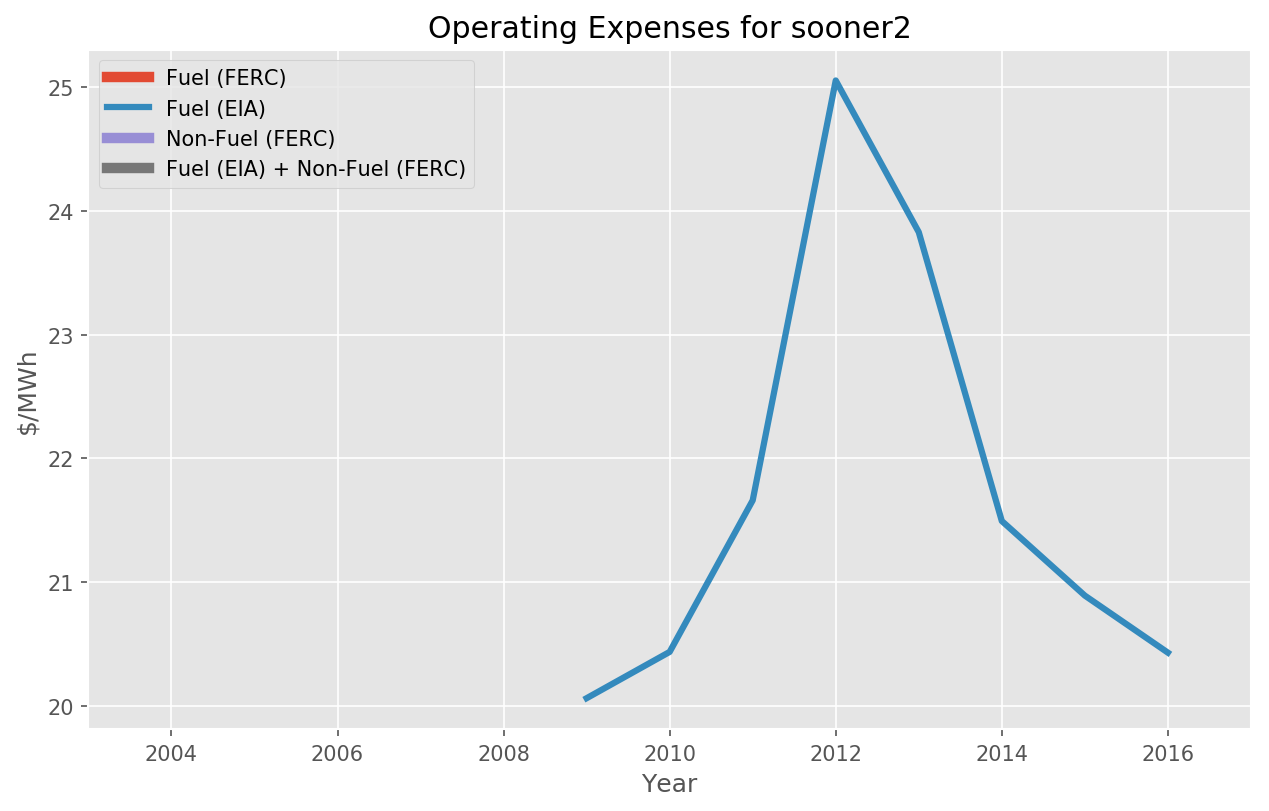

In [55]:
plot_ferc_eia(ces_byplant,
              cols=['expns_fuel_per_mwh', 'fuel_cost_per_mwh',
                    'expns_nonfuel_per_mwh', 'total_cost_per_mwh'],
              labels=['Fuel (FERC)', 'Fuel (EIA)',
                      'Non-Fuel (FERC)', 'Fuel (EIA) + Non-Fuel (FERC)'],
              lws=[5,3,5,5], title='Operating Expenses', ylabel='$/MWh')

In [ ]:
out_df = out_df[[
    'report_year',
    'plant_id_ces',
    'plant_name_ces',
    'plant_name_eia',
    'plant_name_ferc',
    'plant_id_eia',
    'generator_id',
    'iso_rto_code',
    'balancing_authority_code',
    'state',
    'latitude',
    'longitude',
    'nameplate_capacity_mw_eia',
    'nameplate_capacity_mw_ferc',
    'avg_num_employees',
    
    'heat_rate_mmbtu_mwh_eia',
    'heat_rate_mmbtu_mwh_ferc',
    'capacity_factor_eia',
    'capacity_factor_ferc',
    'expns_nonfuel_per_mwh',
    'fuel_cost_per_mwh_eia',
    'fuel_cost_per_mwh_ferc',
    'expns_per_mwh',
    
    'expns_boiler',
    'expns_coolants',
    'expns_electric',
    'expns_engineering',
    'expns_fuel',
    'expns_misc_power',
    'expns_misc_steam',
    'expns_nonfuel',
    'expns_operations',
    'expns_plants',
    'expns_production_total',
    'expns_rents',
    'expns_steam',
    'expns_steam_other',
    'expns_structures',
    'expns_transfer',
    'fuel_type_pudl',
    'net_generation_mwh_eia',
    'net_generation_mwh_ferc',
    'planned_retirement_date',
    'plant_id_pudl_ferc',
    'plant_id_pudl_eia',
    'total_fuel_cost_eia',
    'total_fuel_cost_ferc',
    'total_mmbtu_eia',
    'total_mmbtu_ferc',
    'unit_id_pudl',
    'util_id_pudl_ferc',
    'util_id_pudl_eia',
    'utility_id_eia',
    'utility_id_ferc',
    'utility_name_eia',
    'utility_name_ferc'
]]
out_df = out_df.sort_values(['report_year','plant_id_ces'])

In [ ]:
rodemacher = out_df[out_df.plant_name_ces=='oklaunion_aeptx_north']
plt.plot(rodemacher.report_year, rodemacher.fuel_cost_per_mwh_eia, label='EIA Fuel', lw=3)
plt.plot(rodemacher.report_year, rodemacher.fuel_cost_per_mwh_ferc, label='FERC Fuel', lw=3)
plt.plot(rodemacher.report_year, rodemacher.expns_nonfuel_per_mwh, label='FERC Non-Fuel', lw=3)
plt.plot(rodemacher.report_year, rodemacher.expns_per_mwh, label='FERC Total', lw=3)
plt.xlabel('Report Year')
plt.ylabel('Operating Cost ($/MWh)')
plt.title('FERC & EIA Operating Costs for Oklaunion')
plt.legend()
#plt.savefig('Rodemacher2_OpEx.png')
plt.show();

In [ ]:
plt.plot(rodemacher.report_year, rodemacher.heat_rate_mmbtu_mwh_eia, label='EIA', lw=3)
plt.plot(rodemacher.report_year, rodemacher.heat_rate_mmbtu_mwh_ferc, label='FERC', lw=3)
plt.xlabel('Report Year')
plt.ylabel('Heat Rate (mmBTU/MWh)')
plt.title('FERC & EIA Heat Rates for Rodemacher #2')
plt.legend()
#plt.savefig('Rodemacher2_HeatRate.png')
plt.show();

In [ ]:
plt.plot(rodemacher.report_year, rodemacher.capacity_factor_eia, label='EIA', lw=4)
plt.plot(rodemacher.report_year, rodemacher.capacity_factor_ferc/0.3, label='FERC', lw=2)
plt.xlabel('Report Year')
plt.ylabel('Capacity Factor')
plt.title('FERC vs. EIA Capacity Factors (ownership corrected) Rodemacher #2')
plt.legend()
plt.savefig('Rodemacher2_CapFac.png')
plt.show();

In [ ]:
aepco_cols = [
    'report_date',
    'utility_name',
    'utility_id',
    'plant_name',
    'plant_id_eia',
    'unit_id_pudl',
    'fuel_type_pudl',
    'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
]
aepco_df = eia_df[eia_df.utility_id==796][aepco_cols]
aepco_df.to_excel('/Users/zaneselvans/Desktop/AEPCo-op_EIA.xlsx', index=False)
aepco_df = aepco_df.set_index(['unit_id_pudl','report_date'])

In [ ]:
aepco_df.index.levels[0]

In [ ]:
for unit in [2,3]:
    plt.plot(aepco_df.loc[unit,'fuel_cost_per_mwh'], label=unit)
    plt.legend()

In [ ]:
#pacificorp_west_plants = pudl_mcoe_annual[(pudl_mcoe_annual.operator_id==14354) &
#                 (pudl_mcoe_annual.state.isin(['UT','MT','WY'])) &
#                 (pudl_mcoe_annual.fuel_type_pudl=='coal') &
#                 (pudl_mcoe_annual.report_date>=pd.to_datetime('2016-01-01'))][['plant_name','plant_id_eia']]
#plants_eia860 = pudl_out.plants_eia860()
#pudl_own = pudl_out.own_eia860()
#pacificorp_coal_own =  pudl_own[((pudl_own.ownership_id==14354) | (pudl_own.operator_id==14354)) &
#         (pudl_own.state.isin(['UT','MT','WY'])) &
#         (pudl_own.report_date>=pd.to_datetime('2000-01-01'))].plant_id_eia.unique().tolist()